In [11]:
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
from statsmodels.tsa.statespace.sarimax import SARIMAX
from bcb import sgs
import pandas
import time
import matplotlib.pyplot as plt


In [7]:
from bcb import sgs
ipca = sgs.get(('IPCA', 433))
ipca = ipca[ipca.index >= '2000-01-01']
ipca2 = ipca[ipca.index >= '2003-01-01']
ipca2 = ipca2[ipca2.index <= '2013-12-01']

ipca.tail(5)

,IPCA
Date,
2024-02-01,0.83
2024-03-01,0.16
2024-04-01,0.38
2024-05-01,0.46
2024-06-01,0.21


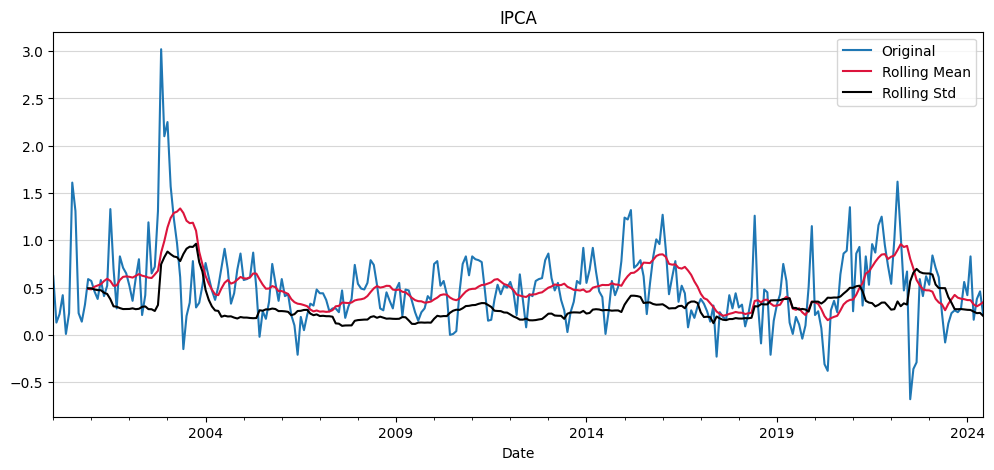

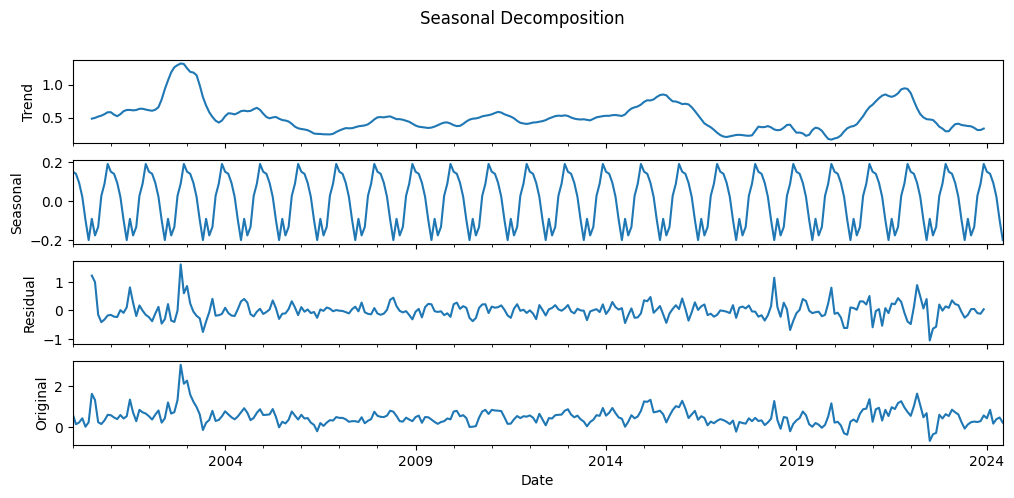

In [12]:
def plot_time_series(series):
    mean_rolling = series.rolling(window=12).mean()
    std_rolling = series.rolling(window=12).std()
    
    # plot inflation rates
    series.plot(figsize=(12, 5), label='Original')
    mean_rolling.plot(color='crimson', label='Rolling Mean')
    std_rolling.plot(color='black', label='Rolling Std')
    plt.title('IPCA')
    plt.grid(axis='y', alpha=0.5)
    plt.legend(loc='best')
    plt.show()
    
    from statsmodels.tsa.seasonal import seasonal_decompose
    
    # plot decomposition components
    decomp = seasonal_decompose(series, model='additive')
    fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 5))
    fig.suptitle('Seasonal Decomposition')
    
    decomp.trend.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Trend')
    
    decomp.seasonal.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Seasonal')
    
    decomp.resid.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Residual')
    
    decomp.observed.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Original')
    plt.show()

plot_time_series(ipca['IPCA'])

In [13]:
def adf_test(series):
    from statsmodels.tsa.stattools import adfuller
    
    result = adfuller(series, regression='c', autolag='AIC')
    print('======= Augmented Dickey-Fuller Test Results =======\n')
    print('1. ADF Test Statistic: {:.6f}'.format(result[0]))
    print('2. P-value: {:.6f}'.format(result[1]))
    print('3. Used Lags: {}'.format(result[2]))
    print('4. Used Observations: {}'.format(result[3]))
    print('5. Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.6f}'.format(key, value))
    
    critical_value = result[4]['5%']
    if (result[1] <= 0.05) and (result[0] < critical_value):
        print('\nStrong evidence against the null hypothesis (H0), reject the null hypothesis.\
        Data has no unit root and is stationary.')
    else:
        print('\nWeak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.')
    return

# run function
adf_test(ipca['IPCA'])

======= Augmented Dickey-Fuller Test Results =======

1. ADF Test Statistic: -8.226833
2. P-value: 0.000000
3. Used Lags: 0
4. Used Observations: 293
5. Critical Values:
	1%: -3.452867
	5%: -2.871455
	10%: -2.572053

Strong evidence against the null hypothesis (H0), reject the null hypothesis.        Data has no unit root and is stationary.


In [8]:
def find_optimal_orders(series, verbose=True):
    from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
    import warnings
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    import time
    
    # Start timer
    start_time = time.time()
    
    ######### List of possible combinations
    order_list = [(p, d, q) for p in range(0, 3) for d in range(0, 2) for q in range(0, 3)]
    
    ######### Initialize variables
    m = 12
    trend_pdq = order_list
    seasonal_pdq = [(x[0], x[1], x[2], m) for x in order_list]
    min_aic = float('inf')
    best_params = {'order': None, 'seasonal_order': None}
    
    ######### Loop through every possible configuration and print results
    print('Expected Fits: {}'.format(len(trend_pdq) * len(seasonal_pdq)))
    print('========== SARIMAX Results ==========\n')
    count = 0
    for param in trend_pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(endog=series, order=param, seasonal_order=param_seasonal,
                                enforce_stationarity=False, enforce_invertibility=False)
                model_fit = model.fit()
                
                if verbose:
                    count += 1
                    print('{}. SARIMAX{}{}[{}],\tAIC = {:.6f},\tBIC = {:.6f}'.format(count, param,
                                                        param_seasonal[:-1], m, model_fit.aic, model_fit.bic))
                    
                if model_fit.aic < min_aic:
                    min_aic = model_fit.aic
                    best_params['order'] = param
                    best_params['seasonal_order'] = param_seasonal
                    line = count
            except Exception as e:
                print(f'Error while fitting model SARIMAX{param}{param_seasonal[:-1]}: {e}')
                continue
    print('\nBest order: {}{}[{}] with AIC = {:.6f} at line {}'.format(best_params['order'],
                                                             best_params['seasonal_order'][:-1], m, min_aic, line))
    
    # Stop timer and display execution time
    diff = time.time() - start_time
    print('\n(Total time of execution: {:.0f} min {:.2f} s)'.format(diff // 60, diff % 60))

# Testando com uma configuração reduzida
#find_optimal_orders(ipca['IPCA'], verbose=True)

In [9]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
from statsmodels.tsa.statespace.sarimax import SARIMAX

def forecast_SARIMA(series, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), exog=None):
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    
    # Determinar a frequência do índice
    if series.index.freq is None:
        series = series.asfreq(pd.infer_freq(series.index))
    
    # Desenvolver o modelo
    model = SARIMAX(endog=series, order=order, seasonal_order=seasonal_order, exog=exog,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    
    # Previsões
    yhat = model_fit.predict(start=series.index[0], end=series.index[-1], typ='levels', dynamic=False).rename('Predict')

    # Previsão e intervalos de confiança 70% e 95%
    conf_int_70 = model_fit.get_forecast(steps=6).summary_frame(alpha=0.3)
    conf_int_95 = model_fit.get_forecast(steps=6).summary_frame(alpha=0.05)
    
    # Extrair lista de índices
    indx_list = conf_int_95.index
    
    # 1º gráfico - taxas reais vs previstas
    plt.figure(figsize=(16, 3))
    series.plot(legend=True, label='Real', color='green')
    yhat.plot(legend=True, color='orange')
    plt.title('Taxas Reais vs Previsões')
    plt.legend()
    plt.show()
    
    # 2º gráfico - resultados da previsão
    plt.figure(figsize=(16, 6))
    series.plot(legend=True, label='Real', color='orange')
    yhat.plot(legend=True, color='green')
    conf_int_95['mean'].plot(legend=True, label='Previsão', color='crimson')
    # Intervalos de confiança 95%
    plt.fill_between(x=indx_list, y1=conf_int_95['mean_ci_upper'], y2=conf_int_95['mean_ci_lower'],
                     alpha=0.4, label='Intervalo de Confiança 95%', linewidth=0)
    # Intervalos de confiança 70%
    plt.fill_between(x=indx_list, y1=conf_int_70['mean_ci_upper'], y2=conf_int_70['mean_ci_lower'],
                     alpha=0.6, label='Intervalo de Confiança 70%', linewidth=0)
    plt.title('Previsão de Inflação')
    plt.legend(loc='upper left')
    plt.show()
    
    # Exibir taxas previstas
    return pd.DataFrame(round(conf_int_95['mean'], 1)).rename({'mean': 'Previsão [%]'}, axis=1)

# Exemplo de uso
# Assumindo que 'ipca' é um DataFrame com a coluna 'IPCA' e o índice como datas
#forecast_SARIMA(series=ipca['IPCA'], order=(1, 0, 0), seasonal_order=(1, 1, 2, 12))

In [29]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
from statsmodels.tsa.statespace.sarimax import SARIMAX

def forecast_SARIMA(series, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), exog=None):
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    
    # Determinar a frequência do índice
    if series.index.freq is None:
        series = series.asfreq(pd.infer_freq(series.index))
    
    # Desenvolver o modelo
    model = SARIMAX(endog=series, order=order, seasonal_order=seasonal_order, exog=exog,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    
    # Previsões
    yhat = model_fit.predict(start=series.index[0], end=series.index[-1], typ='levels', dynamic=False).rename('Predict')

    # Previsão e intervalos de confiança 70% e 95%
    conf_int_70 = model_fit.get_forecast(steps=6).summary_frame(alpha=0.3)
    conf_int_95 = model_fit.get_forecast(steps=6).summary_frame(alpha=0.05)
    
    # Extrair lista de índices
    indx_list = conf_int_95.index
    
    # Determinar o intervalo de 5 anos para exibir no segundo gráfico
    end_date = series.index[-1]
    start_date_5_years = end_date - pd.DateOffset(years=5)

    # 1º gráfico - taxas reais vs previstas (série completa)
    plt.figure(figsize=(16, 3))
    series.plot(legend=True, label='Real', color='green')
    yhat.plot(legend=True, color='orange')
    plt.title('Taxas Reais vs Previsões (Série Completa)')
    plt.legend()
    plt.show()
    
    # 2º gráfico - resultados da previsão (últimos 5 anos)
    plt.figure(figsize=(16, 6))
    series.loc[start_date_5_years:].plot(legend=True, label='Real', color='orange')
    yhat.loc[start_date_5_years:].plot(legend=True, color='green')
    conf_int_95['mean'].loc[start_date_5_years:].plot(legend=True, label='Previsão', color='crimson')
    # Intervalos de confiança 95%
    plt.fill_between(x=indx_list, y1=conf_int_95['mean_ci_upper'].loc[start_date_5_years:], y2=conf_int_95['mean_ci_lower'].loc[start_date_5_years:],
                     alpha=0.4, label='Intervalo de Confiança 95%', linewidth=0)
    # Intervalos de confiança 70%
    plt.fill_between(x=indx_list, y1=conf_int_70['mean_ci_upper'].loc[start_date_5_years:], y2=conf_int_70['mean_ci_lower'].loc[start_date_5_years:],
                     alpha=0.6, label='Intervalo de Confiança 70%', linewidth=0)
    plt.title('Previsão de Inflação (Últimos 5 Anos)')
    plt.legend(loc='upper left')
    plt.show()
    
    # Exibir taxas previstas
    return pd.DataFrame(round(conf_int_95['mean'], 1)).rename({'mean': 'Previsão [%]'}, axis=1)

# Exemplo de uso
# Assumindo que 'ipca' é um DataFrame com a coluna 'IPCA' e o índice como datas
#forecast_SARIMA(series=ipca['IPCA'], order=(1, 0, 0), seasonal_order=(1, 1, 2, 12))



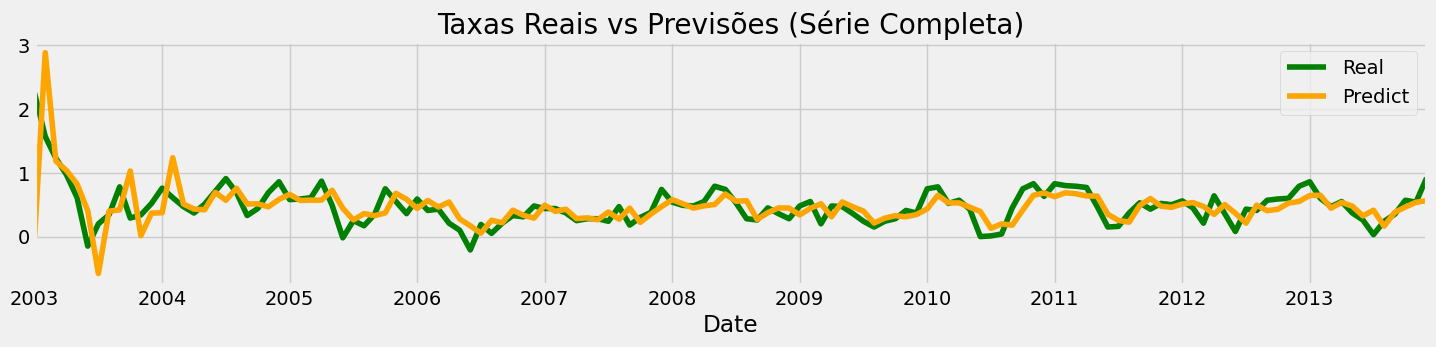

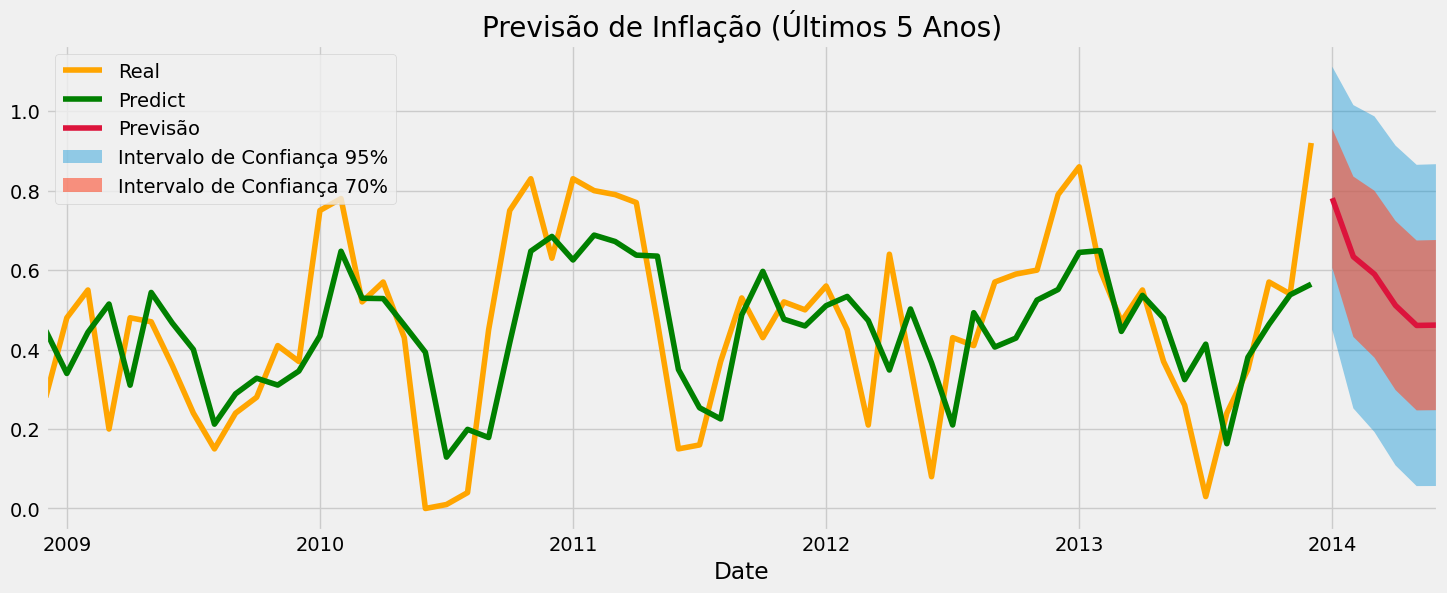

,Previsão [%]
2014-01-01,0.8
2014-02-01,0.6
2014-03-01,0.6
2014-04-01,0.5
2014-05-01,0.5
2014-06-01,0.5


In [78]:
forecast_SARIMA(series=ipca2['IPCA'], order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))


In [25]:
planilha = pd.read_excel("C:\\Users\\Enrico.bisordi\\OneDrive - Rio Bravo\\Arquivos de Chat do Microsoft Teams\\Juros Reais2.xlsx", header=1)
planilha['year_month'] = pd.to_datetime(planilha['year_month'], format='%Y-%m')
planilha.set_index('year_month', inplace=True)

planilha2 = planilha[['CPI EUA']].copy()
planilha2

,CPI EUA
year_month,
2017-08-01,2.213503
2017-09-01,2.015924
2017-10-01,2.180537
2017-11-01,2.091918
2017-12-01,2.042188
...,...
2023-08-01,3.650372
2023-09-01,3.214313
2023-10-01,3.121578


In [35]:
find_optimal_orders(planilha2['CPI EUA'], verbose=True)

Expected Fits: 324
========== SARIMAX Results ==========

1. SARIMAX(0, 0, 0)(0, 0, 0)[12],	AIC = 441.106383,	BIC = 443.437116
2. SARIMAX(0, 0, 0)(0, 0, 1)[12],	AIC = 382.164717,	BIC = 386.482483
3. SARIMAX(0, 0, 0)(0, 0, 2)[12],	AIC = 1896.215766,	BIC = 1902.069497
4. SARIMAX(0, 0, 0)(0, 1, 0)[12],	AIC = 328.686360,	BIC = 330.845244
5. SARIMAX(0, 0, 0)(0, 1, 1)[12],	AIC = 272.604490,	BIC = 276.506978


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


6. SARIMAX(0, 0, 0)(0, 1, 2)[12],	AIC = 214.999579,	BIC = 220.066217
7. SARIMAX(0, 0, 0)(1, 0, 0)[12],	AIC = 329.283272,	BIC = 333.632047
8. SARIMAX(0, 0, 0)(1, 0, 1)[12],	AIC = 326.155005,	BIC = 332.631654
9. SARIMAX(0, 0, 0)(1, 0, 2)[12],	AIC = 1655.535659,	BIC = 1663.340633
10. SARIMAX(0, 0, 0)(1, 1, 0)[12],	AIC = 282.348853,	BIC = 286.289436
11. SARIMAX(0, 0, 0)(1, 1, 1)[12],	AIC = 280.375119,	BIC = 286.228850


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


12. SARIMAX(0, 0, 0)(1, 1, 2)[12],	AIC = 215.864601,	BIC = 222.620119
13. SARIMAX(0, 0, 0)(2, 0, 0)[12],	AIC = 281.689396,	BIC = 287.600272
14. SARIMAX(0, 0, 0)(2, 0, 1)[12],	AIC = 282.814461,	BIC = 290.695629
15. SARIMAX(0, 0, 0)(2, 0, 2)[12],	AIC = 268.979069,	BIC = 278.735287
16. SARIMAX(0, 0, 0)(2, 1, 0)[12],	AIC = 211.479932,	BIC = 216.620648
17. SARIMAX(0, 0, 0)(2, 1, 1)[12],	AIC = 213.519572,	BIC = 220.373860


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


KeyboardInterrupt: 

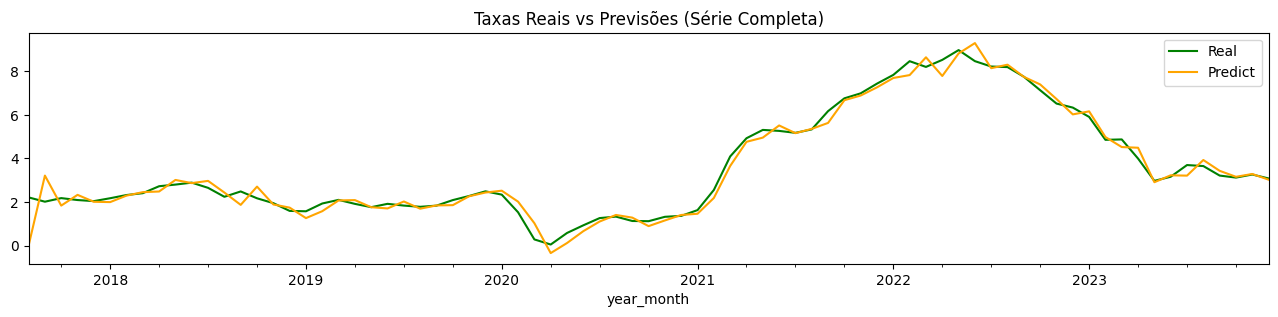

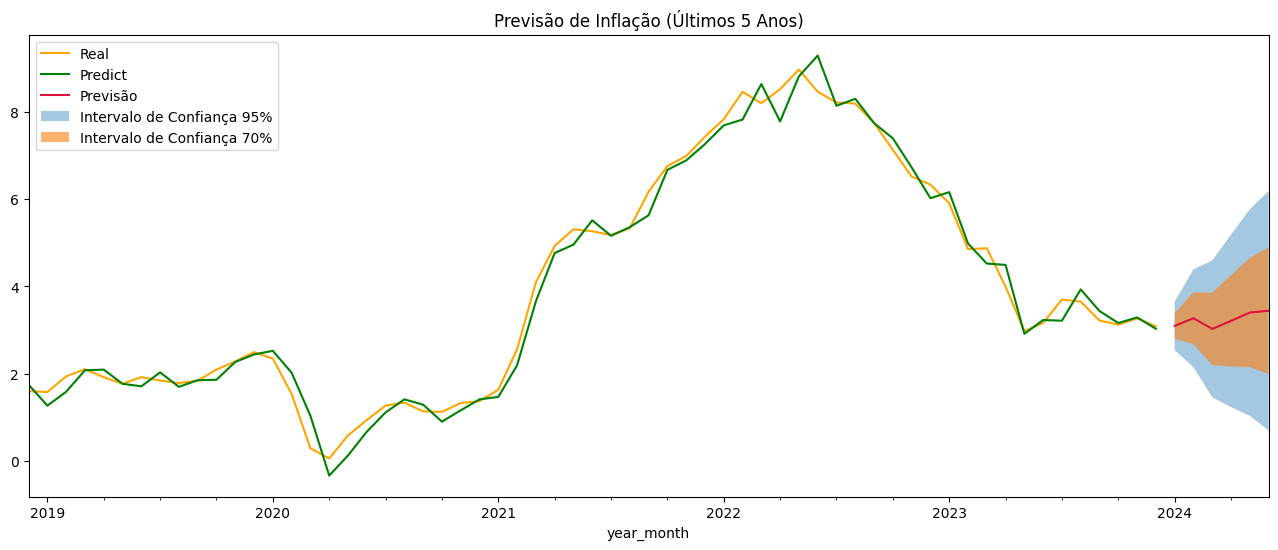

,Previsão [%]
2024-01-01,3.1
2024-02-01,3.3
2024-03-01,3.0
2024-04-01,3.2
2024-05-01,3.4
2024-06-01,3.4


In [30]:
forecast_SARIMA(series=planilha2['CPI EUA'], order=(1, 1, 2), seasonal_order=(0, 0, 1, 12))


In [32]:
planilha3 = planilha[['CPI CHI']].copy()
find_optimal_orders(planilha3['CPI CHI'], verbose=True)

Expected Fits: 324
========== SARIMAX Results ==========

1. SARIMAX(0, 0, 0)(0, 0, 0)[12],	AIC = 337.130596,	BIC = 339.461330
2. SARIMAX(0, 0, 0)(0, 0, 1)[12],	AIC = 277.258421,	BIC = 281.576187
3. SARIMAX(0, 0, 0)(0, 0, 2)[12],	AIC = 2204.510091,	BIC = 2210.363822
4. SARIMAX(0, 0, 0)(0, 1, 0)[12],	AIC = 278.761955,	BIC = 280.920838
5. SARIMAX(0, 0, 0)(0, 1, 1)[12],	AIC = 210.213494,	BIC = 214.115982


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


6. SARIMAX(0, 0, 0)(0, 1, 2)[12],	AIC = 157.183478,	BIC = 162.250116
7. SARIMAX(0, 0, 0)(1, 0, 0)[12],	AIC = 265.249295,	BIC = 269.598070
8. SARIMAX(0, 0, 0)(1, 0, 1)[12],	AIC = 229.884011,	BIC = 236.360660
9. SARIMAX(0, 0, 0)(1, 0, 2)[12],	AIC = 2112.338155,	BIC = 2120.143130
10. SARIMAX(0, 0, 0)(1, 1, 0)[12],	AIC = 217.609562,	BIC = 221.550146
11. SARIMAX(0, 0, 0)(1, 1, 1)[12],	AIC = 208.365215,	BIC = 214.218946


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


12. SARIMAX(0, 0, 0)(1, 1, 2)[12],	AIC = 154.062892,	BIC = 160.818410
13. SARIMAX(0, 0, 0)(2, 0, 0)[12],	AIC = 209.241178,	BIC = 215.152053
14. SARIMAX(0, 0, 0)(2, 0, 1)[12],	AIC = 181.122185,	BIC = 189.003353
15. SARIMAX(0, 0, 0)(2, 0, 2)[12],	AIC = 161.582273,	BIC = 171.338491
16. SARIMAX(0, 0, 0)(2, 1, 0)[12],	AIC = 154.675893,	BIC = 159.816609
17. SARIMAX(0, 0, 0)(2, 1, 1)[12],	AIC = 148.349957,	BIC = 155.204245


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


18. SARIMAX(0, 0, 0)(2, 1, 2)[12],	AIC = 156.062685,	BIC = 164.507082
19. SARIMAX(0, 0, 1)(0, 0, 0)[12],	AIC = 248.134313,	BIC = 252.769290
20. SARIMAX(0, 0, 1)(0, 0, 1)[12],	AIC = 203.123004,	BIC = 209.552409
21. SARIMAX(0, 0, 1)(0, 0, 2)[12],	AIC = 3294.220735,	BIC = 3301.948038
22. SARIMAX(0, 0, 1)(0, 1, 0)[12],	AIC = 214.926991,	BIC = 219.213260
23. SARIMAX(0, 0, 1)(0, 1, 1)[12],	AIC = 155.169152,	BIC = 160.964629


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


24. SARIMAX(0, 0, 1)(0, 1, 2)[12],	AIC = 116.804371,	BIC = 123.458618
25. SARIMAX(0, 0, 1)(1, 0, 0)[12],	AIC = 199.720275,	BIC = 206.243437
26. SARIMAX(0, 0, 1)(1, 0, 1)[12],	AIC = 168.844644,	BIC = 177.417183
27. SARIMAX(0, 0, 1)(1, 0, 2)[12],	AIC = 1962.119736,	BIC = 1971.778864
28. SARIMAX(0, 0, 1)(1, 1, 0)[12],	AIC = 165.870271,	BIC = 171.781147
29. SARIMAX(0, 0, 1)(1, 1, 1)[12],	AIC = 152.795253,	BIC = 160.522556


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


30. SARIMAX(0, 0, 1)(1, 1, 2)[12],	AIC = 113.657843,	BIC = 121.975651
31. SARIMAX(0, 0, 1)(2, 0, 0)[12],	AIC = 157.278185,	BIC = 165.159353
32. SARIMAX(0, 0, 1)(2, 0, 1)[12],	AIC = 131.416118,	BIC = 141.267577
33. SARIMAX(0, 0, 1)(2, 0, 2)[12],	AIC = 112.855336,	BIC = 124.446290
34. SARIMAX(0, 0, 1)(2, 1, 0)[12],	AIC = 112.781166,	BIC = 119.635454
35. SARIMAX(0, 0, 1)(2, 1, 1)[12],	AIC = 109.975138,	BIC = 118.542998


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


36. SARIMAX(0, 0, 1)(2, 1, 2)[12],	AIC = 115.695640,	BIC = 125.677010
37. SARIMAX(0, 0, 2)(0, 0, 0)[12],	AIC = 197.324983,	BIC = 204.237178
38. SARIMAX(0, 0, 2)(0, 0, 1)[12],	AIC = 165.059460,	BIC = 173.567998
39. SARIMAX(0, 0, 2)(0, 0, 2)[12],	AIC = 2018.883158,	BIC = 2028.443273
40. SARIMAX(0, 0, 2)(0, 1, 0)[12],	AIC = 187.284696,	BIC = 193.666099
41. SARIMAX(0, 0, 2)(0, 1, 1)[12],	AIC = 129.898664,	BIC = 137.546756


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


42. SARIMAX(0, 0, 2)(0, 1, 2)[12],	AIC = 92.590602,	BIC = 100.778533
43. SARIMAX(0, 0, 2)(1, 0, 0)[12],	AIC = 169.827018,	BIC = 178.524567
44. SARIMAX(0, 0, 2)(1, 0, 1)[12],	AIC = 142.707259,	BIC = 153.342931
45. SARIMAX(0, 0, 2)(1, 0, 2)[12],	AIC = 2029.595793,	BIC = 2041.067932
46. SARIMAX(0, 0, 2)(1, 1, 0)[12],	AIC = 136.992541,	BIC = 144.873709
47. SARIMAX(0, 0, 2)(1, 1, 1)[12],	AIC = 123.914570,	BIC = 133.474685


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


48. SARIMAX(0, 0, 2)(1, 1, 2)[12],	AIC = 86.094651,	BIC = 95.920168
49. SARIMAX(0, 0, 2)(2, 0, 0)[12],	AIC = 130.193764,	BIC = 140.045223
50. SARIMAX(0, 0, 2)(2, 0, 1)[12],	AIC = 110.468265,	BIC = 122.290017
51. SARIMAX(0, 0, 2)(2, 0, 2)[12],	AIC = 90.761281,	BIC = 104.145442
52. SARIMAX(0, 0, 2)(2, 1, 0)[12],	AIC = 87.520025,	BIC = 96.087886
53. SARIMAX(0, 0, 2)(2, 1, 1)[12],	AIC = 89.336001,	BIC = 99.617433


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


54. SARIMAX(0, 0, 2)(2, 1, 2)[12],	AIC = 95.120909,	BIC = 106.584012
55. SARIMAX(0, 1, 0)(0, 0, 0)[12],	AIC = 114.613631,	BIC = 116.931119
56. SARIMAX(0, 1, 0)(0, 0, 1)[12],	AIC = 74.436439,	BIC = 78.722709
57. SARIMAX(0, 1, 0)(0, 0, 2)[12],	AIC = 2000.247851,	BIC = 2006.043328
58. SARIMAX(0, 1, 0)(0, 1, 0)[12],	AIC = 168.987222,	BIC = 171.130357
59. SARIMAX(0, 1, 0)(0, 1, 1)[12],	AIC = 104.683289,	BIC = 108.546940


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


60. SARIMAX(0, 1, 0)(0, 1, 2)[12],	AIC = 66.001963,	BIC = 70.992648
61. SARIMAX(0, 1, 0)(1, 0, 0)[12],	AIC = 78.403098,	BIC = 82.720864
62. SARIMAX(0, 1, 0)(1, 0, 1)[12],	AIC = 71.918836,	BIC = 78.348240
63. SARIMAX(0, 1, 0)(1, 0, 2)[12],	AIC = 2217.058043,	BIC = 2224.785346
64. SARIMAX(0, 1, 0)(1, 1, 0)[12],	AIC = 112.734922,	BIC = 116.637409
65. SARIMAX(0, 1, 0)(1, 1, 1)[12],	AIC = 93.002542,	BIC = 98.798019


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


66. SARIMAX(0, 1, 0)(1, 1, 2)[12],	AIC = 65.564260,	BIC = 72.218507
67. SARIMAX(0, 1, 0)(2, 0, 0)[12],	AIC = 65.512733,	BIC = 71.366464
68. SARIMAX(0, 1, 0)(2, 0, 1)[12],	AIC = 67.250140,	BIC = 75.055114
69. SARIMAX(0, 1, 0)(2, 0, 2)[12],	AIC = 1808.220525,	BIC = 1817.879653
70. SARIMAX(0, 1, 0)(2, 1, 0)[12],	AIC = 66.928827,	BIC = 71.995466
71. SARIMAX(0, 1, 0)(2, 1, 1)[12],	AIC = 68.918804,	BIC = 75.674322


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


72. SARIMAX(0, 1, 0)(2, 1, 2)[12],	AIC = 68.232543,	BIC = 76.550351
73. SARIMAX(0, 1, 1)(0, 0, 0)[12],	AIC = 112.763308,	BIC = 117.371438
74. SARIMAX(0, 1, 1)(0, 0, 1)[12],	AIC = 71.604713,	BIC = 77.986116
75. SARIMAX(0, 1, 1)(0, 0, 2)[12],	AIC = 1817.539371,	BIC = 1825.187463
76. SARIMAX(0, 1, 1)(0, 1, 0)[12],	AIC = 164.251672,	BIC = 168.505941
77. SARIMAX(0, 1, 1)(0, 1, 1)[12],	AIC = 100.430942,	BIC = 106.167011


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


78. SARIMAX(0, 1, 1)(0, 1, 2)[12],	AIC = 60.142613,	BIC = 66.692958
79. SARIMAX(0, 1, 1)(1, 0, 0)[12],	AIC = 73.657469,	BIC = 80.134119
80. SARIMAX(0, 1, 1)(1, 0, 1)[12],	AIC = 66.970905,	BIC = 75.479443
81. SARIMAX(0, 1, 1)(1, 0, 2)[12],	AIC = 1266.822071,	BIC = 1276.382186
82. SARIMAX(0, 1, 1)(1, 1, 0)[12],	AIC = 110.307997,	BIC = 116.161728
83. SARIMAX(0, 1, 1)(1, 1, 1)[12],	AIC = 87.148375,	BIC = 94.796467


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


84. SARIMAX(0, 1, 1)(1, 1, 2)[12],	AIC = 58.456366,	BIC = 66.644296
85. SARIMAX(0, 1, 1)(2, 0, 0)[12],	AIC = 59.207916,	BIC = 67.012891
86. SARIMAX(0, 1, 1)(2, 0, 1)[12],	AIC = 61.186643,	BIC = 70.942862
87. SARIMAX(0, 1, 1)(2, 0, 2)[12],	AIC = 1159.484852,	BIC = 1170.956990
88. SARIMAX(0, 1, 1)(2, 1, 0)[12],	AIC = 64.521521,	BIC = 71.277039
89. SARIMAX(0, 1, 1)(2, 1, 1)[12],	AIC = 65.627434,	BIC = 74.071832


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


90. SARIMAX(0, 1, 1)(2, 1, 2)[12],	AIC = 58.876727,	BIC = 68.702244
91. SARIMAX(0, 1, 2)(0, 0, 0)[12],	AIC = 113.981362,	BIC = 120.852741
92. SARIMAX(0, 1, 2)(0, 0, 1)[12],	AIC = 73.209726,	BIC = 81.653222
93. SARIMAX(0, 1, 2)(0, 0, 2)[12],	AIC = 1911.641324,	BIC = 1921.100426
94. SARIMAX(0, 1, 2)(0, 1, 0)[12],	AIC = 164.655822,	BIC = 170.988444
95. SARIMAX(0, 1, 2)(0, 1, 1)[12],	AIC = 99.766004,	BIC = 107.333286


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


96. SARIMAX(0, 1, 2)(0, 1, 2)[12],	AIC = 59.024609,	BIC = 67.079198
97. SARIMAX(0, 1, 2)(1, 0, 0)[12],	AIC = 75.446380,	BIC = 84.081913
98. SARIMAX(0, 1, 2)(1, 0, 1)[12],	AIC = 67.617698,	BIC = 78.172068
99. SARIMAX(0, 1, 2)(1, 0, 2)[12],	AIC = 1878.844639,	BIC = 1890.195561
100. SARIMAX(0, 1, 2)(1, 1, 0)[12],	AIC = 111.069938,	BIC = 118.874913
101. SARIMAX(0, 1, 2)(1, 1, 1)[12],	AIC = 86.620017,	BIC = 96.079118


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


102. SARIMAX(0, 1, 2)(1, 1, 2)[12],	AIC = 57.811584,	BIC = 67.477092
103. SARIMAX(0, 1, 2)(2, 0, 0)[12],	AIC = 60.843875,	BIC = 70.600094
104. SARIMAX(0, 1, 2)(2, 0, 1)[12],	AIC = 62.808240,	BIC = 74.515703
105. SARIMAX(0, 1, 2)(2, 0, 2)[12],	AIC = 1765.372315,	BIC = 1778.615057
106. SARIMAX(0, 1, 2)(2, 1, 0)[12],	AIC = 66.243979,	BIC = 74.688377
107. SARIMAX(0, 1, 2)(2, 1, 1)[12],	AIC = 67.455723,	BIC = 77.589000


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


108. SARIMAX(0, 1, 2)(2, 1, 2)[12],	AIC = 57.735798,	BIC = 69.012224
109. SARIMAX(1, 0, 0)(0, 0, 0)[12],	AIC = 115.883284,	BIC = 120.544751
110. SARIMAX(1, 0, 0)(0, 0, 1)[12],	AIC = 73.345838,	BIC = 79.822487
111. SARIMAX(1, 0, 0)(0, 0, 2)[12],	AIC = 1846.943811,	BIC = 1854.748786
112. SARIMAX(1, 0, 0)(0, 1, 0)[12],	AIC = 170.225135,	BIC = 174.542901
113. SARIMAX(1, 0, 0)(0, 1, 1)[12],	AIC = 106.878087,	BIC = 112.731819


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


114. SARIMAX(1, 0, 0)(0, 1, 2)[12],	AIC = 70.898955,	BIC = 77.654473
115. SARIMAX(1, 0, 0)(1, 0, 0)[12],	AIC = 79.366007,	BIC = 85.842657
116. SARIMAX(1, 0, 0)(1, 0, 1)[12],	AIC = 71.567052,	BIC = 80.202584
117. SARIMAX(1, 0, 0)(1, 0, 2)[12],	AIC = 1865.021380,	BIC = 1874.777599
118. SARIMAX(1, 0, 0)(1, 1, 0)[12],	AIC = 113.254194,	BIC = 119.107925
119. SARIMAX(1, 0, 0)(1, 1, 1)[12],	AIC = 95.645044,	BIC = 103.450019


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


120. SARIMAX(1, 0, 0)(1, 1, 2)[12],	AIC = 70.283457,	BIC = 78.727854
121. SARIMAX(1, 0, 0)(2, 0, 0)[12],	AIC = 65.833565,	BIC = 73.638540
122. SARIMAX(1, 0, 0)(2, 0, 1)[12],	AIC = 66.431478,	BIC = 76.187697
123. SARIMAX(1, 0, 0)(2, 0, 2)[12],	AIC = 64.713147,	BIC = 76.420609
124. SARIMAX(1, 0, 0)(2, 1, 0)[12],	AIC = 67.891167,	BIC = 74.646685
125. SARIMAX(1, 0, 0)(2, 1, 1)[12],	AIC = 69.883567,	BIC = 78.327965


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


126. SARIMAX(1, 0, 0)(2, 1, 2)[12],	AIC = 72.342737,	BIC = 82.476014
127. SARIMAX(1, 0, 1)(0, 0, 0)[12],	AIC = 113.959805,	BIC = 120.912270
128. SARIMAX(1, 0, 1)(0, 0, 1)[12],	AIC = 71.429788,	BIC = 80.002327
129. SARIMAX(1, 0, 1)(0, 0, 2)[12],	AIC = 2033.461777,	BIC = 2043.120905
130. SARIMAX(1, 0, 1)(0, 1, 0)[12],	AIC = 163.817524,	BIC = 170.246928
131. SARIMAX(1, 0, 1)(0, 1, 1)[12],	AIC = 102.431402,	BIC = 110.158704


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


132. SARIMAX(1, 0, 1)(0, 1, 2)[12],	AIC = 67.435299,	BIC = 75.753107
133. SARIMAX(1, 0, 1)(1, 0, 0)[12],	AIC = 74.534676,	BIC = 83.170209
134. SARIMAX(1, 0, 1)(1, 0, 1)[12],	AIC = 67.477695,	BIC = 78.193369
135. SARIMAX(1, 0, 1)(1, 0, 2)[12],	AIC = 2047.189502,	BIC = 2058.780456
136. SARIMAX(1, 0, 1)(1, 1, 0)[12],	AIC = 109.846589,	BIC = 117.651564
137. SARIMAX(1, 0, 1)(1, 1, 1)[12],	AIC = 89.629719,	BIC = 99.288847


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


138. SARIMAX(1, 0, 1)(1, 1, 2)[12],	AIC = 64.604106,	BIC = 74.585476
139. SARIMAX(1, 0, 1)(2, 0, 0)[12],	AIC = 59.865879,	BIC = 69.622098
140. SARIMAX(1, 0, 1)(2, 0, 1)[12],	AIC = 61.845369,	BIC = 73.552832
141. SARIMAX(1, 0, 1)(2, 0, 2)[12],	AIC = 63.153243,	BIC = 76.676022
142. SARIMAX(1, 0, 1)(2, 1, 0)[12],	AIC = 64.668839,	BIC = 73.113236
143. SARIMAX(1, 0, 1)(2, 1, 1)[12],	AIC = 66.138241,	BIC = 76.271518


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


144. SARIMAX(1, 0, 1)(2, 1, 2)[12],	AIC = 64.250530,	BIC = 75.895461
145. SARIMAX(1, 0, 2)(0, 0, 0)[12],	AIC = 114.762198,	BIC = 123.978459
146. SARIMAX(1, 0, 2)(0, 0, 1)[12],	AIC = 73.154615,	BIC = 83.790287
147. SARIMAX(1, 0, 2)(0, 0, 2)[12],	AIC = 1966.943417,	BIC = 1978.415555
148. SARIMAX(1, 0, 2)(0, 1, 0)[12],	AIC = 163.896556,	BIC = 172.405093
149. SARIMAX(1, 0, 2)(0, 1, 1)[12],	AIC = 101.838334,	BIC = 111.398449


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


150. SARIMAX(1, 0, 2)(0, 1, 2)[12],	AIC = 63.636954,	BIC = 73.462471
151. SARIMAX(1, 0, 2)(1, 0, 0)[12],	AIC = 76.291735,	BIC = 87.086150
152. SARIMAX(1, 0, 2)(1, 0, 1)[12],	AIC = 68.281767,	BIC = 81.044574
153. SARIMAX(1, 0, 2)(1, 0, 2)[12],	AIC = 1982.605758,	BIC = 1995.989919
154. SARIMAX(1, 0, 2)(1, 1, 0)[12],	AIC = 109.316003,	BIC = 119.072222
155. SARIMAX(1, 0, 2)(1, 1, 1)[12],	AIC = 88.800793,	BIC = 100.272931


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


156. SARIMAX(1, 0, 2)(1, 1, 2)[12],	AIC = 61.387791,	BIC = 72.850894
157. SARIMAX(1, 0, 2)(2, 0, 0)[12],	AIC = 61.368872,	BIC = 73.076334
158. SARIMAX(1, 0, 2)(2, 0, 1)[12],	AIC = 63.349146,	BIC = 77.007852
159. SARIMAX(1, 0, 2)(2, 0, 2)[12],	AIC = 59.315193,	BIC = 74.611377
160. SARIMAX(1, 0, 2)(2, 1, 0)[12],	AIC = 66.662756,	BIC = 76.796033
161. SARIMAX(1, 0, 2)(2, 1, 1)[12],	AIC = 68.137086,	BIC = 79.959243


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


162. SARIMAX(1, 0, 2)(2, 1, 2)[12],	AIC = 59.839620,	BIC = 72.940310
163. SARIMAX(1, 1, 0)(0, 0, 0)[12],	AIC = 113.772740,	BIC = 118.407716
164. SARIMAX(1, 1, 0)(0, 0, 1)[12],	AIC = 71.965498,	BIC = 78.394902
165. SARIMAX(1, 1, 0)(0, 0, 2)[12],	AIC = 1764.412899,	BIC = 1772.140202
166. SARIMAX(1, 1, 0)(0, 1, 0)[12],	AIC = 166.519126,	BIC = 170.805395
167. SARIMAX(1, 1, 0)(0, 1, 1)[12],	AIC = 102.914005,	BIC = 108.709482


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


168. SARIMAX(1, 1, 0)(0, 1, 2)[12],	AIC = 64.934695,	BIC = 71.588942
169. SARIMAX(1, 1, 0)(1, 0, 0)[12],	AIC = 73.852439,	BIC = 80.281843
170. SARIMAX(1, 1, 0)(1, 0, 1)[12],	AIC = 68.319971,	BIC = 76.892510
171. SARIMAX(1, 1, 0)(1, 0, 2)[12],	AIC = 1965.995973,	BIC = 1975.655101
172. SARIMAX(1, 1, 0)(1, 1, 0)[12],	AIC = 108.528669,	BIC = 114.324146
173. SARIMAX(1, 1, 0)(1, 1, 1)[12],	AIC = 89.286895,	BIC = 97.014197


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


174. SARIMAX(1, 1, 0)(1, 1, 2)[12],	AIC = 64.182415,	BIC = 72.500224
175. SARIMAX(1, 1, 0)(2, 0, 0)[12],	AIC = 61.604187,	BIC = 69.331489
176. SARIMAX(1, 1, 0)(2, 0, 1)[12],	AIC = 63.478816,	BIC = 73.137944
177. SARIMAX(1, 1, 0)(2, 0, 2)[12],	AIC = 1847.799859,	BIC = 1859.390813
178. SARIMAX(1, 1, 0)(2, 1, 0)[12],	AIC = 64.006433,	BIC = 70.660680
179. SARIMAX(1, 1, 0)(2, 1, 1)[12],	AIC = 65.628528,	BIC = 73.946337


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


180. SARIMAX(1, 1, 0)(2, 1, 2)[12],	AIC = 67.048042,	BIC = 77.029412
181. SARIMAX(1, 1, 1)(0, 0, 0)[12],	AIC = 114.751104,	BIC = 121.663300
182. SARIMAX(1, 1, 1)(0, 0, 1)[12],	AIC = 73.604471,	BIC = 82.113008
183. SARIMAX(1, 1, 1)(0, 0, 2)[12],	AIC = 2259.386984,	BIC = 2268.947099
184. SARIMAX(1, 1, 1)(0, 1, 0)[12],	AIC = 166.249857,	BIC = 172.631260
185. SARIMAX(1, 1, 1)(0, 1, 1)[12],	AIC = 102.389918,	BIC = 110.038010


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


186. SARIMAX(1, 1, 1)(0, 1, 2)[12],	AIC = 61.851095,	BIC = 70.039025
187. SARIMAX(1, 1, 1)(1, 0, 0)[12],	AIC = 75.391943,	BIC = 83.964482
188. SARIMAX(1, 1, 1)(1, 0, 1)[12],	AIC = 68.967286,	BIC = 79.602958
189. SARIMAX(1, 1, 1)(1, 0, 2)[12],	AIC = 1749.611696,	BIC = 1761.083834
190. SARIMAX(1, 1, 1)(1, 1, 0)[12],	AIC = 110.514621,	BIC = 118.241924
191. SARIMAX(1, 1, 1)(1, 1, 1)[12],	AIC = 89.001431,	BIC = 98.561546


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


192. SARIMAX(1, 1, 1)(1, 1, 2)[12],	AIC = 60.345739,	BIC = 70.171256
193. SARIMAX(1, 1, 1)(2, 0, 0)[12],	AIC = 61.085980,	BIC = 70.745108
194. SARIMAX(1, 1, 1)(2, 0, 1)[12],	AIC = 63.071448,	BIC = 74.662402
195. SARIMAX(1, 1, 1)(2, 0, 2)[12],	AIC = 1633.804551,	BIC = 1647.188712
196. SARIMAX(1, 1, 1)(2, 1, 0)[12],	AIC = 64.307487,	BIC = 72.625296
197. SARIMAX(1, 1, 1)(2, 1, 1)[12],	AIC = 65.429955,	BIC = 75.411325


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


198. SARIMAX(1, 1, 1)(2, 1, 2)[12],	AIC = 60.320683,	BIC = 71.783786
199. SARIMAX(1, 1, 2)(0, 0, 0)[12],	AIC = 115.983926,	BIC = 125.145764
200. SARIMAX(1, 1, 2)(0, 0, 1)[12],	AIC = 75.206167,	BIC = 85.760536
201. SARIMAX(1, 1, 2)(0, 0, 2)[12],	AIC = 1906.827607,	BIC = 1918.178529
202. SARIMAX(1, 1, 2)(0, 1, 0)[12],	AIC = 166.584239,	BIC = 175.027734
203. SARIMAX(1, 1, 2)(0, 1, 1)[12],	AIC = 99.996281,	BIC = 109.455382


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


204. SARIMAX(1, 1, 2)(0, 1, 2)[12],	AIC = 59.178081,	BIC = 68.843589
205. SARIMAX(1, 1, 2)(1, 0, 0)[12],	AIC = 77.215094,	BIC = 87.930767
206. SARIMAX(1, 1, 2)(1, 0, 1)[12],	AIC = 69.616965,	BIC = 82.282208
207. SARIMAX(1, 1, 2)(1, 0, 2)[12],	AIC = 1804.054263,	BIC = 1817.297005
208. SARIMAX(1, 1, 2)(1, 1, 0)[12],	AIC = 111.524058,	BIC = 121.183186
209. SARIMAX(1, 1, 2)(1, 1, 1)[12],	AIC = 88.372010,	BIC = 99.722932


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


210. SARIMAX(1, 1, 2)(1, 1, 2)[12],	AIC = 56.845300,	BIC = 68.121726
211. SARIMAX(1, 1, 2)(2, 0, 0)[12],	AIC = 61.073772,	BIC = 72.664726
212. SARIMAX(1, 1, 2)(2, 0, 1)[12],	AIC = 62.477315,	BIC = 76.000094
213. SARIMAX(1, 1, 2)(2, 0, 2)[12],	AIC = 1690.584796,	BIC = 1705.719358
214. SARIMAX(1, 1, 2)(2, 1, 0)[12],	AIC = 60.614307,	BIC = 70.595677
215. SARIMAX(1, 1, 2)(2, 1, 1)[12],	AIC = 61.675728,	BIC = 73.320660


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


216. SARIMAX(1, 1, 2)(2, 1, 2)[12],	AIC = 54.556781,	BIC = 67.444124
217. SARIMAX(2, 0, 0)(0, 0, 0)[12],	AIC = 113.991895,	BIC = 120.944359
218. SARIMAX(2, 0, 0)(0, 0, 1)[12],	AIC = 71.845366,	BIC = 80.480898
219. SARIMAX(2, 0, 0)(0, 0, 2)[12],	AIC = 1988.211571,	BIC = 1997.967789
220. SARIMAX(2, 0, 0)(0, 1, 0)[12],	AIC = 163.371215,	BIC = 169.800619
221. SARIMAX(2, 0, 0)(0, 1, 1)[12],	AIC = 103.662080,	BIC = 111.467055


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


222. SARIMAX(2, 0, 0)(0, 1, 2)[12],	AIC = 68.735135,	BIC = 77.179532
223. SARIMAX(2, 0, 0)(1, 0, 0)[12],	AIC = 74.560958,	BIC = 83.133497
224. SARIMAX(2, 0, 0)(1, 0, 1)[12],	AIC = 68.448646,	BIC = 79.164320
225. SARIMAX(2, 0, 0)(1, 0, 2)[12],	AIC = 2005.151536,	BIC = 2016.858999
226. SARIMAX(2, 0, 0)(1, 1, 0)[12],	AIC = 106.885600,	BIC = 114.612903
227. SARIMAX(2, 0, 0)(1, 1, 1)[12],	AIC = 89.287872,	BIC = 98.947001


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


228. SARIMAX(2, 0, 0)(1, 1, 2)[12],	AIC = 67.067138,	BIC = 77.200415
229. SARIMAX(2, 0, 0)(2, 0, 0)[12],	AIC = 61.893938,	BIC = 71.553066
230. SARIMAX(2, 0, 0)(2, 0, 1)[12],	AIC = 63.876634,	BIC = 75.467587
231. SARIMAX(2, 0, 0)(2, 0, 2)[12],	AIC = 64.420991,	BIC = 77.943771
232. SARIMAX(2, 0, 0)(2, 1, 0)[12],	AIC = 64.166695,	BIC = 72.484503
233. SARIMAX(2, 0, 0)(2, 1, 1)[12],	AIC = 65.964518,	BIC = 75.945888


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


234. SARIMAX(2, 0, 0)(2, 1, 2)[12],	AIC = 66.045331,	BIC = 77.690263
235. SARIMAX(2, 0, 1)(0, 0, 0)[12],	AIC = 115.912863,	BIC = 125.182815
236. SARIMAX(2, 0, 1)(0, 0, 1)[12],	AIC = 73.429358,	BIC = 84.145032
237. SARIMAX(2, 0, 1)(0, 0, 2)[12],	AIC = 1497.651683,	BIC = 1509.242637
238. SARIMAX(2, 0, 1)(0, 1, 0)[12],	AIC = 165.361607,	BIC = 173.934145
239. SARIMAX(2, 0, 1)(0, 1, 1)[12],	AIC = 104.247123,	BIC = 113.906251


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


240. SARIMAX(2, 0, 1)(0, 1, 2)[12],	AIC = 69.153285,	BIC = 79.134655
241. SARIMAX(2, 0, 1)(1, 0, 0)[12],	AIC = 76.182637,	BIC = 86.898311
242. SARIMAX(2, 0, 1)(1, 0, 1)[12],	AIC = 69.477204,	BIC = 82.336012
243. SARIMAX(2, 0, 1)(1, 0, 2)[12],	AIC = 1555.536617,	BIC = 1569.059397
244. SARIMAX(2, 0, 1)(1, 1, 0)[12],	AIC = 108.045126,	BIC = 117.704254
245. SARIMAX(2, 0, 1)(1, 1, 1)[12],	AIC = 91.042204,	BIC = 102.633157


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


246. SARIMAX(2, 0, 1)(1, 1, 2)[12],	AIC = 66.160954,	BIC = 77.805885
247. SARIMAX(2, 0, 1)(2, 0, 0)[12],	AIC = 61.744401,	BIC = 73.335355
248. SARIMAX(2, 0, 1)(2, 0, 1)[12],	AIC = 63.724276,	BIC = 77.247055
249. SARIMAX(2, 0, 1)(2, 0, 2)[12],	AIC = 64.689900,	BIC = 80.144505
250. SARIMAX(2, 0, 1)(2, 1, 0)[12],	AIC = 64.754465,	BIC = 74.735835
251. SARIMAX(2, 0, 1)(2, 1, 1)[12],	AIC = 66.165544,	BIC = 77.810475


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


252. SARIMAX(2, 0, 1)(2, 1, 2)[12],	AIC = 66.244265,	BIC = 79.552758
253. SARIMAX(2, 0, 2)(0, 0, 0)[12],	AIC = 113.315868,	BIC = 124.836194
254. SARIMAX(2, 0, 2)(0, 0, 1)[12],	AIC = 75.037736,	BIC = 87.800542
255. SARIMAX(2, 0, 2)(0, 0, 2)[12],	AIC = 1702.067250,	BIC = 1715.451412
256. SARIMAX(2, 0, 2)(0, 1, 0)[12],	AIC = 162.812080,	BIC = 173.447752
257. SARIMAX(2, 0, 2)(0, 1, 1)[12],	AIC = 103.269393,	BIC = 114.741531


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


258. SARIMAX(2, 0, 2)(0, 1, 2)[12],	AIC = 62.265537,	BIC = 73.728640
259. SARIMAX(2, 0, 2)(1, 0, 0)[12],	AIC = 78.182461,	BIC = 91.041269
260. SARIMAX(2, 0, 2)(1, 0, 1)[12],	AIC = 70.254388,	BIC = 85.144329
261. SARIMAX(2, 0, 2)(1, 0, 2)[12],	AIC = 1688.519059,	BIC = 1703.815243
262. SARIMAX(2, 0, 2)(1, 1, 0)[12],	AIC = 108.857822,	BIC = 120.448776
263. SARIMAX(2, 0, 2)(1, 1, 1)[12],	AIC = 90.720847,	BIC = 104.105008


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


264. SARIMAX(2, 0, 2)(1, 1, 2)[12],	AIC = 60.171323,	BIC = 73.272012
265. SARIMAX(2, 0, 2)(2, 0, 0)[12],	AIC = 52.816470,	BIC = 66.339250
266. SARIMAX(2, 0, 2)(2, 0, 1)[12],	AIC = 54.499104,	BIC = 69.953709
267. SARIMAX(2, 0, 2)(2, 0, 2)[12],	AIC = 52.652081,	BIC = 69.860288
268. SARIMAX(2, 0, 2)(2, 1, 0)[12],	AIC = 61.815486,	BIC = 73.460418
269. SARIMAX(2, 0, 2)(2, 1, 1)[12],	AIC = 62.597813,	BIC = 75.906306


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


270. SARIMAX(2, 0, 2)(2, 1, 2)[12],	AIC = 57.359519,	BIC = 72.097795
271. SARIMAX(2, 1, 0)(0, 0, 0)[12],	AIC = 114.685467,	BIC = 121.597662
272. SARIMAX(2, 1, 0)(0, 0, 1)[12],	AIC = 73.362042,	BIC = 81.934581
273. SARIMAX(2, 1, 0)(0, 0, 2)[12],	AIC = 1929.166843,	BIC = 1938.825971
274. SARIMAX(2, 1, 0)(0, 1, 0)[12],	AIC = 166.135554,	BIC = 172.516957
275. SARIMAX(2, 1, 0)(0, 1, 1)[12],	AIC = 104.568511,	BIC = 112.295813


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


276. SARIMAX(2, 1, 0)(0, 1, 2)[12],	AIC = 66.105944,	BIC = 74.423752
277. SARIMAX(2, 1, 0)(1, 0, 0)[12],	AIC = 74.837528,	BIC = 83.346065
278. SARIMAX(2, 1, 0)(1, 0, 1)[12],	AIC = 68.372528,	BIC = 79.008200
279. SARIMAX(2, 1, 0)(1, 0, 2)[12],	AIC = 1892.989656,	BIC = 1904.580610
280. SARIMAX(2, 1, 0)(1, 1, 0)[12],	AIC = 108.863188,	BIC = 116.511280
281. SARIMAX(2, 1, 0)(1, 1, 1)[12],	AIC = 88.661992,	BIC = 98.222107


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


282. SARIMAX(2, 1, 0)(1, 1, 2)[12],	AIC = 63.660337,	BIC = 73.641707
283. SARIMAX(2, 1, 0)(2, 0, 0)[12],	AIC = 55.448968,	BIC = 65.009083
284. SARIMAX(2, 1, 0)(2, 0, 1)[12],	AIC = 55.636653,	BIC = 67.108791
285. SARIMAX(2, 1, 0)(2, 0, 2)[12],	AIC = 1856.508549,	BIC = 1869.892710
286. SARIMAX(2, 1, 0)(2, 1, 0)[12],	AIC = 57.062008,	BIC = 65.249938
287. SARIMAX(2, 1, 0)(2, 1, 1)[12],	AIC = 58.085976,	BIC = 67.911493


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


288. SARIMAX(2, 1, 0)(2, 1, 2)[12],	AIC = 57.417893,	BIC = 68.880996
289. SARIMAX(2, 1, 1)(0, 0, 0)[12],	AIC = 116.727202,	BIC = 125.943463
290. SARIMAX(2, 1, 1)(0, 0, 1)[12],	AIC = 75.525296,	BIC = 86.160968
291. SARIMAX(2, 1, 1)(0, 0, 2)[12],	AIC = 1798.426781,	BIC = 1809.898919
292. SARIMAX(2, 1, 1)(0, 1, 0)[12],	AIC = 167.894516,	BIC = 176.403054
293. SARIMAX(2, 1, 1)(0, 1, 1)[12],	AIC = 101.537510,	BIC = 111.097625


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


294. SARIMAX(2, 1, 1)(0, 1, 2)[12],	AIC = 61.991938,	BIC = 71.817455
295. SARIMAX(2, 1, 1)(1, 0, 0)[12],	AIC = 76.825101,	BIC = 87.460773
296. SARIMAX(2, 1, 1)(1, 0, 1)[12],	AIC = 70.551420,	BIC = 83.314226
297. SARIMAX(2, 1, 1)(1, 0, 2)[12],	AIC = 1385.599784,	BIC = 1398.983945
298. SARIMAX(2, 1, 1)(1, 1, 0)[12],	AIC = 110.578791,	BIC = 120.138906
299. SARIMAX(2, 1, 1)(1, 1, 1)[12],	AIC = 90.533551,	BIC = 102.005689


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


300. SARIMAX(2, 1, 1)(1, 1, 2)[12],	AIC = 59.937199,	BIC = 71.400302
301. SARIMAX(2, 1, 1)(2, 0, 0)[12],	AIC = 57.680457,	BIC = 69.152595
302. SARIMAX(2, 1, 1)(2, 0, 1)[12],	AIC = 57.764490,	BIC = 71.148651
303. SARIMAX(2, 1, 1)(2, 0, 2)[12],	AIC = 1213.568250,	BIC = 1228.864434
304. SARIMAX(2, 1, 1)(2, 1, 0)[12],	AIC = 56.945090,	BIC = 66.770607
305. SARIMAX(2, 1, 1)(2, 1, 1)[12],	AIC = 57.883505,	BIC = 69.346608


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


306. SARIMAX(2, 1, 1)(2, 1, 2)[12],	AIC = 55.910744,	BIC = 69.011433
307. SARIMAX(2, 1, 2)(0, 0, 0)[12],	AIC = 117.472737,	BIC = 128.925034
308. SARIMAX(2, 1, 2)(0, 0, 1)[12],	AIC = 77.161457,	BIC = 89.826700
309. SARIMAX(2, 1, 2)(0, 0, 2)[12],	AIC = 2204.760296,	BIC = 2218.003038
310. SARIMAX(2, 1, 2)(0, 1, 0)[12],	AIC = 168.079712,	BIC = 178.634081
311. SARIMAX(2, 1, 2)(0, 1, 1)[12],	AIC = 103.185935,	BIC = 114.536857


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


312. SARIMAX(2, 1, 2)(0, 1, 2)[12],	AIC = 60.315379,	BIC = 71.591804
313. SARIMAX(2, 1, 2)(1, 0, 0)[12],	AIC = 77.993603,	BIC = 90.756410
314. SARIMAX(2, 1, 2)(1, 0, 1)[12],	AIC = 71.172505,	BIC = 85.948622
315. SARIMAX(2, 1, 2)(1, 0, 2)[12],	AIC = 1790.143468,	BIC = 1805.278031
316. SARIMAX(2, 1, 2)(1, 1, 0)[12],	AIC = 108.034817,	BIC = 119.506955
317. SARIMAX(2, 1, 2)(1, 1, 1)[12],	AIC = 89.789222,	BIC = 103.031964


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


318. SARIMAX(2, 1, 2)(1, 1, 2)[12],	AIC = 57.612032,	BIC = 70.499375
319. SARIMAX(2, 1, 2)(2, 0, 0)[12],	AIC = 59.308334,	BIC = 72.692495
320. SARIMAX(2, 1, 2)(2, 0, 1)[12],	AIC = 58.273999,	BIC = 73.570183
321. SARIMAX(2, 1, 2)(2, 0, 2)[12],	AIC = 1676.674962,	BIC = 1693.701345
322. SARIMAX(2, 1, 2)(2, 1, 0)[12],	AIC = 59.340272,	BIC = 70.803375
323. SARIMAX(2, 1, 2)(2, 1, 1)[12],	AIC = 60.567853,	BIC = 73.668543


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


324. SARIMAX(2, 1, 2)(2, 1, 2)[12],	AIC = 54.988086,	BIC = 69.486348

Best order: (2, 0, 2)(2, 0, 2)[12] with AIC = 52.652081 at line 267

(Total time of execution: 3 min 26.39 s)


In [33]:
planilha4 = planilha[['CPI UK']].copy()
find_optimal_orders(planilha4['CPI UK'], verbose=True)

Expected Fits: 324
========== SARIMAX Results ==========

1. SARIMAX(0, 0, 0)(0, 0, 0)[12],	AIC = 466.484997,	BIC = 468.815731
2. SARIMAX(0, 0, 0)(0, 0, 1)[12],	AIC = 361.520506,	BIC = 365.838273
3. SARIMAX(0, 0, 0)(0, 0, 2)[12],	AIC = 2103.001615,	BIC = 2108.855346
4. SARIMAX(0, 0, 0)(0, 1, 0)[12],	AIC = 348.062578,	BIC = 350.221461
5. SARIMAX(0, 0, 0)(0, 1, 1)[12],	AIC = 295.459943,	BIC = 299.362430


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


6. SARIMAX(0, 0, 0)(0, 1, 2)[12],	AIC = 231.917027,	BIC = 236.983665
7. SARIMAX(0, 0, 0)(1, 0, 0)[12],	AIC = 353.787240,	BIC = 358.136014
8. SARIMAX(0, 0, 0)(1, 0, 1)[12],	AIC = 348.241549,	BIC = 354.718198
9. SARIMAX(0, 0, 0)(1, 0, 2)[12],	AIC = 290.835319,	BIC = 298.640293
10. SARIMAX(0, 0, 0)(1, 1, 0)[12],	AIC = 300.206054,	BIC = 304.146638
11. SARIMAX(0, 0, 0)(1, 1, 1)[12],	AIC = 297.455441,	BIC = 303.309172


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


12. SARIMAX(0, 0, 0)(1, 1, 2)[12],	AIC = 233.888593,	BIC = 240.644111
13. SARIMAX(0, 0, 0)(2, 0, 0)[12],	AIC = 301.236746,	BIC = 307.147621
14. SARIMAX(0, 0, 0)(2, 0, 1)[12],	AIC = 299.700791,	BIC = 307.581959
15. SARIMAX(0, 0, 0)(2, 0, 2)[12],	AIC = 292.196563,	BIC = 301.952782
16. SARIMAX(0, 0, 0)(2, 1, 0)[12],	AIC = 205.109468,	BIC = 210.250184
17. SARIMAX(0, 0, 0)(2, 1, 1)[12],	AIC = 193.169834,	BIC = 200.024122


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


18. SARIMAX(0, 0, 0)(2, 1, 2)[12],	AIC = 182.068242,	BIC = 190.512639
19. SARIMAX(0, 0, 1)(0, 0, 0)[12],	AIC = 369.903621,	BIC = 374.538597
20. SARIMAX(0, 0, 1)(0, 0, 1)[12],	AIC = 283.388986,	BIC = 289.818390
21. SARIMAX(0, 0, 1)(0, 0, 2)[12],	AIC = 2432.487121,	BIC = 2440.214423
22. SARIMAX(0, 0, 1)(0, 1, 0)[12],	AIC = 277.208918,	BIC = 281.495188
23. SARIMAX(0, 0, 1)(0, 1, 1)[12],	AIC = 235.734042,	BIC = 241.529519


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


24. SARIMAX(0, 0, 1)(0, 1, 2)[12],	AIC = 184.658284,	BIC = 191.312531
25. SARIMAX(0, 0, 1)(1, 0, 0)[12],	AIC = 284.533391,	BIC = 291.056553
26. SARIMAX(0, 0, 1)(1, 0, 1)[12],	AIC = 277.923705,	BIC = 286.496243
27. SARIMAX(0, 0, 1)(1, 0, 2)[12],	AIC = 232.902363,	BIC = 242.561491
28. SARIMAX(0, 0, 1)(1, 1, 0)[12],	AIC = 245.103743,	BIC = 251.014619
29. SARIMAX(0, 0, 1)(1, 1, 1)[12],	AIC = 237.734069,	BIC = 245.461372


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


30. SARIMAX(0, 0, 1)(1, 1, 2)[12],	AIC = 186.585253,	BIC = 194.903061
31. SARIMAX(0, 0, 1)(2, 0, 0)[12],	AIC = 245.019230,	BIC = 252.900397
32. SARIMAX(0, 0, 1)(2, 0, 1)[12],	AIC = 242.991200,	BIC = 252.842660
33. SARIMAX(0, 0, 1)(2, 0, 2)[12],	AIC = 234.521746,	BIC = 246.112700
34. SARIMAX(0, 0, 1)(2, 1, 0)[12],	AIC = 177.941268,	BIC = 184.795556
35. SARIMAX(0, 0, 1)(2, 1, 1)[12],	AIC = 173.028320,	BIC = 181.596181


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


36. SARIMAX(0, 0, 1)(2, 1, 2)[12],	AIC = 160.742288,	BIC = 170.723658
37. SARIMAX(0, 0, 2)(0, 0, 0)[12],	AIC = 309.910558,	BIC = 316.822754
38. SARIMAX(0, 0, 2)(0, 0, 1)[12],	AIC = 233.676413,	BIC = 242.184950
39. SARIMAX(0, 0, 2)(0, 0, 2)[12],	AIC = 2159.562040,	BIC = 2169.122155
40. SARIMAX(0, 0, 2)(0, 1, 0)[12],	AIC = 236.810189,	BIC = 243.191593
41. SARIMAX(0, 0, 2)(0, 1, 1)[12],	AIC = 190.884466,	BIC = 198.532558


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


42. SARIMAX(0, 0, 2)(0, 1, 2)[12],	AIC = 158.317032,	BIC = 166.504963
43. SARIMAX(0, 0, 2)(1, 0, 0)[12],	AIC = 245.352987,	BIC = 254.050536
44. SARIMAX(0, 0, 2)(1, 0, 1)[12],	AIC = 229.279611,	BIC = 239.915283
45. SARIMAX(0, 0, 2)(1, 0, 2)[12],	AIC = 207.055800,	BIC = 218.527938
46. SARIMAX(0, 0, 2)(1, 1, 0)[12],	AIC = 206.289051,	BIC = 214.170219
47. SARIMAX(0, 0, 2)(1, 1, 1)[12],	AIC = 201.940559,	BIC = 211.500674


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


48. SARIMAX(0, 0, 2)(1, 1, 2)[12],	AIC = 158.250761,	BIC = 168.076278
49. SARIMAX(0, 0, 2)(2, 0, 0)[12],	AIC = 214.244043,	BIC = 224.095502
50. SARIMAX(0, 0, 2)(2, 0, 1)[12],	AIC = 214.029799,	BIC = 225.851550
51. SARIMAX(0, 0, 2)(2, 0, 2)[12],	AIC = 205.551726,	BIC = 218.935887
52. SARIMAX(0, 0, 2)(2, 1, 0)[12],	AIC = 172.666175,	BIC = 181.234036
53. SARIMAX(0, 0, 2)(2, 1, 1)[12],	AIC = 170.156316,	BIC = 180.437749


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


54. SARIMAX(0, 0, 2)(2, 1, 2)[12],	AIC = 156.594936,	BIC = 168.058039
55. SARIMAX(0, 1, 0)(0, 0, 0)[12],	AIC = 129.570475,	BIC = 131.887963
56. SARIMAX(0, 1, 0)(0, 0, 1)[12],	AIC = 110.412986,	BIC = 114.699255
57. SARIMAX(0, 1, 0)(0, 0, 2)[12],	AIC = 2339.748267,	BIC = 2345.543744
58. SARIMAX(0, 1, 0)(0, 1, 0)[12],	AIC = 166.690700,	BIC = 168.833835
59. SARIMAX(0, 1, 0)(0, 1, 1)[12],	AIC = 122.249740,	BIC = 126.113391


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


60. SARIMAX(0, 1, 0)(0, 1, 2)[12],	AIC = 99.291527,	BIC = 104.282212
61. SARIMAX(0, 1, 0)(1, 0, 0)[12],	AIC = 116.037707,	BIC = 120.355473
62. SARIMAX(0, 1, 0)(1, 0, 1)[12],	AIC = 112.412862,	BIC = 118.842266
63. SARIMAX(0, 1, 0)(1, 0, 2)[12],	AIC = 2231.806886,	BIC = 2239.534188
64. SARIMAX(0, 1, 0)(1, 1, 0)[12],	AIC = 137.913630,	BIC = 141.816118
65. SARIMAX(0, 1, 0)(1, 1, 1)[12],	AIC = 123.098766,	BIC = 128.894243


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


66. SARIMAX(0, 1, 0)(1, 1, 2)[12],	AIC = 100.289786,	BIC = 106.944032
67. SARIMAX(0, 1, 0)(2, 0, 0)[12],	AIC = 95.310929,	BIC = 101.164660
68. SARIMAX(0, 1, 0)(2, 0, 1)[12],	AIC = 95.358966,	BIC = 103.163941
69. SARIMAX(0, 1, 0)(2, 0, 2)[12],	AIC = 96.255501,	BIC = 105.914630
70. SARIMAX(0, 1, 0)(2, 1, 0)[12],	AIC = 97.124991,	BIC = 102.191629
71. SARIMAX(0, 1, 0)(2, 1, 1)[12],	AIC = 98.687757,	BIC = 105.443274


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


72. SARIMAX(0, 1, 0)(2, 1, 2)[12],	AIC = 98.427501,	BIC = 106.745309
73. SARIMAX(0, 1, 1)(0, 0, 0)[12],	AIC = 127.394178,	BIC = 132.002308
74. SARIMAX(0, 1, 1)(0, 0, 1)[12],	AIC = 106.818976,	BIC = 113.200379
75. SARIMAX(0, 1, 1)(0, 0, 2)[12],	AIC = 2309.757865,	BIC = 2317.405957
76. SARIMAX(0, 1, 1)(0, 1, 0)[12],	AIC = 166.074644,	BIC = 170.328913
77. SARIMAX(0, 1, 1)(0, 1, 1)[12],	AIC = 120.554549,	BIC = 126.290618


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


78. SARIMAX(0, 1, 1)(0, 1, 2)[12],	AIC = 97.489790,	BIC = 104.040135
79. SARIMAX(0, 1, 1)(1, 0, 0)[12],	AIC = 112.963017,	BIC = 119.439667
80. SARIMAX(0, 1, 1)(1, 0, 1)[12],	AIC = 108.741376,	BIC = 117.249913
81. SARIMAX(0, 1, 1)(1, 0, 2)[12],	AIC = 2250.580162,	BIC = 2260.140277
82. SARIMAX(0, 1, 1)(1, 1, 0)[12],	AIC = 136.499656,	BIC = 142.353387
83. SARIMAX(0, 1, 1)(1, 1, 1)[12],	AIC = 119.275169,	BIC = 126.923261


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


84. SARIMAX(0, 1, 1)(1, 1, 2)[12],	AIC = 97.982298,	BIC = 106.170229
85. SARIMAX(0, 1, 1)(2, 0, 0)[12],	AIC = 95.285265,	BIC = 103.090240
86. SARIMAX(0, 1, 1)(2, 0, 1)[12],	AIC = 95.669029,	BIC = 105.425248
87. SARIMAX(0, 1, 1)(2, 0, 2)[12],	AIC = 95.977549,	BIC = 107.449687
88. SARIMAX(0, 1, 1)(2, 1, 0)[12],	AIC = 96.731621,	BIC = 103.487139
89. SARIMAX(0, 1, 1)(2, 1, 1)[12],	AIC = 98.369946,	BIC = 106.814343


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


90. SARIMAX(0, 1, 1)(2, 1, 2)[12],	AIC = 97.232721,	BIC = 107.058238
91. SARIMAX(0, 1, 2)(0, 0, 0)[12],	AIC = 128.237296,	BIC = 135.108675
92. SARIMAX(0, 1, 2)(0, 0, 1)[12],	AIC = 106.779524,	BIC = 115.223019
93. SARIMAX(0, 1, 2)(0, 0, 2)[12],	AIC = 2031.062343,	BIC = 2040.521444
94. SARIMAX(0, 1, 2)(0, 1, 0)[12],	AIC = 165.937728,	BIC = 172.270350
95. SARIMAX(0, 1, 2)(0, 1, 1)[12],	AIC = 121.124438,	BIC = 128.691720


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


96. SARIMAX(0, 1, 2)(0, 1, 2)[12],	AIC = 97.473162,	BIC = 105.527752
97. SARIMAX(0, 1, 2)(1, 0, 0)[12],	AIC = 113.372266,	BIC = 122.007798
98. SARIMAX(0, 1, 2)(1, 0, 1)[12],	AIC = 108.697060,	BIC = 119.251429
99. SARIMAX(0, 1, 2)(1, 0, 2)[12],	AIC = 1973.108698,	BIC = 1984.459620
100. SARIMAX(0, 1, 2)(1, 1, 0)[12],	AIC = 137.078186,	BIC = 144.883161
101. SARIMAX(0, 1, 2)(1, 1, 1)[12],	AIC = 118.120707,	BIC = 127.579808


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


102. SARIMAX(0, 1, 2)(1, 1, 2)[12],	AIC = 96.677987,	BIC = 106.343495
103. SARIMAX(0, 1, 2)(2, 0, 0)[12],	AIC = 97.143230,	BIC = 106.899448
104. SARIMAX(0, 1, 2)(2, 0, 1)[12],	AIC = 97.584988,	BIC = 109.292450
105. SARIMAX(0, 1, 2)(2, 0, 2)[12],	AIC = 96.910262,	BIC = 110.153004
106. SARIMAX(0, 1, 2)(2, 1, 0)[12],	AIC = 98.266494,	BIC = 106.710891
107. SARIMAX(0, 1, 2)(2, 1, 1)[12],	AIC = 99.848855,	BIC = 109.982132


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


108. SARIMAX(0, 1, 2)(2, 1, 2)[12],	AIC = 97.042454,	BIC = 108.318880
109. SARIMAX(1, 0, 0)(0, 0, 0)[12],	AIC = 132.189070,	BIC = 136.850537
110. SARIMAX(1, 0, 0)(0, 0, 1)[12],	AIC = 124.808699,	BIC = 131.285349
111. SARIMAX(1, 0, 0)(0, 0, 2)[12],	AIC = 1987.339418,	BIC = 1995.144393
112. SARIMAX(1, 0, 0)(0, 1, 0)[12],	AIC = 170.472287,	BIC = 174.790053
113. SARIMAX(1, 0, 0)(0, 1, 1)[12],	AIC = 151.550578,	BIC = 157.404309


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


114. SARIMAX(1, 0, 0)(0, 1, 2)[12],	AIC = 103.249722,	BIC = 110.005239
115. SARIMAX(1, 0, 0)(1, 0, 0)[12],	AIC = 117.803088,	BIC = 124.279737
116. SARIMAX(1, 0, 0)(1, 0, 1)[12],	AIC = 120.444505,	BIC = 129.080037
117. SARIMAX(1, 0, 0)(1, 0, 2)[12],	AIC = 100.073777,	BIC = 109.829996
118. SARIMAX(1, 0, 0)(1, 1, 0)[12],	AIC = 139.615456,	BIC = 145.469187
119. SARIMAX(1, 0, 0)(1, 1, 1)[12],	AIC = 142.081718,	BIC = 149.886693


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


120. SARIMAX(1, 0, 0)(1, 1, 2)[12],	AIC = 104.232889,	BIC = 112.677286
121. SARIMAX(1, 0, 0)(2, 0, 0)[12],	AIC = 94.406357,	BIC = 102.211332
122. SARIMAX(1, 0, 0)(2, 0, 1)[12],	AIC = 97.123144,	BIC = 106.879362
123. SARIMAX(1, 0, 0)(2, 0, 2)[12],	AIC = 93.185793,	BIC = 104.893255
124. SARIMAX(1, 0, 0)(2, 1, 0)[12],	AIC = 99.088991,	BIC = 105.844509
125. SARIMAX(1, 0, 0)(2, 1, 1)[12],	AIC = 100.348082,	BIC = 108.792480


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


126. SARIMAX(1, 0, 0)(2, 1, 2)[12],	AIC = 101.728092,	BIC = 111.861369
127. SARIMAX(1, 0, 1)(0, 0, 0)[12],	AIC = 129.904389,	BIC = 136.856853
128. SARIMAX(1, 0, 1)(0, 0, 1)[12],	AIC = 122.814421,	BIC = 131.386960
129. SARIMAX(1, 0, 1)(0, 0, 2)[12],	AIC = 1772.236101,	BIC = 1781.895230
130. SARIMAX(1, 0, 1)(0, 1, 0)[12],	AIC = 169.543995,	BIC = 175.973399
131. SARIMAX(1, 0, 1)(0, 1, 1)[12],	AIC = 150.828346,	BIC = 158.555648


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


132. SARIMAX(1, 0, 1)(0, 1, 2)[12],	AIC = 101.114891,	BIC = 109.432700
133. SARIMAX(1, 0, 1)(1, 0, 0)[12],	AIC = 114.825991,	BIC = 123.461523
134. SARIMAX(1, 0, 1)(1, 0, 1)[12],	AIC = 116.616599,	BIC = 127.332272
135. SARIMAX(1, 0, 1)(1, 0, 2)[12],	AIC = 98.624251,	BIC = 110.215205
136. SARIMAX(1, 0, 1)(1, 1, 0)[12],	AIC = 137.999502,	BIC = 145.804477
137. SARIMAX(1, 0, 1)(1, 1, 1)[12],	AIC = 139.101350,	BIC = 148.760478


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


138. SARIMAX(1, 0, 1)(1, 1, 2)[12],	AIC = 101.635189,	BIC = 111.616559
139. SARIMAX(1, 0, 1)(2, 0, 0)[12],	AIC = 95.224756,	BIC = 104.980975
140. SARIMAX(1, 0, 1)(2, 0, 1)[12],	AIC = 98.296166,	BIC = 110.003628
141. SARIMAX(1, 0, 1)(2, 0, 2)[12],	AIC = 94.561366,	BIC = 108.084146
142. SARIMAX(1, 0, 1)(2, 1, 0)[12],	AIC = 98.638245,	BIC = 107.082642
143. SARIMAX(1, 0, 1)(2, 1, 1)[12],	AIC = 100.833363,	BIC = 110.966640


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


144. SARIMAX(1, 0, 1)(2, 1, 2)[12],	AIC = 100.531129,	BIC = 112.176060
145. SARIMAX(1, 0, 2)(0, 0, 0)[12],	AIC = 130.767159,	BIC = 139.983420
146. SARIMAX(1, 0, 2)(0, 0, 1)[12],	AIC = 123.775186,	BIC = 134.410858
147. SARIMAX(1, 0, 2)(0, 0, 2)[12],	AIC = 2181.902238,	BIC = 2193.374376
148. SARIMAX(1, 0, 2)(0, 1, 0)[12],	AIC = 169.393700,	BIC = 177.902237
149. SARIMAX(1, 0, 2)(0, 1, 1)[12],	AIC = 150.765270,	BIC = 160.325385


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


150. SARIMAX(1, 0, 2)(0, 1, 2)[12],	AIC = 101.163017,	BIC = 110.988534
151. SARIMAX(1, 0, 2)(1, 0, 0)[12],	AIC = 115.253489,	BIC = 126.047905
152. SARIMAX(1, 0, 2)(1, 0, 1)[12],	AIC = 116.412416,	BIC = 129.175222
153. SARIMAX(1, 0, 2)(1, 0, 2)[12],	AIC = 99.222164,	BIC = 112.606325
154. SARIMAX(1, 0, 2)(1, 1, 0)[12],	AIC = 138.426439,	BIC = 148.182657
155. SARIMAX(1, 0, 2)(1, 1, 1)[12],	AIC = 137.913573,	BIC = 149.385711


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


156. SARIMAX(1, 0, 2)(1, 1, 2)[12],	AIC = 100.527996,	BIC = 111.991099
157. SARIMAX(1, 0, 2)(2, 0, 0)[12],	AIC = 97.183900,	BIC = 108.891362
158. SARIMAX(1, 0, 2)(2, 0, 1)[12],	AIC = 100.025270,	BIC = 113.683976
159. SARIMAX(1, 0, 2)(2, 0, 2)[12],	AIC = 95.637443,	BIC = 110.933627
160. SARIMAX(1, 0, 2)(2, 1, 0)[12],	AIC = 100.163471,	BIC = 110.296748
161. SARIMAX(1, 0, 2)(2, 1, 1)[12],	AIC = 101.862478,	BIC = 113.684635


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


162. SARIMAX(1, 0, 2)(2, 1, 2)[12],	AIC = 100.745305,	BIC = 113.845994
163. SARIMAX(1, 1, 0)(0, 0, 0)[12],	AIC = 127.191255,	BIC = 131.826232
164. SARIMAX(1, 1, 0)(0, 0, 1)[12],	AIC = 105.382166,	BIC = 111.811570
165. SARIMAX(1, 1, 0)(0, 0, 2)[12],	AIC = 2073.674813,	BIC = 2081.402116
166. SARIMAX(1, 1, 0)(0, 1, 0)[12],	AIC = 167.449592,	BIC = 171.735862
167. SARIMAX(1, 1, 0)(0, 1, 1)[12],	AIC = 121.471985,	BIC = 127.267462


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


168. SARIMAX(1, 1, 0)(0, 1, 2)[12],	AIC = 96.997249,	BIC = 103.651496
169. SARIMAX(1, 1, 0)(1, 0, 0)[12],	AIC = 110.031298,	BIC = 116.460702
170. SARIMAX(1, 1, 0)(1, 0, 1)[12],	AIC = 107.727280,	BIC = 116.299819
171. SARIMAX(1, 1, 0)(1, 0, 2)[12],	AIC = 2013.269029,	BIC = 2022.928158
172. SARIMAX(1, 1, 0)(1, 1, 0)[12],	AIC = 133.480866,	BIC = 139.276342
173. SARIMAX(1, 1, 0)(1, 1, 1)[12],	AIC = 119.060096,	BIC = 126.787399


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


174. SARIMAX(1, 1, 0)(1, 1, 2)[12],	AIC = 97.963846,	BIC = 106.281654
175. SARIMAX(1, 1, 0)(2, 0, 0)[12],	AIC = 93.961317,	BIC = 101.688619
176. SARIMAX(1, 1, 0)(2, 0, 1)[12],	AIC = 94.531110,	BIC = 104.190238
177. SARIMAX(1, 1, 0)(2, 0, 2)[12],	AIC = 96.392086,	BIC = 107.983040
178. SARIMAX(1, 1, 0)(2, 1, 0)[12],	AIC = 94.387682,	BIC = 101.041928
179. SARIMAX(1, 1, 0)(2, 1, 1)[12],	AIC = 96.010251,	BIC = 104.328059


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


180. SARIMAX(1, 1, 0)(2, 1, 2)[12],	AIC = 97.852948,	BIC = 107.834318
181. SARIMAX(1, 1, 1)(0, 0, 0)[12],	AIC = 119.749591,	BIC = 126.661787
182. SARIMAX(1, 1, 1)(0, 0, 1)[12],	AIC = 98.952796,	BIC = 107.461334
183. SARIMAX(1, 1, 1)(0, 0, 2)[12],	AIC = 836.304649,	BIC = 845.864764
184. SARIMAX(1, 1, 1)(0, 1, 0)[12],	AIC = 161.035006,	BIC = 167.416409
185. SARIMAX(1, 1, 1)(0, 1, 1)[12],	AIC = 115.653166,	BIC = 123.301258


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


186. SARIMAX(1, 1, 1)(0, 1, 2)[12],	AIC = 93.954651,	BIC = 102.142582
187. SARIMAX(1, 1, 1)(1, 0, 0)[12],	AIC = 104.478889,	BIC = 113.051428
188. SARIMAX(1, 1, 1)(1, 0, 1)[12],	AIC = 100.740884,	BIC = 111.376556
189. SARIMAX(1, 1, 1)(1, 0, 2)[12],	AIC = 2125.750831,	BIC = 2137.222969
190. SARIMAX(1, 1, 1)(1, 1, 0)[12],	AIC = 128.748801,	BIC = 136.476103
191. SARIMAX(1, 1, 1)(1, 1, 1)[12],	AIC = 113.519803,	BIC = 123.079918


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


192. SARIMAX(1, 1, 1)(1, 1, 2)[12],	AIC = 93.373738,	BIC = 103.199255
193. SARIMAX(1, 1, 1)(2, 0, 0)[12],	AIC = 89.404025,	BIC = 99.063153
194. SARIMAX(1, 1, 1)(2, 0, 1)[12],	AIC = 90.023025,	BIC = 101.613979
195. SARIMAX(1, 1, 1)(2, 0, 2)[12],	AIC = 90.386788,	BIC = 103.770949
196. SARIMAX(1, 1, 1)(2, 1, 0)[12],	AIC = 91.224479,	BIC = 99.542287
197. SARIMAX(1, 1, 1)(2, 1, 1)[12],	AIC = 92.621358,	BIC = 102.602728


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


198. SARIMAX(1, 1, 1)(2, 1, 2)[12],	AIC = 93.092995,	BIC = 104.556098
199. SARIMAX(1, 1, 2)(0, 0, 0)[12],	AIC = 116.440813,	BIC = 125.602651
200. SARIMAX(1, 1, 2)(0, 0, 1)[12],	AIC = 99.856060,	BIC = 110.410430
201. SARIMAX(1, 1, 2)(0, 0, 2)[12],	AIC = 2107.819866,	BIC = 2119.170788
202. SARIMAX(1, 1, 2)(0, 1, 0)[12],	AIC = 154.461495,	BIC = 162.904991
203. SARIMAX(1, 1, 2)(0, 1, 1)[12],	AIC = 112.256993,	BIC = 121.716095


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


204. SARIMAX(1, 1, 2)(0, 1, 2)[12],	AIC = 92.126096,	BIC = 101.791603
205. SARIMAX(1, 1, 2)(1, 0, 0)[12],	AIC = 105.653300,	BIC = 116.368974
206. SARIMAX(1, 1, 2)(1, 0, 1)[12],	AIC = 101.732555,	BIC = 114.397798
207. SARIMAX(1, 1, 2)(1, 0, 2)[12],	AIC = 2049.865726,	BIC = 2063.108468
208. SARIMAX(1, 1, 2)(1, 1, 0)[12],	AIC = 128.203813,	BIC = 137.862941
209. SARIMAX(1, 1, 2)(1, 1, 1)[12],	AIC = 112.961833,	BIC = 124.312755


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


210. SARIMAX(1, 1, 2)(1, 1, 2)[12],	AIC = 92.777532,	BIC = 104.053957
211. SARIMAX(1, 1, 2)(2, 0, 0)[12],	AIC = 89.964873,	BIC = 101.555827
212. SARIMAX(1, 1, 2)(2, 0, 1)[12],	AIC = 90.530205,	BIC = 104.052984
213. SARIMAX(1, 1, 2)(2, 0, 2)[12],	AIC = 89.091686,	BIC = 104.226248
214. SARIMAX(1, 1, 2)(2, 1, 0)[12],	AIC = 90.244577,	BIC = 100.225947
215. SARIMAX(1, 1, 2)(2, 1, 1)[12],	AIC = 89.738837,	BIC = 101.383769


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


216. SARIMAX(1, 1, 2)(2, 1, 2)[12],	AIC = 86.696470,	BIC = 99.583813
217. SARIMAX(2, 0, 0)(0, 0, 0)[12],	AIC = 128.942400,	BIC = 135.894864
218. SARIMAX(2, 0, 0)(0, 0, 1)[12],	AIC = 123.553466,	BIC = 132.188999
219. SARIMAX(2, 0, 0)(0, 0, 2)[12],	AIC = 1806.299765,	BIC = 1816.055984
220. SARIMAX(2, 0, 0)(0, 1, 0)[12],	AIC = 169.243259,	BIC = 175.672664
221. SARIMAX(2, 0, 0)(0, 1, 1)[12],	AIC = 152.474829,	BIC = 160.279804


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


222. SARIMAX(2, 0, 0)(0, 1, 2)[12],	AIC = 101.181668,	BIC = 109.626065
223. SARIMAX(2, 0, 0)(1, 0, 0)[12],	AIC = 111.957920,	BIC = 120.530459
224. SARIMAX(2, 0, 0)(1, 0, 1)[12],	AIC = 114.913439,	BIC = 125.629113
225. SARIMAX(2, 0, 0)(1, 0, 2)[12],	AIC = 98.457109,	BIC = 110.164571
226. SARIMAX(2, 0, 0)(1, 1, 0)[12],	AIC = 134.752384,	BIC = 142.479686
227. SARIMAX(2, 0, 0)(1, 1, 1)[12],	AIC = 137.912225,	BIC = 147.571353


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


228. SARIMAX(2, 0, 0)(1, 1, 2)[12],	AIC = 102.351598,	BIC = 112.484875
229. SARIMAX(2, 0, 0)(2, 0, 0)[12],	AIC = 94.242440,	BIC = 103.901568
230. SARIMAX(2, 0, 0)(2, 0, 1)[12],	AIC = 96.819456,	BIC = 108.410410
231. SARIMAX(2, 0, 0)(2, 0, 2)[12],	AIC = 94.565683,	BIC = 108.088462
232. SARIMAX(2, 0, 0)(2, 1, 0)[12],	AIC = 96.243527,	BIC = 104.561335
233. SARIMAX(2, 0, 0)(2, 1, 1)[12],	AIC = 98.774689,	BIC = 108.756059


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


234. SARIMAX(2, 0, 0)(2, 1, 2)[12],	AIC = 99.873752,	BIC = 111.518683
235. SARIMAX(2, 0, 1)(0, 0, 0)[12],	AIC = 119.045944,	BIC = 128.315897
236. SARIMAX(2, 0, 1)(0, 0, 1)[12],	AIC = 114.670313,	BIC = 125.385986
237. SARIMAX(2, 0, 1)(0, 0, 2)[12],	AIC = 1922.603234,	BIC = 1934.194188
238. SARIMAX(2, 0, 1)(0, 1, 0)[12],	AIC = 156.129349,	BIC = 164.701887
239. SARIMAX(2, 0, 1)(0, 1, 1)[12],	AIC = 139.332372,	BIC = 148.991501


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


240. SARIMAX(2, 0, 1)(0, 1, 2)[12],	AIC = 90.160843,	BIC = 100.142213
241. SARIMAX(2, 0, 1)(1, 0, 0)[12],	AIC = 104.507479,	BIC = 115.223152
242. SARIMAX(2, 0, 1)(1, 0, 1)[12],	AIC = 110.561519,	BIC = 123.420328
243. SARIMAX(2, 0, 1)(1, 0, 2)[12],	AIC = 93.578440,	BIC = 107.101219
244. SARIMAX(2, 0, 1)(1, 1, 0)[12],	AIC = 121.995202,	BIC = 131.654330
245. SARIMAX(2, 0, 1)(1, 1, 1)[12],	AIC = 128.259159,	BIC = 139.850113


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


246. SARIMAX(2, 0, 1)(1, 1, 2)[12],	AIC = 89.665453,	BIC = 101.310384
247. SARIMAX(2, 0, 1)(2, 0, 0)[12],	AIC = 91.307716,	BIC = 102.898670
248. SARIMAX(2, 0, 1)(2, 0, 1)[12],	AIC = 96.357735,	BIC = 109.880514
249. SARIMAX(2, 0, 1)(2, 0, 2)[12],	AIC = 93.694856,	BIC = 109.149461
250. SARIMAX(2, 0, 1)(2, 1, 0)[12],	AIC = 85.628970,	BIC = 95.610340
251. SARIMAX(2, 0, 1)(2, 1, 1)[12],	AIC = 90.032213,	BIC = 101.677144


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


252. SARIMAX(2, 0, 1)(2, 1, 2)[12],	AIC = 91.383925,	BIC = 104.692418
253. SARIMAX(2, 0, 2)(0, 0, 0)[12],	AIC = 114.773878,	BIC = 126.294204
254. SARIMAX(2, 0, 2)(0, 0, 1)[12],	AIC = 111.642961,	BIC = 124.405767
255. SARIMAX(2, 0, 2)(0, 0, 2)[12],	AIC = 2379.934317,	BIC = 2393.318478
256. SARIMAX(2, 0, 2)(0, 1, 0)[12],	AIC = 145.696848,	BIC = 156.332520
257. SARIMAX(2, 0, 2)(0, 1, 1)[12],	AIC = 137.062547,	BIC = 148.534685


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


258. SARIMAX(2, 0, 2)(0, 1, 2)[12],	AIC = 87.188707,	BIC = 98.651810
259. SARIMAX(2, 0, 2)(1, 0, 0)[12],	AIC = 104.327746,	BIC = 117.186554
260. SARIMAX(2, 0, 2)(1, 0, 1)[12],	AIC = 109.312872,	BIC = 124.202813
261. SARIMAX(2, 0, 2)(1, 0, 2)[12],	AIC = 94.622052,	BIC = 109.918236
262. SARIMAX(2, 0, 2)(1, 1, 0)[12],	AIC = 119.374081,	BIC = 130.965035
263. SARIMAX(2, 0, 2)(1, 1, 1)[12],	AIC = 124.767428,	BIC = 138.151589


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


264. SARIMAX(2, 0, 2)(1, 1, 2)[12],	AIC = 87.846720,	BIC = 100.947409
265. SARIMAX(2, 0, 2)(2, 0, 0)[12],	AIC = 92.732400,	BIC = 106.255180
266. SARIMAX(2, 0, 2)(2, 0, 1)[12],	AIC = 94.190418,	BIC = 109.645023
267. SARIMAX(2, 0, 2)(2, 0, 2)[12],	AIC = 93.309432,	BIC = 110.517639
268. SARIMAX(2, 0, 2)(2, 1, 0)[12],	AIC = 82.962199,	BIC = 94.607131
269. SARIMAX(2, 0, 2)(2, 1, 1)[12],	AIC = 91.545560,	BIC = 104.854053


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


270. SARIMAX(2, 0, 2)(2, 1, 2)[12],	AIC = 87.780156,	BIC = 102.518431
271. SARIMAX(2, 1, 0)(0, 0, 0)[12],	AIC = 126.622075,	BIC = 133.534271
272. SARIMAX(2, 1, 0)(0, 0, 1)[12],	AIC = 105.355731,	BIC = 113.928270
273. SARIMAX(2, 1, 0)(0, 0, 2)[12],	AIC = 2342.746469,	BIC = 2352.405597
274. SARIMAX(2, 1, 0)(0, 1, 0)[12],	AIC = 166.382745,	BIC = 172.764149
275. SARIMAX(2, 1, 0)(0, 1, 1)[12],	AIC = 122.696478,	BIC = 130.423780


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


276. SARIMAX(2, 1, 0)(0, 1, 2)[12],	AIC = 98.251964,	BIC = 106.569772
277. SARIMAX(2, 1, 0)(1, 0, 0)[12],	AIC = 109.010674,	BIC = 117.519212
278. SARIMAX(2, 1, 0)(1, 0, 1)[12],	AIC = 106.896038,	BIC = 117.531710
279. SARIMAX(2, 1, 0)(1, 0, 2)[12],	AIC = 2282.345649,	BIC = 2293.936602
280. SARIMAX(2, 1, 0)(1, 1, 0)[12],	AIC = 131.379699,	BIC = 139.027791
281. SARIMAX(2, 1, 0)(1, 1, 1)[12],	AIC = 117.479712,	BIC = 127.039827


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


282. SARIMAX(2, 1, 0)(1, 1, 2)[12],	AIC = 99.216643,	BIC = 109.198013
283. SARIMAX(2, 1, 0)(2, 0, 0)[12],	AIC = 94.067893,	BIC = 103.628008
284. SARIMAX(2, 1, 0)(2, 0, 1)[12],	AIC = 94.859354,	BIC = 106.331492
285. SARIMAX(2, 1, 0)(2, 0, 2)[12],	AIC = 96.324755,	BIC = 109.708917
286. SARIMAX(2, 1, 0)(2, 1, 0)[12],	AIC = 93.832283,	BIC = 102.020214
287. SARIMAX(2, 1, 0)(2, 1, 1)[12],	AIC = 95.333032,	BIC = 105.158549


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


288. SARIMAX(2, 1, 0)(2, 1, 2)[12],	AIC = 97.236963,	BIC = 108.700066
289. SARIMAX(2, 1, 1)(0, 0, 0)[12],	AIC = 121.749385,	BIC = 130.965645
290. SARIMAX(2, 1, 1)(0, 0, 1)[12],	AIC = 100.600501,	BIC = 111.236173
291. SARIMAX(2, 1, 1)(0, 0, 2)[12],	AIC = 357.231300,	BIC = 368.703438
292. SARIMAX(2, 1, 1)(0, 1, 0)[12],	AIC = 160.370076,	BIC = 168.878614
293. SARIMAX(2, 1, 1)(0, 1, 1)[12],	AIC = 116.804984,	BIC = 126.365099


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


294. SARIMAX(2, 1, 1)(0, 1, 2)[12],	AIC = 95.630899,	BIC = 105.456416
295. SARIMAX(2, 1, 1)(1, 0, 0)[12],	AIC = 105.354849,	BIC = 115.990521
296. SARIMAX(2, 1, 1)(1, 0, 1)[12],	AIC = 102.599638,	BIC = 115.362444
297. SARIMAX(2, 1, 1)(1, 0, 2)[12],	AIC = 353.250641,	BIC = 366.634802
298. SARIMAX(2, 1, 1)(1, 1, 0)[12],	AIC = 127.859927,	BIC = 137.420042
299. SARIMAX(2, 1, 1)(1, 1, 1)[12],	AIC = 115.114116,	BIC = 126.586254


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


300. SARIMAX(2, 1, 1)(1, 1, 2)[12],	AIC = 95.913484,	BIC = 107.376587
301. SARIMAX(2, 1, 1)(2, 0, 0)[12],	AIC = 90.207178,	BIC = 101.679316
302. SARIMAX(2, 1, 1)(2, 0, 1)[12],	AIC = 90.860232,	BIC = 104.244393
303. SARIMAX(2, 1, 1)(2, 0, 2)[12],	AIC = 92.172221,	BIC = 107.468405
304. SARIMAX(2, 1, 1)(2, 1, 0)[12],	AIC = 91.322626,	BIC = 101.148143
305. SARIMAX(2, 1, 1)(2, 1, 1)[12],	AIC = 92.761043,	BIC = 104.224146


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


306. SARIMAX(2, 1, 1)(2, 1, 2)[12],	AIC = 94.759847,	BIC = 107.860536
307. SARIMAX(2, 1, 2)(0, 0, 0)[12],	AIC = 107.345047,	BIC = 118.797344
308. SARIMAX(2, 1, 2)(0, 0, 1)[12],	AIC = 102.069515,	BIC = 114.734758
309. SARIMAX(2, 1, 2)(0, 0, 2)[12],	AIC = 2222.984243,	BIC = 2236.226985
310. SARIMAX(2, 1, 2)(0, 1, 0)[12],	AIC = 147.030862,	BIC = 157.585232
311. SARIMAX(2, 1, 2)(0, 1, 1)[12],	AIC = 105.551121,	BIC = 116.902042


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


312. SARIMAX(2, 1, 2)(0, 1, 2)[12],	AIC = 86.354515,	BIC = 97.630941
313. SARIMAX(2, 1, 2)(1, 0, 0)[12],	AIC = 107.342945,	BIC = 120.105752
314. SARIMAX(2, 1, 2)(1, 0, 1)[12],	AIC = 103.938880,	BIC = 118.714997
315. SARIMAX(2, 1, 2)(1, 0, 2)[12],	AIC = 2165.027660,	BIC = 2180.162222
316. SARIMAX(2, 1, 2)(1, 1, 0)[12],	AIC = 117.308176,	BIC = 128.780314
317. SARIMAX(2, 1, 2)(1, 1, 1)[12],	AIC = 115.852559,	BIC = 129.095301


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


318. SARIMAX(2, 1, 2)(1, 1, 2)[12],	AIC = 94.896392,	BIC = 107.783735
319. SARIMAX(2, 1, 2)(2, 0, 0)[12],	AIC = 92.159063,	BIC = 105.543224
320. SARIMAX(2, 1, 2)(2, 0, 1)[12],	AIC = 86.169678,	BIC = 101.465862
321. SARIMAX(2, 1, 2)(2, 0, 2)[12],	AIC = 85.957527,	BIC = 102.983910
322. SARIMAX(2, 1, 2)(2, 1, 0)[12],	AIC = 84.665926,	BIC = 96.129029
323. SARIMAX(2, 1, 2)(2, 1, 1)[12],	AIC = 87.375832,	BIC = 100.476522


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


324. SARIMAX(2, 1, 2)(2, 1, 2)[12],	AIC = 93.643356,	BIC = 108.141617

Best order: (2, 0, 2)(2, 1, 0)[12] with AIC = 82.962199 at line 268

(Total time of execution: 3 min 53.91 s)


In [34]:
planilha5 = planilha[['CPI CAN']].copy()
find_optimal_orders(planilha5['CPI CAN'], verbose=True)

Expected Fits: 324
========== SARIMAX Results ==========

1. SARIMAX(0, 0, 0)(0, 0, 0)[12],	AIC = 417.107804,	BIC = 419.438538
2. SARIMAX(0, 0, 0)(0, 0, 1)[12],	AIC = 317.916551,	BIC = 322.234317
3. SARIMAX(0, 0, 0)(0, 0, 2)[12],	AIC = 2385.608588,	BIC = 2391.462319
4. SARIMAX(0, 0, 0)(0, 1, 0)[12],	AIC = 308.685949,	BIC = 310.844832
5. SARIMAX(0, 0, 0)(0, 1, 1)[12],	AIC = 255.701701,	BIC = 259.604189


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


6. SARIMAX(0, 0, 0)(0, 1, 2)[12],	AIC = 198.885610,	BIC = 203.952249
7. SARIMAX(0, 0, 0)(1, 0, 0)[12],	AIC = 310.479169,	BIC = 314.827944
8. SARIMAX(0, 0, 0)(1, 0, 1)[12],	AIC = 307.357077,	BIC = 313.833726
9. SARIMAX(0, 0, 0)(1, 0, 2)[12],	AIC = 1900.639144,	BIC = 1908.444119
10. SARIMAX(0, 0, 0)(1, 1, 0)[12],	AIC = 265.074242,	BIC = 269.014826
11. SARIMAX(0, 0, 0)(1, 1, 1)[12],	AIC = 257.701529,	BIC = 263.555260


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


12. SARIMAX(0, 0, 0)(1, 1, 2)[12],	AIC = 199.815630,	BIC = 206.571148
13. SARIMAX(0, 0, 0)(2, 0, 0)[12],	AIC = 265.949808,	BIC = 271.860683
14. SARIMAX(0, 0, 0)(2, 0, 1)[12],	AIC = 266.213687,	BIC = 274.094855
15. SARIMAX(0, 0, 0)(2, 0, 2)[12],	AIC = 250.258184,	BIC = 260.014403
16. SARIMAX(0, 0, 0)(2, 1, 0)[12],	AIC = 192.119603,	BIC = 197.260320
17. SARIMAX(0, 0, 0)(2, 1, 1)[12],	AIC = 193.836406,	BIC = 200.690694


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


18. SARIMAX(0, 0, 0)(2, 1, 2)[12],	AIC = 192.631206,	BIC = 201.075603
19. SARIMAX(0, 0, 1)(0, 0, 0)[12],	AIC = 318.796657,	BIC = 323.431633
20. SARIMAX(0, 0, 1)(0, 0, 1)[12],	AIC = 239.052136,	BIC = 245.481540
21. SARIMAX(0, 0, 1)(0, 0, 2)[12],	AIC = 3297.455649,	BIC = 3305.182951
22. SARIMAX(0, 0, 1)(0, 1, 0)[12],	AIC = 235.052071,	BIC = 239.338340
23. SARIMAX(0, 0, 1)(0, 1, 1)[12],	AIC = 193.407768,	BIC = 199.203245


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


24. SARIMAX(0, 0, 1)(0, 1, 2)[12],	AIC = 149.698502,	BIC = 156.352748
25. SARIMAX(0, 0, 1)(1, 0, 0)[12],	AIC = 238.124438,	BIC = 244.647599
26. SARIMAX(0, 0, 1)(1, 0, 1)[12],	AIC = 233.464553,	BIC = 242.037092
27. SARIMAX(0, 0, 1)(1, 0, 2)[12],	AIC = 2925.317223,	BIC = 2934.976351
28. SARIMAX(0, 0, 1)(1, 1, 0)[12],	AIC = 204.334458,	BIC = 210.245334
29. SARIMAX(0, 0, 1)(1, 1, 1)[12],	AIC = 195.167117,	BIC = 202.894420


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


30. SARIMAX(0, 0, 1)(1, 1, 2)[12],	AIC = 149.459144,	BIC = 157.776952
31. SARIMAX(0, 0, 1)(2, 0, 0)[12],	AIC = 204.950830,	BIC = 212.831997
32. SARIMAX(0, 0, 1)(2, 0, 1)[12],	AIC = 205.072107,	BIC = 214.923567
33. SARIMAX(0, 0, 1)(2, 0, 2)[12],	AIC = 189.117269,	BIC = 200.708223
34. SARIMAX(0, 0, 1)(2, 1, 0)[12],	AIC = 153.401379,	BIC = 160.255667
35. SARIMAX(0, 0, 1)(2, 1, 1)[12],	AIC = 154.895499,	BIC = 163.463360


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


36. SARIMAX(0, 0, 1)(2, 1, 2)[12],	AIC = 148.844987,	BIC = 158.826357
37. SARIMAX(0, 0, 2)(0, 0, 0)[12],	AIC = 254.959540,	BIC = 261.871735
38. SARIMAX(0, 0, 2)(0, 0, 1)[12],	AIC = 201.752690,	BIC = 210.261227
39. SARIMAX(0, 0, 2)(0, 0, 2)[12],	AIC = 2000.212746,	BIC = 2009.772861
40. SARIMAX(0, 0, 2)(0, 1, 0)[12],	AIC = 196.745956,	BIC = 203.127360
41. SARIMAX(0, 0, 2)(0, 1, 1)[12],	AIC = 156.565880,	BIC = 164.213972


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


42. SARIMAX(0, 0, 2)(0, 1, 2)[12],	AIC = 126.553491,	BIC = 134.741422
43. SARIMAX(0, 0, 2)(1, 0, 0)[12],	AIC = 199.160170,	BIC = 207.857719
44. SARIMAX(0, 0, 2)(1, 0, 1)[12],	AIC = 184.583739,	BIC = 195.219411
45. SARIMAX(0, 0, 2)(1, 0, 2)[12],	AIC = 1758.570923,	BIC = 1770.043061
46. SARIMAX(0, 0, 2)(1, 1, 0)[12],	AIC = 170.000747,	BIC = 177.881914
47. SARIMAX(0, 0, 2)(1, 1, 1)[12],	AIC = 160.923316,	BIC = 170.483431


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


48. SARIMAX(0, 0, 2)(1, 1, 2)[12],	AIC = 128.129012,	BIC = 137.954529
49. SARIMAX(0, 0, 2)(2, 0, 0)[12],	AIC = 177.267549,	BIC = 187.119009
50. SARIMAX(0, 0, 2)(2, 0, 1)[12],	AIC = 163.042100,	BIC = 174.863851
51. SARIMAX(0, 0, 2)(2, 0, 2)[12],	AIC = 159.795812,	BIC = 173.179973
52. SARIMAX(0, 0, 2)(2, 1, 0)[12],	AIC = 122.457926,	BIC = 131.025787
53. SARIMAX(0, 0, 2)(2, 1, 1)[12],	AIC = 121.849227,	BIC = 132.130659


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


54. SARIMAX(0, 0, 2)(2, 1, 2)[12],	AIC = 113.697007,	BIC = 125.160110
55. SARIMAX(0, 1, 0)(0, 0, 0)[12],	AIC = 113.501931,	BIC = 115.819419
56. SARIMAX(0, 1, 0)(0, 0, 1)[12],	AIC = 78.081001,	BIC = 82.367271
57. SARIMAX(0, 1, 0)(0, 0, 2)[12],	AIC = 2210.225581,	BIC = 2216.021058
58. SARIMAX(0, 1, 0)(0, 1, 0)[12],	AIC = 165.120368,	BIC = 167.263502
59. SARIMAX(0, 1, 0)(0, 1, 1)[12],	AIC = 106.159093,	BIC = 110.022744


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


60. SARIMAX(0, 1, 0)(0, 1, 2)[12],	AIC = 75.912562,	BIC = 80.903247
61. SARIMAX(0, 1, 0)(1, 0, 0)[12],	AIC = 87.382236,	BIC = 91.700002
62. SARIMAX(0, 1, 0)(1, 0, 1)[12],	AIC = 79.767342,	BIC = 86.196746
63. SARIMAX(0, 1, 0)(1, 0, 2)[12],	AIC = 1642.333160,	BIC = 1650.060462
64. SARIMAX(0, 1, 0)(1, 1, 0)[12],	AIC = 118.786276,	BIC = 122.688763
65. SARIMAX(0, 1, 0)(1, 1, 1)[12],	AIC = 100.913568,	BIC = 106.709045


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


66. SARIMAX(0, 1, 0)(1, 1, 2)[12],	AIC = 74.780819,	BIC = 81.435066
67. SARIMAX(0, 1, 0)(2, 0, 0)[12],	AIC = 71.795700,	BIC = 77.649432
68. SARIMAX(0, 1, 0)(2, 0, 1)[12],	AIC = 73.342783,	BIC = 81.147758
69. SARIMAX(0, 1, 0)(2, 0, 2)[12],	AIC = 2189.647764,	BIC = 2199.306892
70. SARIMAX(0, 1, 0)(2, 1, 0)[12],	AIC = 75.942213,	BIC = 81.008851
71. SARIMAX(0, 1, 0)(2, 1, 1)[12],	AIC = 77.926448,	BIC = 84.681966


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


72. SARIMAX(0, 1, 0)(2, 1, 2)[12],	AIC = 78.228114,	BIC = 86.545922
73. SARIMAX(0, 1, 1)(0, 0, 0)[12],	AIC = 109.374073,	BIC = 113.982203
74. SARIMAX(0, 1, 1)(0, 0, 1)[12],	AIC = 73.640893,	BIC = 80.022296
75. SARIMAX(0, 1, 1)(0, 0, 2)[12],	AIC = 2370.433432,	BIC = 2378.081524
76. SARIMAX(0, 1, 1)(0, 1, 0)[12],	AIC = 161.779894,	BIC = 166.034163
77. SARIMAX(0, 1, 1)(0, 1, 1)[12],	AIC = 101.214038,	BIC = 106.950107


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


78. SARIMAX(0, 1, 1)(0, 1, 2)[12],	AIC = 71.330235,	BIC = 77.880580
79. SARIMAX(0, 1, 1)(1, 0, 0)[12],	AIC = 82.253334,	BIC = 88.729983
80. SARIMAX(0, 1, 1)(1, 0, 1)[12],	AIC = 74.393532,	BIC = 82.902070
81. SARIMAX(0, 1, 1)(1, 0, 2)[12],	AIC = 2255.927636,	BIC = 2265.487751
82. SARIMAX(0, 1, 1)(1, 1, 0)[12],	AIC = 113.124959,	BIC = 118.978690
83. SARIMAX(0, 1, 1)(1, 1, 1)[12],	AIC = 96.491552,	BIC = 104.139644


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


84. SARIMAX(0, 1, 1)(1, 1, 2)[12],	AIC = 70.396846,	BIC = 78.584777
85. SARIMAX(0, 1, 1)(2, 0, 0)[12],	AIC = 63.835869,	BIC = 71.640844
86. SARIMAX(0, 1, 1)(2, 0, 1)[12],	AIC = 65.181170,	BIC = 74.937389
87. SARIMAX(0, 1, 1)(2, 0, 2)[12],	AIC = 1868.186890,	BIC = 1879.659028
88. SARIMAX(0, 1, 1)(2, 1, 0)[12],	AIC = 70.962598,	BIC = 77.718116
89. SARIMAX(0, 1, 1)(2, 1, 1)[12],	AIC = 72.939968,	BIC = 81.384365


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


90. SARIMAX(0, 1, 1)(2, 1, 2)[12],	AIC = 72.737887,	BIC = 82.563404
91. SARIMAX(0, 1, 2)(0, 0, 0)[12],	AIC = 108.538878,	BIC = 115.410256
92. SARIMAX(0, 1, 2)(0, 0, 1)[12],	AIC = 71.590465,	BIC = 80.033961
93. SARIMAX(0, 1, 2)(0, 0, 2)[12],	AIC = 2579.758287,	BIC = 2589.217388
94. SARIMAX(0, 1, 2)(0, 1, 0)[12],	AIC = 158.823300,	BIC = 165.155922
95. SARIMAX(0, 1, 2)(0, 1, 1)[12],	AIC = 102.529788,	BIC = 110.097069


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


96. SARIMAX(0, 1, 2)(0, 1, 2)[12],	AIC = 70.692161,	BIC = 78.746751
97. SARIMAX(0, 1, 2)(1, 0, 0)[12],	AIC = 81.586390,	BIC = 90.221922
98. SARIMAX(0, 1, 2)(1, 0, 1)[12],	AIC = 72.508238,	BIC = 83.062607
99. SARIMAX(0, 1, 2)(1, 0, 2)[12],	AIC = 1442.004188,	BIC = 1453.355109
100. SARIMAX(0, 1, 2)(1, 1, 0)[12],	AIC = 112.032987,	BIC = 119.837962
101. SARIMAX(0, 1, 2)(1, 1, 1)[12],	AIC = 95.103580,	BIC = 104.562682


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


102. SARIMAX(0, 1, 2)(1, 1, 2)[12],	AIC = 66.919184,	BIC = 76.584692
103. SARIMAX(0, 1, 2)(2, 0, 0)[12],	AIC = 65.335147,	BIC = 75.091366
104. SARIMAX(0, 1, 2)(2, 0, 1)[12],	AIC = 66.601392,	BIC = 78.308854
105. SARIMAX(0, 1, 2)(2, 0, 2)[12],	AIC = 2144.145523,	BIC = 2157.388265
106. SARIMAX(0, 1, 2)(2, 1, 0)[12],	AIC = 71.897439,	BIC = 80.341836
107. SARIMAX(0, 1, 2)(2, 1, 1)[12],	AIC = 73.867076,	BIC = 84.000352


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


108. SARIMAX(0, 1, 2)(2, 1, 2)[12],	AIC = 72.345455,	BIC = 83.621880
109. SARIMAX(1, 0, 0)(0, 0, 0)[12],	AIC = 116.046914,	BIC = 120.708380
110. SARIMAX(1, 0, 0)(0, 0, 1)[12],	AIC = 107.359103,	BIC = 113.835752
111. SARIMAX(1, 0, 0)(0, 0, 2)[12],	AIC = 1965.285760,	BIC = 1973.090735
112. SARIMAX(1, 0, 0)(0, 1, 0)[12],	AIC = 168.160441,	BIC = 172.478207
113. SARIMAX(1, 0, 0)(0, 1, 1)[12],	AIC = 146.115441,	BIC = 151.969172


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


114. SARIMAX(1, 0, 0)(0, 1, 2)[12],	AIC = 80.172254,	BIC = 86.927772
115. SARIMAX(1, 0, 0)(1, 0, 0)[12],	AIC = 89.148267,	BIC = 95.624916
116. SARIMAX(1, 0, 0)(1, 0, 1)[12],	AIC = 79.699860,	BIC = 88.335392
117. SARIMAX(1, 0, 0)(1, 0, 2)[12],	AIC = 1715.210118,	BIC = 1724.966336
118. SARIMAX(1, 0, 0)(1, 1, 0)[12],	AIC = 120.217659,	BIC = 126.071390
119. SARIMAX(1, 0, 0)(1, 1, 1)[12],	AIC = 122.743010,	BIC = 130.547984


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


120. SARIMAX(1, 0, 0)(1, 1, 2)[12],	AIC = 79.248301,	BIC = 87.692699
121. SARIMAX(1, 0, 0)(2, 0, 0)[12],	AIC = 71.940820,	BIC = 79.745795
122. SARIMAX(1, 0, 0)(2, 0, 1)[12],	AIC = 70.788216,	BIC = 80.544434
123. SARIMAX(1, 0, 0)(2, 0, 2)[12],	AIC = 71.031482,	BIC = 82.738944
124. SARIMAX(1, 0, 0)(2, 1, 0)[12],	AIC = 77.640288,	BIC = 84.395806
125. SARIMAX(1, 0, 0)(2, 1, 1)[12],	AIC = 79.757009,	BIC = 88.201406


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


126. SARIMAX(1, 0, 0)(2, 1, 2)[12],	AIC = 81.254746,	BIC = 91.388023
127. SARIMAX(1, 0, 1)(0, 0, 0)[12],	AIC = 111.766562,	BIC = 118.719027
128. SARIMAX(1, 0, 1)(0, 0, 1)[12],	AIC = 101.553649,	BIC = 110.126188
129. SARIMAX(1, 0, 1)(0, 0, 2)[12],	AIC = 2029.211495,	BIC = 2038.870623
130. SARIMAX(1, 0, 1)(0, 1, 0)[12],	AIC = 163.661367,	BIC = 170.090771
131. SARIMAX(1, 0, 1)(0, 1, 1)[12],	AIC = 140.518787,	BIC = 148.246090


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


132. SARIMAX(1, 0, 1)(0, 1, 2)[12],	AIC = 73.789542,	BIC = 82.107350
133. SARIMAX(1, 0, 1)(1, 0, 0)[12],	AIC = 84.191628,	BIC = 92.827160
134. SARIMAX(1, 0, 1)(1, 0, 1)[12],	AIC = 74.532708,	BIC = 85.248381
135. SARIMAX(1, 0, 1)(1, 0, 2)[12],	AIC = 1784.042493,	BIC = 1795.633447
136. SARIMAX(1, 0, 1)(1, 1, 0)[12],	AIC = 114.151102,	BIC = 121.956077
137. SARIMAX(1, 0, 1)(1, 1, 1)[12],	AIC = 115.701195,	BIC = 125.360323


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


138. SARIMAX(1, 0, 1)(1, 1, 2)[12],	AIC = 72.881643,	BIC = 82.863013
139. SARIMAX(1, 0, 1)(2, 0, 0)[12],	AIC = 65.157592,	BIC = 74.913811
140. SARIMAX(1, 0, 1)(2, 0, 1)[12],	AIC = 65.490630,	BIC = 77.198092
141. SARIMAX(1, 0, 1)(2, 0, 2)[12],	AIC = 66.574476,	BIC = 80.097256
142. SARIMAX(1, 0, 1)(2, 1, 0)[12],	AIC = 72.404809,	BIC = 80.849206
143. SARIMAX(1, 0, 1)(2, 1, 1)[12],	AIC = 74.489240,	BIC = 84.622516


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


144. SARIMAX(1, 0, 1)(2, 1, 2)[12],	AIC = 74.876138,	BIC = 86.521069
145. SARIMAX(1, 0, 2)(0, 0, 0)[12],	AIC = 112.692421,	BIC = 121.908681
146. SARIMAX(1, 0, 2)(0, 0, 1)[12],	AIC = 102.352137,	BIC = 112.987809
147. SARIMAX(1, 0, 2)(0, 0, 2)[12],	AIC = 2074.179572,	BIC = 2085.651710
148. SARIMAX(1, 0, 2)(0, 1, 0)[12],	AIC = 163.589522,	BIC = 172.098060
149. SARIMAX(1, 0, 2)(0, 1, 1)[12],	AIC = 140.871627,	BIC = 150.431742


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


150. SARIMAX(1, 0, 2)(0, 1, 2)[12],	AIC = 74.134161,	BIC = 83.959678
151. SARIMAX(1, 0, 2)(1, 0, 0)[12],	AIC = 83.570068,	BIC = 94.364484
152. SARIMAX(1, 0, 2)(1, 0, 1)[12],	AIC = 74.790067,	BIC = 87.552874
153. SARIMAX(1, 0, 2)(1, 0, 2)[12],	AIC = 1833.845330,	BIC = 1847.229492
154. SARIMAX(1, 0, 2)(1, 1, 0)[12],	AIC = 112.532717,	BIC = 122.288936
155. SARIMAX(1, 0, 2)(1, 1, 1)[12],	AIC = 113.103707,	BIC = 124.575846


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


156. SARIMAX(1, 0, 2)(1, 1, 2)[12],	AIC = 70.349767,	BIC = 81.812870
157. SARIMAX(1, 0, 2)(2, 0, 0)[12],	AIC = 66.884608,	BIC = 78.592070
158. SARIMAX(1, 0, 2)(2, 0, 1)[12],	AIC = 67.356774,	BIC = 81.015480
159. SARIMAX(1, 0, 2)(2, 0, 2)[12],	AIC = 68.491610,	BIC = 83.787794
160. SARIMAX(1, 0, 2)(2, 1, 0)[12],	AIC = 73.152530,	BIC = 83.285807
161. SARIMAX(1, 0, 2)(2, 1, 1)[12],	AIC = 75.367763,	BIC = 87.189919


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


162. SARIMAX(1, 0, 2)(2, 1, 2)[12],	AIC = 74.144870,	BIC = 87.245559
163. SARIMAX(1, 1, 0)(0, 0, 0)[12],	AIC = 110.513363,	BIC = 115.148339
164. SARIMAX(1, 1, 0)(0, 0, 1)[12],	AIC = 72.355330,	BIC = 78.784735
165. SARIMAX(1, 1, 0)(0, 0, 2)[12],	AIC = 2823.595900,	BIC = 2831.323202
166. SARIMAX(1, 1, 0)(0, 1, 0)[12],	AIC = 164.243500,	BIC = 168.529769
167. SARIMAX(1, 1, 0)(0, 1, 1)[12],	AIC = 102.949444,	BIC = 108.744921


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


168. SARIMAX(1, 1, 0)(0, 1, 2)[12],	AIC = 72.004630,	BIC = 78.658877
169. SARIMAX(1, 1, 0)(1, 0, 0)[12],	AIC = 78.763721,	BIC = 85.193125
170. SARIMAX(1, 1, 0)(1, 0, 1)[12],	AIC = 74.073595,	BIC = 82.646134
171. SARIMAX(1, 1, 0)(1, 0, 2)[12],	AIC = 2370.862569,	BIC = 2380.521697
172. SARIMAX(1, 1, 0)(1, 1, 0)[12],	AIC = 109.491483,	BIC = 115.286960
173. SARIMAX(1, 1, 0)(1, 1, 1)[12],	AIC = 95.870131,	BIC = 103.597434


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


174. SARIMAX(1, 1, 0)(1, 1, 2)[12],	AIC = 69.423469,	BIC = 77.741277
175. SARIMAX(1, 1, 0)(2, 0, 0)[12],	AIC = 63.296415,	BIC = 71.023718
176. SARIMAX(1, 1, 0)(2, 0, 1)[12],	AIC = 65.035286,	BIC = 74.694415
177. SARIMAX(1, 1, 0)(2, 0, 2)[12],	AIC = 2324.548025,	BIC = 2336.138979
178. SARIMAX(1, 1, 0)(2, 1, 0)[12],	AIC = 68.151226,	BIC = 74.805472
179. SARIMAX(1, 1, 0)(2, 1, 1)[12],	AIC = 70.150049,	BIC = 78.467857


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


180. SARIMAX(1, 1, 0)(2, 1, 2)[12],	AIC = 72.033327,	BIC = 82.014697
181. SARIMAX(1, 1, 1)(0, 0, 0)[12],	AIC = 111.293869,	BIC = 118.206064
182. SARIMAX(1, 1, 1)(0, 0, 1)[12],	AIC = 74.228675,	BIC = 82.737212
183. SARIMAX(1, 1, 1)(0, 0, 2)[12],	AIC = 2389.452048,	BIC = 2399.012163
184. SARIMAX(1, 1, 1)(0, 1, 0)[12],	AIC = 163.738515,	BIC = 170.119919
185. SARIMAX(1, 1, 1)(0, 1, 1)[12],	AIC = 103.159101,	BIC = 110.807193


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


186. SARIMAX(1, 1, 1)(0, 1, 2)[12],	AIC = 70.546856,	BIC = 78.734787
187. SARIMAX(1, 1, 1)(1, 0, 0)[12],	AIC = 82.478741,	BIC = 91.051280
188. SARIMAX(1, 1, 1)(1, 0, 1)[12],	AIC = 74.592486,	BIC = 85.228158
189. SARIMAX(1, 1, 1)(1, 0, 2)[12],	AIC = 1810.916593,	BIC = 1822.388731
190. SARIMAX(1, 1, 1)(1, 1, 0)[12],	AIC = 111.128911,	BIC = 118.856213
191. SARIMAX(1, 1, 1)(1, 1, 1)[12],	AIC = 96.060701,	BIC = 105.620816


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


192. SARIMAX(1, 1, 1)(1, 1, 2)[12],	AIC = 69.551904,	BIC = 79.377421
193. SARIMAX(1, 1, 1)(2, 0, 0)[12],	AIC = 64.529187,	BIC = 74.188316
194. SARIMAX(1, 1, 1)(2, 0, 1)[12],	AIC = 66.315378,	BIC = 77.906332
195. SARIMAX(1, 1, 1)(2, 0, 2)[12],	AIC = 1899.096937,	BIC = 1912.481098
196. SARIMAX(1, 1, 1)(2, 1, 0)[12],	AIC = 70.087078,	BIC = 78.404887
197. SARIMAX(1, 1, 1)(2, 1, 1)[12],	AIC = 72.086820,	BIC = 82.068189


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


198. SARIMAX(1, 1, 1)(2, 1, 2)[12],	AIC = 73.125472,	BIC = 84.588575
199. SARIMAX(1, 1, 2)(0, 0, 0)[12],	AIC = 110.565558,	BIC = 119.727396
200. SARIMAX(1, 1, 2)(0, 0, 1)[12],	AIC = 73.069364,	BIC = 83.623734
201. SARIMAX(1, 1, 2)(0, 0, 2)[12],	AIC = 2592.261893,	BIC = 2603.612815
202. SARIMAX(1, 1, 2)(0, 1, 0)[12],	AIC = 160.799807,	BIC = 169.243303
203. SARIMAX(1, 1, 2)(0, 1, 1)[12],	AIC = 103.990458,	BIC = 113.449559


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


204. SARIMAX(1, 1, 2)(0, 1, 2)[12],	AIC = 67.343983,	BIC = 77.009490
205. SARIMAX(1, 1, 2)(1, 0, 0)[12],	AIC = 82.519840,	BIC = 93.235513
206. SARIMAX(1, 1, 2)(1, 0, 1)[12],	AIC = 73.687476,	BIC = 86.352719
207. SARIMAX(1, 1, 2)(1, 0, 2)[12],	AIC = 1908.947373,	BIC = 1922.190115
208. SARIMAX(1, 1, 2)(1, 1, 0)[12],	AIC = 112.803094,	BIC = 122.462223
209. SARIMAX(1, 1, 2)(1, 1, 1)[12],	AIC = 96.931353,	BIC = 108.282275


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


210. SARIMAX(1, 1, 2)(1, 1, 2)[12],	AIC = 67.059889,	BIC = 78.336314
211. SARIMAX(1, 1, 2)(2, 0, 0)[12],	AIC = 66.104651,	BIC = 77.695604
212. SARIMAX(1, 1, 2)(2, 0, 1)[12],	AIC = 67.656595,	BIC = 81.179374
213. SARIMAX(1, 1, 2)(2, 0, 2)[12],	AIC = 1982.923932,	BIC = 1998.058495
214. SARIMAX(1, 1, 2)(2, 1, 0)[12],	AIC = 71.522574,	BIC = 81.503944
215. SARIMAX(1, 1, 2)(2, 1, 1)[12],	AIC = 73.408373,	BIC = 85.053305


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


216. SARIMAX(1, 1, 2)(2, 1, 2)[12],	AIC = 72.943593,	BIC = 85.830936
217. SARIMAX(2, 0, 0)(0, 0, 0)[12],	AIC = 112.212683,	BIC = 119.165148
218. SARIMAX(2, 0, 0)(0, 0, 1)[12],	AIC = 103.856224,	BIC = 112.491756
219. SARIMAX(2, 0, 0)(0, 0, 2)[12],	AIC = 1960.113798,	BIC = 1969.870016
220. SARIMAX(2, 0, 0)(0, 1, 0)[12],	AIC = 163.900280,	BIC = 170.329684
221. SARIMAX(2, 0, 0)(0, 1, 1)[12],	AIC = 143.277809,	BIC = 151.082784


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


222. SARIMAX(2, 0, 0)(0, 1, 2)[12],	AIC = 75.851572,	BIC = 84.295969
223. SARIMAX(2, 0, 0)(1, 0, 0)[12],	AIC = 80.726008,	BIC = 89.298547
224. SARIMAX(2, 0, 0)(1, 0, 1)[12],	AIC = 74.386440,	BIC = 85.102114
225. SARIMAX(2, 0, 0)(1, 0, 2)[12],	AIC = 1710.114865,	BIC = 1721.822328
226. SARIMAX(2, 0, 0)(1, 1, 0)[12],	AIC = 109.790653,	BIC = 117.517955
227. SARIMAX(2, 0, 0)(1, 1, 1)[12],	AIC = 112.616551,	BIC = 122.275679


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


228. SARIMAX(2, 0, 0)(1, 1, 2)[12],	AIC = 72.814121,	BIC = 82.947397
229. SARIMAX(2, 0, 0)(2, 0, 0)[12],	AIC = 64.859659,	BIC = 74.518788
230. SARIMAX(2, 0, 0)(2, 0, 1)[12],	AIC = 66.137090,	BIC = 77.728044
231. SARIMAX(2, 0, 0)(2, 0, 2)[12],	AIC = 67.458181,	BIC = 80.980960
232. SARIMAX(2, 0, 0)(2, 1, 0)[12],	AIC = 69.498805,	BIC = 77.816613
233. SARIMAX(2, 0, 0)(2, 1, 1)[12],	AIC = 71.624239,	BIC = 81.605609


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


234. SARIMAX(2, 0, 0)(2, 1, 2)[12],	AIC = 72.988925,	BIC = 84.633857
235. SARIMAX(2, 0, 1)(0, 0, 0)[12],	AIC = 113.740632,	BIC = 123.010584
236. SARIMAX(2, 0, 1)(0, 0, 1)[12],	AIC = 102.881979,	BIC = 113.597652
237. SARIMAX(2, 0, 1)(0, 0, 2)[12],	AIC = 1948.115233,	BIC = 1959.706187
238. SARIMAX(2, 0, 1)(0, 1, 0)[12],	AIC = 165.655541,	BIC = 174.228079
239. SARIMAX(2, 0, 1)(0, 1, 1)[12],	AIC = 144.436894,	BIC = 154.096022


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


240. SARIMAX(2, 0, 1)(0, 1, 2)[12],	AIC = 74.254389,	BIC = 84.235759
241. SARIMAX(2, 0, 1)(1, 0, 0)[12],	AIC = 82.512712,	BIC = 93.228385
242. SARIMAX(2, 0, 1)(1, 0, 1)[12],	AIC = 76.406500,	BIC = 89.265308
243. SARIMAX(2, 0, 1)(1, 0, 2)[12],	AIC = 1702.943678,	BIC = 1716.466457
244. SARIMAX(2, 0, 1)(1, 1, 0)[12],	AIC = 110.825665,	BIC = 120.484793
245. SARIMAX(2, 0, 1)(1, 1, 1)[12],	AIC = 114.546029,	BIC = 126.136982


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


246. SARIMAX(2, 0, 1)(1, 1, 2)[12],	AIC = 71.018982,	BIC = 82.663913
247. SARIMAX(2, 0, 1)(2, 0, 0)[12],	AIC = 65.874365,	BIC = 77.465319
248. SARIMAX(2, 0, 1)(2, 0, 1)[12],	AIC = 67.148392,	BIC = 80.671171
249. SARIMAX(2, 0, 1)(2, 0, 2)[12],	AIC = 68.541093,	BIC = 83.995698
250. SARIMAX(2, 0, 1)(2, 1, 0)[12],	AIC = 71.304226,	BIC = 81.285596
251. SARIMAX(2, 0, 1)(2, 1, 1)[12],	AIC = 73.913160,	BIC = 85.558091


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


252. SARIMAX(2, 0, 1)(2, 1, 2)[12],	AIC = 74.714113,	BIC = 88.022606
253. SARIMAX(2, 0, 2)(0, 0, 0)[12],	AIC = 114.959690,	BIC = 126.480016
254. SARIMAX(2, 0, 2)(0, 0, 1)[12],	AIC = 106.117726,	BIC = 118.880532
255. SARIMAX(2, 0, 2)(0, 0, 2)[12],	AIC = 206.088079,	BIC = 219.472240
256. SARIMAX(2, 0, 2)(0, 1, 0)[12],	AIC = 165.575534,	BIC = 176.211206
257. SARIMAX(2, 0, 2)(0, 1, 1)[12],	AIC = 144.717824,	BIC = 156.189962


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


258. SARIMAX(2, 0, 2)(0, 1, 2)[12],	AIC = 76.781396,	BIC = 88.244499
259. SARIMAX(2, 0, 2)(1, 0, 0)[12],	AIC = 84.516861,	BIC = 97.375669
260. SARIMAX(2, 0, 2)(1, 0, 1)[12],	AIC = 77.672361,	BIC = 92.562302
261. SARIMAX(2, 0, 2)(1, 0, 2)[12],	AIC = 134.562792,	BIC = 149.858976
262. SARIMAX(2, 0, 2)(1, 1, 0)[12],	AIC = 112.891066,	BIC = 124.482020
263. SARIMAX(2, 0, 2)(1, 1, 1)[12],	AIC = 118.618379,	BIC = 132.002540


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


264. SARIMAX(2, 0, 2)(1, 1, 2)[12],	AIC = 73.812405,	BIC = 86.913094
265. SARIMAX(2, 0, 2)(2, 0, 0)[12],	AIC = 68.051212,	BIC = 81.573992
266. SARIMAX(2, 0, 2)(2, 0, 1)[12],	AIC = 69.217110,	BIC = 84.671715
267. SARIMAX(2, 0, 2)(2, 0, 2)[12],	AIC = 70.404873,	BIC = 87.613080
268. SARIMAX(2, 0, 2)(2, 1, 0)[12],	AIC = 73.284440,	BIC = 84.929371
269. SARIMAX(2, 0, 2)(2, 1, 1)[12],	AIC = 76.063326,	BIC = 89.371819


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


270. SARIMAX(2, 0, 2)(2, 1, 2)[12],	AIC = 79.337735,	BIC = 94.076010
271. SARIMAX(2, 1, 0)(0, 0, 0)[12],	AIC = 111.583812,	BIC = 118.496007
272. SARIMAX(2, 1, 0)(0, 0, 1)[12],	AIC = 74.270171,	BIC = 82.842710
273. SARIMAX(2, 1, 0)(0, 0, 2)[12],	AIC = 2676.645857,	BIC = 2686.304985
274. SARIMAX(2, 1, 0)(0, 1, 0)[12],	AIC = 163.664190,	BIC = 170.045593
275. SARIMAX(2, 1, 0)(0, 1, 1)[12],	AIC = 105.103589,	BIC = 112.830892


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


276. SARIMAX(2, 1, 0)(0, 1, 2)[12],	AIC = 74.003565,	BIC = 82.321373
277. SARIMAX(2, 1, 0)(1, 0, 0)[12],	AIC = 79.769454,	BIC = 88.277992
278. SARIMAX(2, 1, 0)(1, 0, 1)[12],	AIC = 74.456937,	BIC = 85.092609
279. SARIMAX(2, 1, 0)(1, 0, 2)[12],	AIC = 1883.673144,	BIC = 1895.264098
280. SARIMAX(2, 1, 0)(1, 1, 0)[12],	AIC = 110.000134,	BIC = 117.648226
281. SARIMAX(2, 1, 0)(1, 1, 1)[12],	AIC = 96.258616,	BIC = 105.818731


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


282. SARIMAX(2, 1, 0)(1, 1, 2)[12],	AIC = 70.198798,	BIC = 80.180167
283. SARIMAX(2, 1, 0)(2, 0, 0)[12],	AIC = 64.430333,	BIC = 73.990448
284. SARIMAX(2, 1, 0)(2, 0, 1)[12],	AIC = 66.159405,	BIC = 77.631543
285. SARIMAX(2, 1, 0)(2, 0, 2)[12],	AIC = 1928.724861,	BIC = 1942.109022
286. SARIMAX(2, 1, 0)(2, 1, 0)[12],	AIC = 69.527028,	BIC = 77.714959
287. SARIMAX(2, 1, 0)(2, 1, 1)[12],	AIC = 71.527027,	BIC = 81.352544


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


288. SARIMAX(2, 1, 0)(2, 1, 2)[12],	AIC = 73.340050,	BIC = 84.803153
289. SARIMAX(2, 1, 1)(0, 0, 0)[12],	AIC = 112.466303,	BIC = 121.682563
290. SARIMAX(2, 1, 1)(0, 0, 1)[12],	AIC = 75.682709,	BIC = 86.318380
291. SARIMAX(2, 1, 1)(0, 0, 2)[12],	AIC = 2383.644029,	BIC = 2395.116167
292. SARIMAX(2, 1, 1)(0, 1, 0)[12],	AIC = 165.648538,	BIC = 174.157076
293. SARIMAX(2, 1, 1)(0, 1, 1)[12],	AIC = 105.490051,	BIC = 115.050166


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


294. SARIMAX(2, 1, 1)(0, 1, 2)[12],	AIC = 68.387816,	BIC = 78.213333
295. SARIMAX(2, 1, 1)(1, 0, 0)[12],	AIC = 80.714228,	BIC = 91.349900
296. SARIMAX(2, 1, 1)(1, 0, 1)[12],	AIC = 74.819835,	BIC = 87.582642
297. SARIMAX(2, 1, 1)(1, 0, 2)[12],	AIC = 1940.194366,	BIC = 1953.578527
298. SARIMAX(2, 1, 1)(1, 1, 0)[12],	AIC = 111.921074,	BIC = 121.481189
299. SARIMAX(2, 1, 1)(1, 1, 1)[12],	AIC = 96.466556,	BIC = 107.938694


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


300. SARIMAX(2, 1, 1)(1, 1, 2)[12],	AIC = 67.316048,	BIC = 78.779151
301. SARIMAX(2, 1, 1)(2, 0, 0)[12],	AIC = 66.385626,	BIC = 77.857764
302. SARIMAX(2, 1, 1)(2, 0, 1)[12],	AIC = 68.023623,	BIC = 81.407784
303. SARIMAX(2, 1, 1)(2, 0, 2)[12],	AIC = 2007.991352,	BIC = 2023.287537
304. SARIMAX(2, 1, 1)(2, 1, 0)[12],	AIC = 67.402374,	BIC = 77.227891
305. SARIMAX(2, 1, 1)(2, 1, 1)[12],	AIC = 68.556995,	BIC = 80.020099


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


306. SARIMAX(2, 1, 1)(2, 1, 2)[12],	AIC = 69.062808,	BIC = 82.163497
307. SARIMAX(2, 1, 2)(0, 0, 0)[12],	AIC = 112.156615,	BIC = 123.608912
308. SARIMAX(2, 1, 2)(0, 0, 1)[12],	AIC = 75.047931,	BIC = 87.713174
309. SARIMAX(2, 1, 2)(0, 0, 2)[12],	AIC = 2345.863007,	BIC = 2359.105749
310. SARIMAX(2, 1, 2)(0, 1, 0)[12],	AIC = 162.259614,	BIC = 172.813983
311. SARIMAX(2, 1, 2)(0, 1, 1)[12],	AIC = 100.060550,	BIC = 111.411471


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


312. SARIMAX(2, 1, 2)(0, 1, 2)[12],	AIC = 69.033011,	BIC = 80.309436
313. SARIMAX(2, 1, 2)(1, 0, 0)[12],	AIC = 82.133165,	BIC = 94.895971
314. SARIMAX(2, 1, 2)(1, 0, 1)[12],	AIC = 75.623572,	BIC = 90.399689
315. SARIMAX(2, 1, 2)(1, 0, 2)[12],	AIC = 1910.952193,	BIC = 1926.086755
316. SARIMAX(2, 1, 2)(1, 1, 0)[12],	AIC = 111.073049,	BIC = 122.545187
317. SARIMAX(2, 1, 2)(1, 1, 1)[12],	AIC = 96.890116,	BIC = 110.132859


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


318. SARIMAX(2, 1, 2)(1, 1, 2)[12],	AIC = 67.901107,	BIC = 80.788451
319. SARIMAX(2, 1, 2)(2, 0, 0)[12],	AIC = 67.460084,	BIC = 80.844245
320. SARIMAX(2, 1, 2)(2, 0, 1)[12],	AIC = 68.923980,	BIC = 84.220164
321. SARIMAX(2, 1, 2)(2, 0, 2)[12],	AIC = 2228.961153,	BIC = 2245.987536
322. SARIMAX(2, 1, 2)(2, 1, 0)[12],	AIC = 72.512063,	BIC = 83.975166
323. SARIMAX(2, 1, 2)(2, 1, 1)[12],	AIC = 74.370592,	BIC = 87.471282


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


324. SARIMAX(2, 1, 2)(2, 1, 2)[12],	AIC = 68.805976,	BIC = 83.304238

Best order: (1, 1, 0)(2, 0, 0)[12] with AIC = 63.296415 at line 175

(Total time of execution: 3 min 43.36 s)


In [40]:
planilha6 = planilha[['CPI BR']].copy()
find_optimal_orders(planilha6['CPI BR'], verbose=True)

Expected Fits: 324
========== SARIMAX Results ==========

1. SARIMAX(0, 0, 0)(0, 0, 0)[12],	AIC = 490.503820,	BIC = 492.834553
2. SARIMAX(0, 0, 0)(0, 0, 1)[12],	AIC = 423.816513,	BIC = 428.134279
3. SARIMAX(0, 0, 0)(0, 0, 2)[12],	AIC = 2234.362770,	BIC = 2240.216501
4. SARIMAX(0, 0, 0)(0, 1, 0)[12],	AIC = 359.264769,	BIC = 361.423652
5. SARIMAX(0, 0, 0)(0, 1, 1)[12],	AIC = 290.024233,	BIC = 293.926720


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


6. SARIMAX(0, 0, 0)(0, 1, 2)[12],	AIC = 230.906056,	BIC = 235.972694
7. SARIMAX(0, 0, 0)(1, 0, 0)[12],	AIC = 361.108461,	BIC = 365.457235
8. SARIMAX(0, 0, 0)(1, 0, 1)[12],	AIC = 343.743477,	BIC = 350.220126
9. SARIMAX(0, 0, 0)(1, 0, 2)[12],	AIC = 1611.583645,	BIC = 1619.388619
10. SARIMAX(0, 0, 0)(1, 1, 0)[12],	AIC = 303.440700,	BIC = 307.381284
11. SARIMAX(0, 0, 0)(1, 1, 1)[12],	AIC = 301.059826,	BIC = 306.913557


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


12. SARIMAX(0, 0, 0)(1, 1, 2)[12],	AIC = 231.951499,	BIC = 238.707017
13. SARIMAX(0, 0, 0)(2, 0, 0)[12],	AIC = 304.337142,	BIC = 310.248018
14. SARIMAX(0, 0, 0)(2, 0, 1)[12],	AIC = 295.326992,	BIC = 303.208159
15. SARIMAX(0, 0, 0)(2, 0, 2)[12],	AIC = 289.703913,	BIC = 299.460132
16. SARIMAX(0, 0, 0)(2, 1, 0)[12],	AIC = 229.503303,	BIC = 234.644020
17. SARIMAX(0, 0, 0)(2, 1, 1)[12],	AIC = 225.087849,	BIC = 231.942137


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


18. SARIMAX(0, 0, 0)(2, 1, 2)[12],	AIC = 220.704532,	BIC = 229.148929
19. SARIMAX(0, 0, 1)(0, 0, 0)[12],	AIC = 388.971496,	BIC = 393.606472
20. SARIMAX(0, 0, 1)(0, 0, 1)[12],	AIC = 301.526737,	BIC = 307.956141
21. SARIMAX(0, 0, 1)(0, 0, 2)[12],	AIC = 3370.091106,	BIC = 3377.818408
22. SARIMAX(0, 0, 1)(0, 1, 0)[12],	AIC = 279.702169,	BIC = 283.988438
23. SARIMAX(0, 0, 1)(0, 1, 1)[12],	AIC = 223.111841,	BIC = 228.907318


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


24. SARIMAX(0, 0, 1)(0, 1, 2)[12],	AIC = 180.493473,	BIC = 187.147720
25. SARIMAX(0, 0, 1)(1, 0, 0)[12],	AIC = 284.199130,	BIC = 290.722292
26. SARIMAX(0, 0, 1)(1, 0, 1)[12],	AIC = 265.787864,	BIC = 274.360403
27. SARIMAX(0, 0, 1)(1, 0, 2)[12],	AIC = 3067.290221,	BIC = 3076.949349
28. SARIMAX(0, 0, 1)(1, 1, 0)[12],	AIC = 240.036532,	BIC = 245.947407
29. SARIMAX(0, 0, 1)(1, 1, 1)[12],	AIC = 234.574835,	BIC = 242.302137


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


30. SARIMAX(0, 0, 1)(1, 1, 2)[12],	AIC = 181.214484,	BIC = 189.532292
31. SARIMAX(0, 0, 1)(2, 0, 0)[12],	AIC = 241.087290,	BIC = 248.968458
32. SARIMAX(0, 0, 1)(2, 0, 1)[12],	AIC = 233.142069,	BIC = 242.993529
33. SARIMAX(0, 0, 1)(2, 0, 2)[12],	AIC = 225.953406,	BIC = 237.544360
34. SARIMAX(0, 0, 1)(2, 1, 0)[12],	AIC = 184.671446,	BIC = 191.525734
35. SARIMAX(0, 0, 1)(2, 1, 1)[12],	AIC = 184.650734,	BIC = 193.218594


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


36. SARIMAX(0, 0, 1)(2, 1, 2)[12],	AIC = 172.183209,	BIC = 182.164579
37. SARIMAX(0, 0, 2)(0, 0, 0)[12],	AIC = 307.795429,	BIC = 314.707624
38. SARIMAX(0, 0, 2)(0, 0, 1)[12],	AIC = 251.877122,	BIC = 260.385660
39. SARIMAX(0, 0, 2)(0, 0, 2)[12],	AIC = 3429.384573,	BIC = 3438.944688
40. SARIMAX(0, 0, 2)(0, 1, 0)[12],	AIC = 237.405171,	BIC = 243.786574
41. SARIMAX(0, 0, 2)(0, 1, 1)[12],	AIC = 182.380978,	BIC = 190.029070


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


42. SARIMAX(0, 0, 2)(0, 1, 2)[12],	AIC = 147.812961,	BIC = 156.000892
43. SARIMAX(0, 0, 2)(1, 0, 0)[12],	AIC = 242.505522,	BIC = 251.203071
44. SARIMAX(0, 0, 2)(1, 0, 1)[12],	AIC = 221.408562,	BIC = 232.044234
45. SARIMAX(0, 0, 2)(1, 0, 2)[12],	AIC = 2913.721743,	BIC = 2925.193881
46. SARIMAX(0, 0, 2)(1, 1, 0)[12],	AIC = 201.785016,	BIC = 209.666183
47. SARIMAX(0, 0, 2)(1, 1, 1)[12],	AIC = 194.923822,	BIC = 204.483937


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


48. SARIMAX(0, 0, 2)(1, 1, 2)[12],	AIC = 149.025900,	BIC = 158.851417
49. SARIMAX(0, 0, 2)(2, 0, 0)[12],	AIC = 202.808643,	BIC = 212.660102
50. SARIMAX(0, 0, 2)(2, 0, 1)[12],	AIC = 194.684866,	BIC = 206.506617
51. SARIMAX(0, 0, 2)(2, 0, 2)[12],	AIC = 187.158811,	BIC = 200.542972
52. SARIMAX(0, 0, 2)(2, 1, 0)[12],	AIC = 160.425101,	BIC = 168.992961
53. SARIMAX(0, 0, 2)(2, 1, 1)[12],	AIC = 160.954117,	BIC = 171.235549


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


54. SARIMAX(0, 0, 2)(2, 1, 2)[12],	AIC = 150.658588,	BIC = 162.121691
55. SARIMAX(0, 1, 0)(0, 0, 0)[12],	AIC = 143.898425,	BIC = 146.215913
56. SARIMAX(0, 1, 0)(0, 0, 1)[12],	AIC = 107.002068,	BIC = 111.288337
57. SARIMAX(0, 1, 0)(0, 0, 2)[12],	AIC = 1741.291545,	BIC = 1747.087022
58. SARIMAX(0, 1, 0)(0, 1, 0)[12],	AIC = 192.565166,	BIC = 194.708301
59. SARIMAX(0, 1, 0)(0, 1, 1)[12],	AIC = 122.889531,	BIC = 126.753182


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


60. SARIMAX(0, 1, 0)(0, 1, 2)[12],	AIC = 96.899242,	BIC = 101.889927
61. SARIMAX(0, 1, 0)(1, 0, 0)[12],	AIC = 114.703371,	BIC = 119.021137
62. SARIMAX(0, 1, 0)(1, 0, 1)[12],	AIC = 108.824371,	BIC = 115.253775
63. SARIMAX(0, 1, 0)(1, 0, 2)[12],	AIC = 90.163500,	BIC = 97.890803
64. SARIMAX(0, 1, 0)(1, 1, 0)[12],	AIC = 140.787939,	BIC = 144.690426
65. SARIMAX(0, 1, 0)(1, 1, 1)[12],	AIC = 121.745179,	BIC = 127.540655


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


66. SARIMAX(0, 1, 0)(1, 1, 2)[12],	AIC = 97.155029,	BIC = 103.809275
67. SARIMAX(0, 1, 0)(2, 0, 0)[12],	AIC = 89.472729,	BIC = 95.326460
68. SARIMAX(0, 1, 0)(2, 0, 1)[12],	AIC = 91.461090,	BIC = 99.266065
69. SARIMAX(0, 1, 0)(2, 0, 2)[12],	AIC = 87.929285,	BIC = 97.588414
70. SARIMAX(0, 1, 0)(2, 1, 0)[12],	AIC = 95.033603,	BIC = 100.100241
71. SARIMAX(0, 1, 0)(2, 1, 1)[12],	AIC = 93.883018,	BIC = 100.638536


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


72. SARIMAX(0, 1, 0)(2, 1, 2)[12],	AIC = 93.109353,	BIC = 101.427161
73. SARIMAX(0, 1, 1)(0, 0, 0)[12],	AIC = 129.205859,	BIC = 133.813990
74. SARIMAX(0, 1, 1)(0, 0, 1)[12],	AIC = 88.714995,	BIC = 95.096399
75. SARIMAX(0, 1, 1)(0, 0, 2)[12],	AIC = 2388.448891,	BIC = 2396.096983
76. SARIMAX(0, 1, 1)(0, 1, 0)[12],	AIC = 180.354196,	BIC = 184.608465
77. SARIMAX(0, 1, 1)(0, 1, 1)[12],	AIC = 111.039490,	BIC = 116.775559


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


78. SARIMAX(0, 1, 1)(0, 1, 2)[12],	AIC = 85.978102,	BIC = 92.528447
79. SARIMAX(0, 1, 1)(1, 0, 0)[12],	AIC = 94.164062,	BIC = 100.640711
80. SARIMAX(0, 1, 1)(1, 0, 1)[12],	AIC = 88.472886,	BIC = 96.981424
81. SARIMAX(0, 1, 1)(1, 0, 2)[12],	AIC = 75.734536,	BIC = 85.294651
82. SARIMAX(0, 1, 1)(1, 1, 0)[12],	AIC = 124.001327,	BIC = 129.855058
83. SARIMAX(0, 1, 1)(1, 1, 1)[12],	AIC = 104.460665,	BIC = 112.108757


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


84. SARIMAX(0, 1, 1)(1, 1, 2)[12],	AIC = 85.183162,	BIC = 93.371093
85. SARIMAX(0, 1, 1)(2, 0, 0)[12],	AIC = 79.413002,	BIC = 87.217977
86. SARIMAX(0, 1, 1)(2, 0, 1)[12],	AIC = 78.764157,	BIC = 88.520376
87. SARIMAX(0, 1, 1)(2, 0, 2)[12],	AIC = 75.851982,	BIC = 87.324120
88. SARIMAX(0, 1, 1)(2, 1, 0)[12],	AIC = 91.868950,	BIC = 98.624468
89. SARIMAX(0, 1, 1)(2, 1, 1)[12],	AIC = 88.792739,	BIC = 97.237137


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


90. SARIMAX(0, 1, 1)(2, 1, 2)[12],	AIC = 86.591417,	BIC = 96.416934
91. SARIMAX(0, 1, 2)(0, 0, 0)[12],	AIC = 125.878458,	BIC = 132.749836
92. SARIMAX(0, 1, 2)(0, 0, 1)[12],	AIC = 84.633066,	BIC = 93.076562
93. SARIMAX(0, 1, 2)(0, 0, 2)[12],	AIC = 2229.548285,	BIC = 2239.007386
94. SARIMAX(0, 1, 2)(0, 1, 0)[12],	AIC = 175.810211,	BIC = 182.142833
95. SARIMAX(0, 1, 2)(0, 1, 1)[12],	AIC = 100.917686,	BIC = 108.484967


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


96. SARIMAX(0, 1, 2)(0, 1, 2)[12],	AIC = 80.494253,	BIC = 88.548843
97. SARIMAX(0, 1, 2)(1, 0, 0)[12],	AIC = 88.189270,	BIC = 96.824802
98. SARIMAX(0, 1, 2)(1, 0, 1)[12],	AIC = 83.822983,	BIC = 94.377352
99. SARIMAX(0, 1, 2)(1, 0, 2)[12],	AIC = 67.285352,	BIC = 78.636273
100. SARIMAX(0, 1, 2)(1, 1, 0)[12],	AIC = 114.302437,	BIC = 122.107412
101. SARIMAX(0, 1, 2)(1, 1, 1)[12],	AIC = 96.419535,	BIC = 105.878636


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


102. SARIMAX(0, 1, 2)(1, 1, 2)[12],	AIC = 79.943521,	BIC = 89.609029
103. SARIMAX(0, 1, 2)(2, 0, 0)[12],	AIC = 76.132161,	BIC = 85.888379
104. SARIMAX(0, 1, 2)(2, 0, 1)[12],	AIC = 74.663086,	BIC = 86.370548
105. SARIMAX(0, 1, 2)(2, 0, 2)[12],	AIC = 69.006336,	BIC = 82.249078
106. SARIMAX(0, 1, 2)(2, 1, 0)[12],	AIC = 89.564952,	BIC = 98.009350
107. SARIMAX(0, 1, 2)(2, 1, 1)[12],	AIC = 87.232760,	BIC = 97.366037


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


108. SARIMAX(0, 1, 2)(2, 1, 2)[12],	AIC = 83.649246,	BIC = 94.925672
109. SARIMAX(1, 0, 0)(0, 0, 0)[12],	AIC = 146.754833,	BIC = 151.416300
110. SARIMAX(1, 0, 0)(0, 0, 1)[12],	AIC = 131.859995,	BIC = 138.336644
111. SARIMAX(1, 0, 0)(0, 0, 2)[12],	AIC = 2070.793166,	BIC = 2078.598141
112. SARIMAX(1, 0, 0)(0, 1, 0)[12],	AIC = 195.353765,	BIC = 199.671531
113. SARIMAX(1, 0, 0)(0, 1, 1)[12],	AIC = 165.618142,	BIC = 171.471874


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


114. SARIMAX(1, 0, 0)(0, 1, 2)[12],	AIC = 99.699213,	BIC = 106.454731
115. SARIMAX(1, 0, 0)(1, 0, 0)[12],	AIC = 116.701398,	BIC = 123.178047
116. SARIMAX(1, 0, 0)(1, 0, 1)[12],	AIC = 119.370627,	BIC = 128.006159
117. SARIMAX(1, 0, 0)(1, 0, 2)[12],	AIC = 1838.036828,	BIC = 1847.793047
118. SARIMAX(1, 0, 0)(1, 1, 0)[12],	AIC = 142.552097,	BIC = 148.405828
119. SARIMAX(1, 0, 0)(1, 1, 1)[12],	AIC = 145.065928,	BIC = 152.870903


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


120. SARIMAX(1, 0, 0)(1, 1, 2)[12],	AIC = 100.149411,	BIC = 108.593808
121. SARIMAX(1, 0, 0)(2, 0, 0)[12],	AIC = 89.651149,	BIC = 97.456124
122. SARIMAX(1, 0, 0)(2, 0, 1)[12],	AIC = 91.995571,	BIC = 101.751790
123. SARIMAX(1, 0, 0)(2, 0, 2)[12],	AIC = 86.864366,	BIC = 98.571829
124. SARIMAX(1, 0, 0)(2, 1, 0)[12],	AIC = 96.768812,	BIC = 103.524330
125. SARIMAX(1, 0, 0)(2, 1, 1)[12],	AIC = 99.404624,	BIC = 107.849021


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


126. SARIMAX(1, 0, 0)(2, 1, 2)[12],	AIC = 96.516203,	BIC = 106.649480
127. SARIMAX(1, 0, 1)(0, 0, 0)[12],	AIC = 131.963497,	BIC = 138.915961
128. SARIMAX(1, 0, 1)(0, 0, 1)[12],	AIC = 117.660351,	BIC = 126.232890
129. SARIMAX(1, 0, 1)(0, 0, 2)[12],	AIC = 2383.042474,	BIC = 2392.701602
130. SARIMAX(1, 0, 1)(0, 1, 0)[12],	AIC = 182.293901,	BIC = 188.723305
131. SARIMAX(1, 0, 1)(0, 1, 1)[12],	AIC = 153.311549,	BIC = 161.038851


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


132. SARIMAX(1, 0, 1)(0, 1, 2)[12],	AIC = 88.728101,	BIC = 97.045909
133. SARIMAX(1, 0, 1)(1, 0, 0)[12],	AIC = 96.163527,	BIC = 104.799059
134. SARIMAX(1, 0, 1)(1, 0, 1)[12],	AIC = 98.350662,	BIC = 109.066335
135. SARIMAX(1, 0, 1)(1, 0, 2)[12],	AIC = 1507.026823,	BIC = 1518.617777
136. SARIMAX(1, 0, 1)(1, 1, 0)[12],	AIC = 125.518835,	BIC = 133.323810
137. SARIMAX(1, 0, 1)(1, 1, 1)[12],	AIC = 125.867928,	BIC = 135.527056


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


138. SARIMAX(1, 0, 1)(1, 1, 2)[12],	AIC = 88.133109,	BIC = 98.114479
139. SARIMAX(1, 0, 1)(2, 0, 0)[12],	AIC = 80.841780,	BIC = 90.597999
140. SARIMAX(1, 0, 1)(2, 0, 1)[12],	AIC = 83.662880,	BIC = 95.370343
141. SARIMAX(1, 0, 1)(2, 0, 2)[12],	AIC = 77.113187,	BIC = 90.635966
142. SARIMAX(1, 0, 1)(2, 1, 0)[12],	AIC = 93.519470,	BIC = 101.963867
143. SARIMAX(1, 0, 1)(2, 1, 1)[12],	AIC = 96.012000,	BIC = 106.145277


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


144. SARIMAX(1, 0, 1)(2, 1, 2)[12],	AIC = 89.592064,	BIC = 101.236995
145. SARIMAX(1, 0, 2)(0, 0, 0)[12],	AIC = 128.528495,	BIC = 137.744755
146. SARIMAX(1, 0, 2)(0, 0, 1)[12],	AIC = 112.180371,	BIC = 122.816043
147. SARIMAX(1, 0, 2)(0, 0, 2)[12],	AIC = 2026.690644,	BIC = 2038.162782
148. SARIMAX(1, 0, 2)(0, 1, 0)[12],	AIC = 177.180230,	BIC = 185.688768
149. SARIMAX(1, 0, 2)(0, 1, 1)[12],	AIC = 146.579773,	BIC = 156.139888


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


150. SARIMAX(1, 0, 2)(0, 1, 2)[12],	AIC = 82.968736,	BIC = 92.794253
151. SARIMAX(1, 0, 2)(1, 0, 0)[12],	AIC = 90.177782,	BIC = 100.972197
152. SARIMAX(1, 0, 2)(1, 0, 1)[12],	AIC = 90.905599,	BIC = 103.668405
153. SARIMAX(1, 0, 2)(1, 0, 2)[12],	AIC = 1721.199463,	BIC = 1734.583624
154. SARIMAX(1, 0, 2)(1, 1, 0)[12],	AIC = 115.107004,	BIC = 124.863223
155. SARIMAX(1, 0, 2)(1, 1, 1)[12],	AIC = 114.275444,	BIC = 125.747582


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


156. SARIMAX(1, 0, 2)(1, 1, 2)[12],	AIC = 82.396743,	BIC = 93.859846
157. SARIMAX(1, 0, 2)(2, 0, 0)[12],	AIC = 78.010626,	BIC = 89.718088
158. SARIMAX(1, 0, 2)(2, 0, 1)[12],	AIC = 80.850850,	BIC = 94.509556
159. SARIMAX(1, 0, 2)(2, 0, 2)[12],	AIC = 71.775033,	BIC = 87.071217
160. SARIMAX(1, 0, 2)(2, 1, 0)[12],	AIC = 90.990843,	BIC = 101.124120
161. SARIMAX(1, 0, 2)(2, 1, 1)[12],	AIC = 93.591869,	BIC = 105.414025


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


162. SARIMAX(1, 0, 2)(2, 1, 2)[12],	AIC = 84.599416,	BIC = 97.700106
163. SARIMAX(1, 1, 0)(0, 0, 0)[12],	AIC = 124.856153,	BIC = 129.491129
164. SARIMAX(1, 1, 0)(0, 0, 1)[12],	AIC = 81.271534,	BIC = 87.700938
165. SARIMAX(1, 1, 0)(0, 0, 2)[12],	AIC = 2104.162361,	BIC = 2111.889664
166. SARIMAX(1, 1, 0)(0, 1, 0)[12],	AIC = 178.205846,	BIC = 182.492115
167. SARIMAX(1, 1, 0)(0, 1, 1)[12],	AIC = 105.632249,	BIC = 111.427725


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


168. SARIMAX(1, 1, 0)(0, 1, 2)[12],	AIC = 80.408675,	BIC = 87.062921
169. SARIMAX(1, 1, 0)(1, 0, 0)[12],	AIC = 83.633449,	BIC = 90.062853
170. SARIMAX(1, 1, 0)(1, 0, 1)[12],	AIC = 80.450993,	BIC = 89.023532
171. SARIMAX(1, 1, 0)(1, 0, 2)[12],	AIC = 66.292757,	BIC = 75.951885
172. SARIMAX(1, 1, 0)(1, 1, 0)[12],	AIC = 112.828091,	BIC = 118.623568
173. SARIMAX(1, 1, 0)(1, 1, 1)[12],	AIC = 98.173285,	BIC = 105.900588


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


174. SARIMAX(1, 1, 0)(1, 1, 2)[12],	AIC = 79.262976,	BIC = 87.580784
175. SARIMAX(1, 1, 0)(2, 0, 0)[12],	AIC = 71.251340,	BIC = 78.978643
176. SARIMAX(1, 1, 0)(2, 0, 1)[12],	AIC = 69.671179,	BIC = 79.330307
177. SARIMAX(1, 1, 0)(2, 0, 2)[12],	AIC = 67.694955,	BIC = 79.285909
178. SARIMAX(1, 1, 0)(2, 1, 0)[12],	AIC = 85.600689,	BIC = 92.254936
179. SARIMAX(1, 1, 0)(2, 1, 1)[12],	AIC = 81.936327,	BIC = 90.254136


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


180. SARIMAX(1, 1, 0)(2, 1, 2)[12],	AIC = 83.165200,	BIC = 93.146570
181. SARIMAX(1, 1, 1)(0, 0, 0)[12],	AIC = 126.155116,	BIC = 133.067312
182. SARIMAX(1, 1, 1)(0, 0, 1)[12],	AIC = 83.747650,	BIC = 92.256188
183. SARIMAX(1, 1, 1)(0, 0, 2)[12],	AIC = 2013.406720,	BIC = 2022.966835
184. SARIMAX(1, 1, 1)(0, 1, 0)[12],	AIC = 178.366718,	BIC = 184.748122
185. SARIMAX(1, 1, 1)(0, 1, 1)[12],	AIC = 106.352104,	BIC = 114.000196


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


186. SARIMAX(1, 1, 1)(0, 1, 2)[12],	AIC = 80.226367,	BIC = 88.414298
187. SARIMAX(1, 1, 1)(1, 0, 0)[12],	AIC = 85.612058,	BIC = 94.184597
188. SARIMAX(1, 1, 1)(1, 0, 1)[12],	AIC = 81.906034,	BIC = 92.541706
189. SARIMAX(1, 1, 1)(1, 0, 2)[12],	AIC = 68.580014,	BIC = 80.052152
190. SARIMAX(1, 1, 1)(1, 1, 0)[12],	AIC = 114.764524,	BIC = 122.491827
191. SARIMAX(1, 1, 1)(1, 1, 1)[12],	AIC = 99.133294,	BIC = 108.693409


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


192. SARIMAX(1, 1, 1)(1, 1, 2)[12],	AIC = 79.347700,	BIC = 89.173217
193. SARIMAX(1, 1, 1)(2, 0, 0)[12],	AIC = 72.789878,	BIC = 82.449006
194. SARIMAX(1, 1, 1)(2, 0, 1)[12],	AIC = 71.606268,	BIC = 83.197222
195. SARIMAX(1, 1, 1)(2, 0, 2)[12],	AIC = 69.225029,	BIC = 82.609190
196. SARIMAX(1, 1, 1)(2, 1, 0)[12],	AIC = 86.283214,	BIC = 94.601022
197. SARIMAX(1, 1, 1)(2, 1, 1)[12],	AIC = 83.560086,	BIC = 93.541456


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


198. SARIMAX(1, 1, 1)(2, 1, 2)[12],	AIC = 81.947653,	BIC = 93.410756
199. SARIMAX(1, 1, 2)(0, 0, 0)[12],	AIC = 127.195092,	BIC = 136.356930
200. SARIMAX(1, 1, 2)(0, 0, 1)[12],	AIC = 84.705983,	BIC = 95.260352
201. SARIMAX(1, 1, 2)(0, 0, 2)[12],	AIC = 1760.967189,	BIC = 1772.318111
202. SARIMAX(1, 1, 2)(0, 1, 0)[12],	AIC = 177.648735,	BIC = 186.092231
203. SARIMAX(1, 1, 2)(0, 1, 1)[12],	AIC = 101.393048,	BIC = 110.852150


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


204. SARIMAX(1, 1, 2)(0, 1, 2)[12],	AIC = 80.845532,	BIC = 90.511040
205. SARIMAX(1, 1, 2)(1, 0, 0)[12],	AIC = 86.585126,	BIC = 97.300800
206. SARIMAX(1, 1, 2)(1, 0, 1)[12],	AIC = 82.758032,	BIC = 95.423276
207. SARIMAX(1, 1, 2)(1, 0, 2)[12],	AIC = 66.461277,	BIC = 79.704019
208. SARIMAX(1, 1, 2)(1, 1, 0)[12],	AIC = 112.977309,	BIC = 122.636437
209. SARIMAX(1, 1, 2)(1, 1, 1)[12],	AIC = 96.097105,	BIC = 107.448027


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


210. SARIMAX(1, 1, 2)(1, 1, 2)[12],	AIC = 79.856373,	BIC = 91.132798
211. SARIMAX(1, 1, 2)(2, 0, 0)[12],	AIC = 73.752443,	BIC = 85.343397
212. SARIMAX(1, 1, 2)(2, 0, 1)[12],	AIC = 73.114463,	BIC = 86.637243
213. SARIMAX(1, 1, 2)(2, 0, 2)[12],	AIC = 68.054497,	BIC = 83.189059
214. SARIMAX(1, 1, 2)(2, 1, 0)[12],	AIC = 87.798229,	BIC = 97.779599
215. SARIMAX(1, 1, 2)(2, 1, 1)[12],	AIC = 84.758935,	BIC = 96.403867


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


216. SARIMAX(1, 1, 2)(2, 1, 2)[12],	AIC = 83.448918,	BIC = 96.336261
217. SARIMAX(2, 0, 0)(0, 0, 0)[12],	AIC = 126.437206,	BIC = 133.389670
218. SARIMAX(2, 0, 0)(0, 0, 1)[12],	AIC = 112.787600,	BIC = 121.423132
219. SARIMAX(2, 0, 0)(0, 0, 2)[12],	AIC = 1797.390600,	BIC = 1807.146819
220. SARIMAX(2, 0, 0)(0, 1, 0)[12],	AIC = 176.509001,	BIC = 182.938405
221. SARIMAX(2, 0, 0)(0, 1, 1)[12],	AIC = 149.634583,	BIC = 157.439558


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


222. SARIMAX(2, 0, 0)(0, 1, 2)[12],	AIC = 81.941469,	BIC = 90.385867
223. SARIMAX(2, 0, 0)(1, 0, 0)[12],	AIC = 85.450644,	BIC = 94.023183
224. SARIMAX(2, 0, 0)(1, 0, 1)[12],	AIC = 88.364028,	BIC = 99.079702
225. SARIMAX(2, 0, 0)(1, 0, 2)[12],	AIC = 1786.711037,	BIC = 1798.418499
226. SARIMAX(2, 0, 0)(1, 1, 0)[12],	AIC = 112.318346,	BIC = 120.045648
227. SARIMAX(2, 0, 0)(1, 1, 1)[12],	AIC = 115.194249,	BIC = 124.853377


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


228. SARIMAX(2, 0, 0)(1, 1, 2)[12],	AIC = 82.350697,	BIC = 92.483974
229. SARIMAX(2, 0, 0)(2, 0, 0)[12],	AIC = 73.229871,	BIC = 82.888999
230. SARIMAX(2, 0, 0)(2, 0, 1)[12],	AIC = 76.059413,	BIC = 87.650367
231. SARIMAX(2, 0, 0)(2, 0, 2)[12],	AIC = 69.539159,	BIC = 83.061938
232. SARIMAX(2, 0, 0)(2, 1, 0)[12],	AIC = 86.685665,	BIC = 95.003473
233. SARIMAX(2, 0, 0)(2, 1, 1)[12],	AIC = 89.406351,	BIC = 99.387721


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


234. SARIMAX(2, 0, 0)(2, 1, 2)[12],	AIC = 82.709370,	BIC = 94.354301
235. SARIMAX(2, 0, 1)(0, 0, 0)[12],	AIC = 128.372174,	BIC = 137.642126
236. SARIMAX(2, 0, 1)(0, 0, 1)[12],	AIC = 113.613025,	BIC = 124.328698
237. SARIMAX(2, 0, 1)(0, 0, 2)[12],	AIC = 1947.362508,	BIC = 1958.953461
238. SARIMAX(2, 0, 1)(0, 1, 0)[12],	AIC = 178.162848,	BIC = 186.735387
239. SARIMAX(2, 0, 1)(0, 1, 1)[12],	AIC = 148.333027,	BIC = 157.992155


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


240. SARIMAX(2, 0, 1)(0, 1, 2)[12],	AIC = 82.032049,	BIC = 92.013419
241. SARIMAX(2, 0, 1)(1, 0, 0)[12],	AIC = 87.439171,	BIC = 98.154845
242. SARIMAX(2, 0, 1)(1, 0, 1)[12],	AIC = 92.035800,	BIC = 104.894609
243. SARIMAX(2, 0, 1)(1, 0, 2)[12],	AIC = 933.541742,	BIC = 947.064521
244. SARIMAX(2, 0, 1)(1, 1, 0)[12],	AIC = 114.315062,	BIC = 123.974190
245. SARIMAX(2, 0, 1)(1, 1, 1)[12],	AIC = 117.246789,	BIC = 128.837743


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


246. SARIMAX(2, 0, 1)(1, 1, 2)[12],	AIC = 81.517101,	BIC = 93.162032
247. SARIMAX(2, 0, 1)(2, 0, 0)[12],	AIC = 74.784604,	BIC = 86.375557
248. SARIMAX(2, 0, 1)(2, 0, 1)[12],	AIC = 79.231317,	BIC = 92.754097
249. SARIMAX(2, 0, 1)(2, 0, 2)[12],	AIC = 71.388164,	BIC = 86.842770
250. SARIMAX(2, 0, 1)(2, 1, 0)[12],	AIC = 86.781061,	BIC = 96.762431
251. SARIMAX(2, 0, 1)(2, 1, 1)[12],	AIC = 90.214139,	BIC = 101.859070


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


252. SARIMAX(2, 0, 1)(2, 1, 2)[12],	AIC = 85.464404,	BIC = 98.772897
253. SARIMAX(2, 0, 2)(0, 0, 0)[12],	AIC = 129.427734,	BIC = 140.948059
254. SARIMAX(2, 0, 2)(0, 0, 1)[12],	AIC = 115.129355,	BIC = 127.892161
255. SARIMAX(2, 0, 2)(0, 0, 2)[12],	AIC = 1980.798622,	BIC = 1994.182783
256. SARIMAX(2, 0, 2)(0, 1, 0)[12],	AIC = 178.198255,	BIC = 188.833927
257. SARIMAX(2, 0, 2)(0, 1, 1)[12],	AIC = 147.665680,	BIC = 159.137818


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


258. SARIMAX(2, 0, 2)(0, 1, 2)[12],	AIC = 82.289968,	BIC = 93.753071
259. SARIMAX(2, 0, 2)(1, 0, 0)[12],	AIC = 88.458040,	BIC = 101.316848
260. SARIMAX(2, 0, 2)(1, 0, 1)[12],	AIC = 91.113592,	BIC = 106.003533
261. SARIMAX(2, 0, 2)(1, 0, 2)[12],	AIC = 1377.196104,	BIC = 1392.492288
262. SARIMAX(2, 0, 2)(1, 1, 0)[12],	AIC = 112.864349,	BIC = 124.455303
263. SARIMAX(2, 0, 2)(1, 1, 1)[12],	AIC = 115.035290,	BIC = 128.419451


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


264. SARIMAX(2, 0, 2)(1, 1, 2)[12],	AIC = 81.684559,	BIC = 94.785248
265. SARIMAX(2, 0, 2)(2, 0, 0)[12],	AIC = 75.742941,	BIC = 89.265721
266. SARIMAX(2, 0, 2)(2, 0, 1)[12],	AIC = 80.461514,	BIC = 95.916119
267. SARIMAX(2, 0, 2)(2, 0, 2)[12],	AIC = 71.904267,	BIC = 89.112474
268. SARIMAX(2, 0, 2)(2, 1, 0)[12],	AIC = 88.638376,	BIC = 100.283307
269. SARIMAX(2, 0, 2)(2, 1, 1)[12],	AIC = 92.187628,	BIC = 105.496121


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


270. SARIMAX(2, 0, 2)(2, 1, 2)[12],	AIC = 85.412511,	BIC = 100.150787
271. SARIMAX(2, 1, 0)(0, 0, 0)[12],	AIC = 126.144203,	BIC = 133.056399
272. SARIMAX(2, 1, 0)(0, 0, 1)[12],	AIC = 83.244133,	BIC = 91.816672
273. SARIMAX(2, 1, 0)(0, 0, 2)[12],	AIC = 1782.027026,	BIC = 1791.686154
274. SARIMAX(2, 1, 0)(0, 1, 0)[12],	AIC = 178.330937,	BIC = 184.712340
275. SARIMAX(2, 1, 0)(0, 1, 1)[12],	AIC = 107.574904,	BIC = 115.302207


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


276. SARIMAX(2, 1, 0)(0, 1, 2)[12],	AIC = 81.275117,	BIC = 89.592925
277. SARIMAX(2, 1, 0)(1, 0, 0)[12],	AIC = 85.297045,	BIC = 93.805582
278. SARIMAX(2, 1, 0)(1, 0, 1)[12],	AIC = 81.917301,	BIC = 92.552973
279. SARIMAX(2, 1, 0)(1, 0, 2)[12],	AIC = 68.175755,	BIC = 79.766709
280. SARIMAX(2, 1, 0)(1, 1, 0)[12],	AIC = 113.603623,	BIC = 121.251715
281. SARIMAX(2, 1, 0)(1, 1, 1)[12],	AIC = 99.111024,	BIC = 108.671139


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


282. SARIMAX(2, 1, 0)(1, 1, 2)[12],	AIC = 81.223671,	BIC = 91.205041
283. SARIMAX(2, 1, 0)(2, 0, 0)[12],	AIC = 72.349829,	BIC = 81.909944
284. SARIMAX(2, 1, 0)(2, 0, 1)[12],	AIC = 70.999190,	BIC = 82.471328
285. SARIMAX(2, 1, 0)(2, 0, 2)[12],	AIC = 69.452238,	BIC = 82.836399
286. SARIMAX(2, 1, 0)(2, 1, 0)[12],	AIC = 84.746725,	BIC = 92.934656
287. SARIMAX(2, 1, 0)(2, 1, 1)[12],	AIC = 82.110576,	BIC = 91.936093


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


288. SARIMAX(2, 1, 0)(2, 1, 2)[12],	AIC = 83.455732,	BIC = 94.918835
289. SARIMAX(2, 1, 1)(0, 0, 0)[12],	AIC = 128.120357,	BIC = 137.336617
290. SARIMAX(2, 1, 1)(0, 0, 1)[12],	AIC = 85.886876,	BIC = 96.522548
291. SARIMAX(2, 1, 1)(0, 0, 2)[12],	AIC = 139.922597,	BIC = 151.394735
292. SARIMAX(2, 1, 1)(0, 1, 0)[12],	AIC = 180.071161,	BIC = 188.579698
293. SARIMAX(2, 1, 1)(0, 1, 1)[12],	AIC = 107.885619,	BIC = 117.445734


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


294. SARIMAX(2, 1, 1)(0, 1, 2)[12],	AIC = 81.758581,	BIC = 91.584098
295. SARIMAX(2, 1, 1)(1, 0, 0)[12],	AIC = 87.431388,	BIC = 98.067060
296. SARIMAX(2, 1, 1)(1, 0, 1)[12],	AIC = 84.482574,	BIC = 97.245380
297. SARIMAX(2, 1, 1)(1, 0, 2)[12],	AIC = 70.274413,	BIC = 83.658574
298. SARIMAX(2, 1, 1)(1, 1, 0)[12],	AIC = 115.720141,	BIC = 125.280256
299. SARIMAX(2, 1, 1)(1, 1, 1)[12],	AIC = 101.153101,	BIC = 112.625239


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


300. SARIMAX(2, 1, 1)(1, 1, 2)[12],	AIC = 81.357969,	BIC = 92.821072
301. SARIMAX(2, 1, 1)(2, 0, 0)[12],	AIC = 74.211172,	BIC = 85.683310
302. SARIMAX(2, 1, 1)(2, 0, 1)[12],	AIC = 73.432746,	BIC = 86.816907
303. SARIMAX(2, 1, 1)(2, 0, 2)[12],	AIC = 71.322692,	BIC = 86.618876
304. SARIMAX(2, 1, 1)(2, 1, 0)[12],	AIC = 86.749962,	BIC = 96.575479
305. SARIMAX(2, 1, 1)(2, 1, 1)[12],	AIC = 83.988173,	BIC = 95.451276


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


306. SARIMAX(2, 1, 1)(2, 1, 2)[12],	AIC = 101.271413,	BIC = 114.372102
307. SARIMAX(2, 1, 2)(0, 0, 0)[12],	AIC = 128.086995,	BIC = 139.539293
308. SARIMAX(2, 1, 2)(0, 0, 1)[12],	AIC = 86.673093,	BIC = 99.338336
309. SARIMAX(2, 1, 2)(0, 0, 2)[12],	AIC = 1913.983559,	BIC = 1927.226301
310. SARIMAX(2, 1, 2)(0, 1, 0)[12],	AIC = 175.800361,	BIC = 186.354730
311. SARIMAX(2, 1, 2)(0, 1, 1)[12],	AIC = 102.722558,	BIC = 114.073480


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


312. SARIMAX(2, 1, 2)(0, 1, 2)[12],	AIC = 82.731274,	BIC = 94.007700
313. SARIMAX(2, 1, 2)(1, 0, 0)[12],	AIC = 87.453509,	BIC = 100.216315
314. SARIMAX(2, 1, 2)(1, 0, 1)[12],	AIC = 84.725672,	BIC = 99.501789
315. SARIMAX(2, 1, 2)(1, 0, 2)[12],	AIC = 66.915996,	BIC = 82.050559
316. SARIMAX(2, 1, 2)(1, 1, 0)[12],	AIC = 111.052182,	BIC = 122.524320
317. SARIMAX(2, 1, 2)(1, 1, 1)[12],	AIC = 97.716193,	BIC = 110.958935


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


318. SARIMAX(2, 1, 2)(1, 1, 2)[12],	AIC = 81.843276,	BIC = 94.730619
319. SARIMAX(2, 1, 2)(2, 0, 0)[12],	AIC = 73.246460,	BIC = 86.630621
320. SARIMAX(2, 1, 2)(2, 0, 1)[12],	AIC = 71.626938,	BIC = 86.923122
321. SARIMAX(2, 1, 2)(2, 0, 2)[12],	AIC = 68.557276,	BIC = 85.583659
322. SARIMAX(2, 1, 2)(2, 1, 0)[12],	AIC = 88.042897,	BIC = 99.506000
323. SARIMAX(2, 1, 2)(2, 1, 1)[12],	AIC = 83.737957,	BIC = 96.838646


C:\Users\Enrico.bisordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


324. SARIMAX(2, 1, 2)(2, 1, 2)[12],	AIC = 84.394780,	BIC = 98.893041

Best order: (1, 1, 0)(1, 0, 2)[12] with AIC = 66.292757 at line 171

(Total time of execution: 2 min 11.16 s)


In [39]:
planilha

,Unnamed: 1,Juros BR,CPI BR,Real BR,Unnamed: 5,Juros EUA,CPI EUA,Real EUA,Unnamed: 9,Juros CHI,...,,Juros UK,CPI UK,Real UK,Unnamed: 25,Juros EURO,CPI EURO,Real EURO,Unnamed: 29,Unnamed: 30
year_month,,,,,,,,,,,,,,,,,,,,,
2017-08-01,NaN,9.250000,2.46,6.790000,NaN,1.125000,2.213503,-1.088503,NaN,4.35,...,NaN,0.250000,2.9,-2.650000,NaN,0.00,1.5,-1.50,NaN,0
2017-09-01,NaN,8.483333,2.54,5.943333,NaN,1.125000,2.015924,-0.890924,NaN,4.35,...,NaN,0.250000,3.0,-2.750000,NaN,0.00,1.6,-1.60,NaN,0
2017-10-01,NaN,8.104839,2.70,5.404839,NaN,1.125000,2.180537,-1.055537,NaN,4.35,...,NaN,0.250000,3.0,-2.750000,NaN,0.00,1.4,-1.40,NaN,0
2017-11-01,NaN,7.500000,2.80,4.700000,NaN,1.125000,2.091918,-0.966918,NaN,4.35,...,NaN,0.488636,3.1,-2.611364,NaN,0.00,1.5,-1.50,NaN,0
2017-12-01,NaN,7.096774,2.95,4.146774,NaN,1.270161,2.042188,-0.772027,NaN,4.35,...,NaN,0.500000,3.0,-2.500000,NaN,0.00,1.3,-1.30,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,NaN,13.282258,4.61,8.672258,NaN,5.375000,3.650372,1.724628,NaN,3.45,...,NaN,5.227273,6.7,-1.472727,NaN,4.25,5.2,-0.95,NaN,0
2023-09-01,NaN,13.083333,5.19,7.893333,NaN,5.375000,3.214313,2.160687,NaN,3.45,...,NaN,5.250000,6.7,-1.450000,NaN,4.50,4.3,0.20,NaN,0
2023-10-01,NaN,12.750000,4.82,7.930000,NaN,5.375000,3.121578,2.253422,NaN,3.45,...,NaN,5.250000,4.6,0.650000,NaN,4.50,2.9,1.60,NaN,0


In [31]:
CHINA =  (2, 0, 2)(2, 0, 2)[12] 
UK = (2, 0, 2)(2, 1, 0)[12]
CAN = (1, 1, 0)(2, 0, 0)
BRA = (1, 1, 0)(1, 0, 2)[12]
EUA = order=(1, 1, 2), seasonal_order=(0, 0, 1, 12))

,Unnamed: 1,Juros BR,CPI BR,Real BR,Unnamed: 5,Juros EUA,CPI EUA,Real EUA,Unnamed: 9,Juros CHI,...,,Juros UK,CPI UK,Real UK,Unnamed: 25,Juros EURO,CPI EURO,Real EURO,Unnamed: 29,Unnamed: 30
year_month,,,,,,,,,,,,,,,,,,,,,
2017-08-01,NaN,9.250000,2.46,6.790000,NaN,1.125000,2.213503,-1.088503,NaN,4.35,...,NaN,0.250000,2.9,-2.650000,NaN,0.00,1.5,-1.50,NaN,0
2017-09-01,NaN,8.483333,2.54,5.943333,NaN,1.125000,2.015924,-0.890924,NaN,4.35,...,NaN,0.250000,3.0,-2.750000,NaN,0.00,1.6,-1.60,NaN,0
2017-10-01,NaN,8.104839,2.70,5.404839,NaN,1.125000,2.180537,-1.055537,NaN,4.35,...,NaN,0.250000,3.0,-2.750000,NaN,0.00,1.4,-1.40,NaN,0
2017-11-01,NaN,7.500000,2.80,4.700000,NaN,1.125000,2.091918,-0.966918,NaN,4.35,...,NaN,0.488636,3.1,-2.611364,NaN,0.00,1.5,-1.50,NaN,0
2017-12-01,NaN,7.096774,2.95,4.146774,NaN,1.270161,2.042188,-0.772027,NaN,4.35,...,NaN,0.500000,3.0,-2.500000,NaN,0.00,1.3,-1.30,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,NaN,13.282258,4.61,8.672258,NaN,5.375000,3.650372,1.724628,NaN,3.45,...,NaN,5.227273,6.7,-1.472727,NaN,4.25,5.2,-0.95,NaN,0
2023-09-01,NaN,13.083333,5.19,7.893333,NaN,5.375000,3.214313,2.160687,NaN,3.45,...,NaN,5.250000,6.7,-1.450000,NaN,4.50,4.3,0.20,NaN,0
2023-10-01,NaN,12.750000,4.82,7.930000,NaN,5.375000,3.121578,2.253422,NaN,3.45,...,NaN,5.250000,4.6,0.650000,NaN,4.50,2.9,1.60,NaN,0


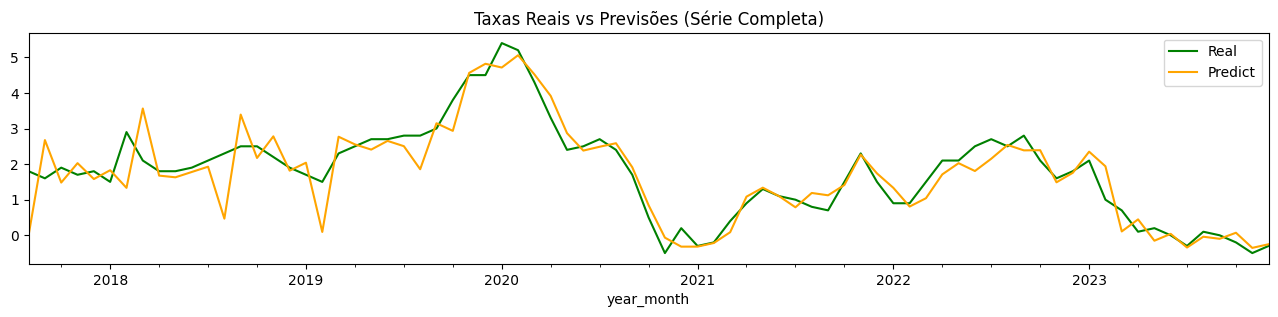

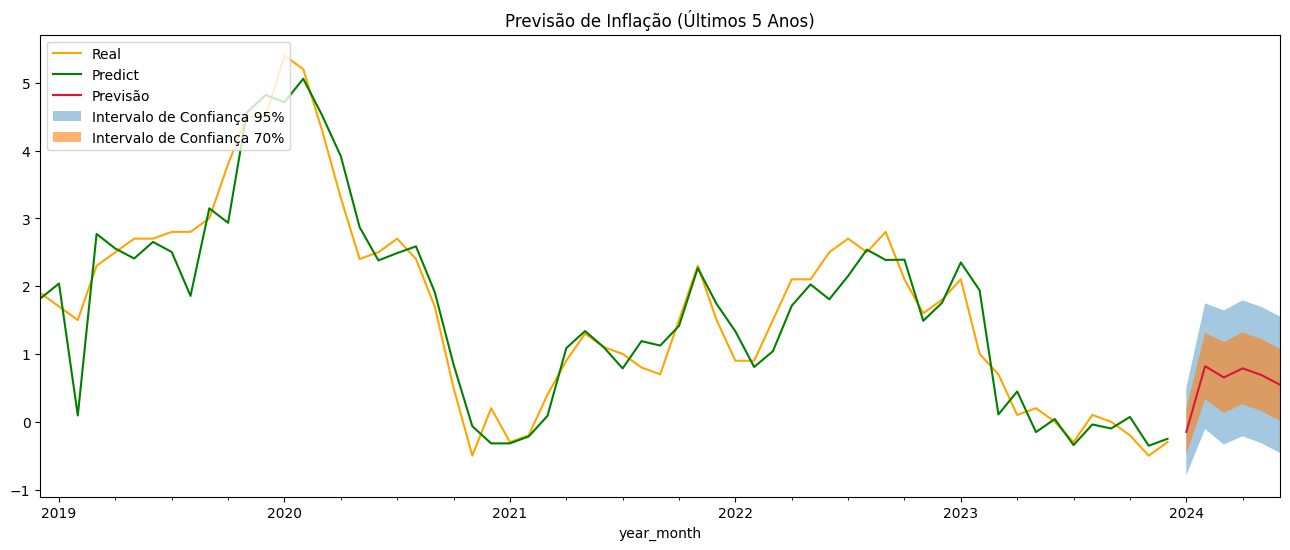

,Previsão [%]
2024-01-01,-0.2
2024-02-01,0.8
2024-03-01,0.7
2024-04-01,0.8
2024-05-01,0.7
2024-06-01,0.5


In [42]:
forecast_SARIMA(series=planilha3['CPI CHI'], order=(2, 0, 2), seasonal_order=(2, 0, 2, 12))

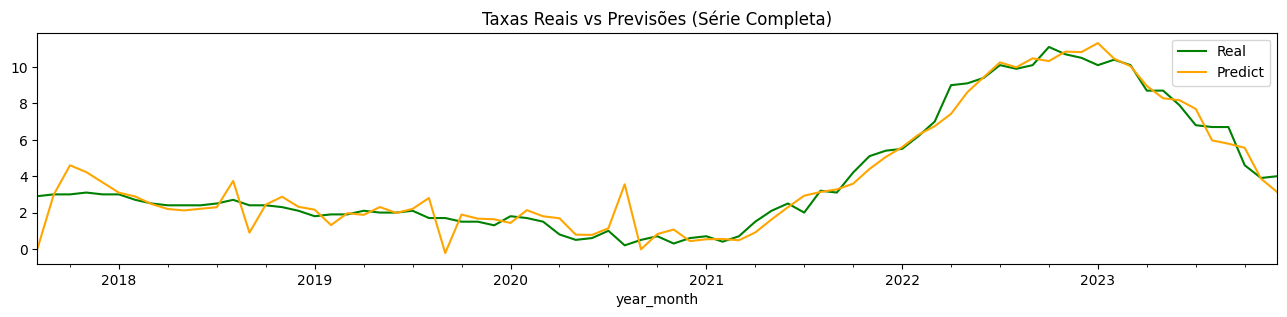

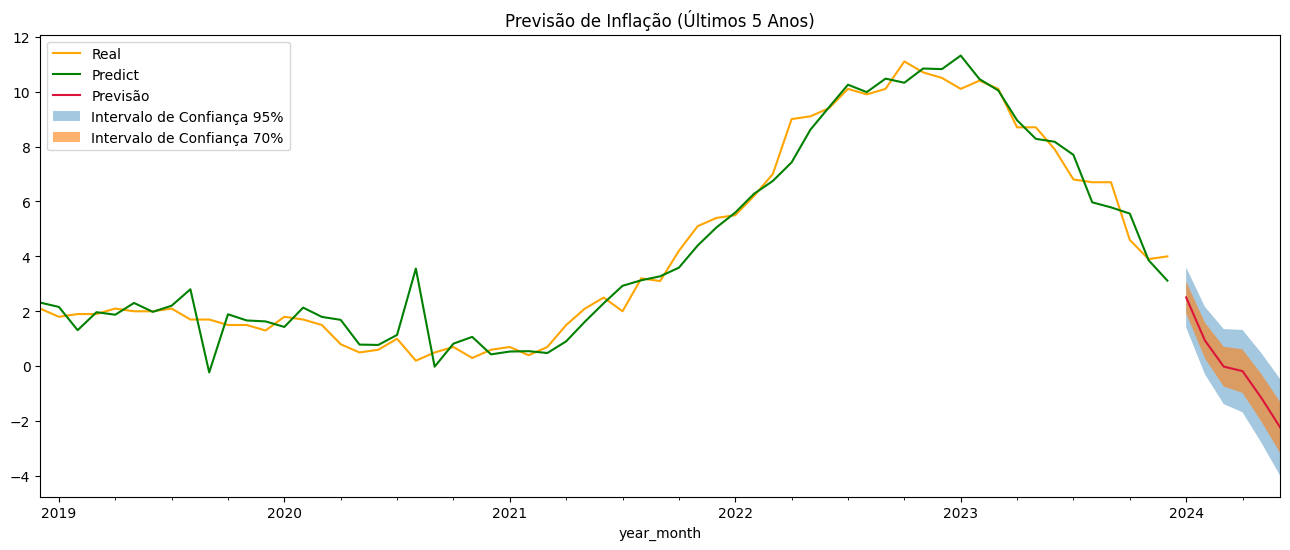

,Previsão [%]
2024-01-01,2.5
2024-02-01,0.9
2024-03-01,-0.0
2024-04-01,-0.2
2024-05-01,-1.1
2024-06-01,-2.2


In [43]:
forecast_SARIMA(series=planilha4['CPI UK'], order=(2, 0, 2), seasonal_order=(2, 1, 0, 12))


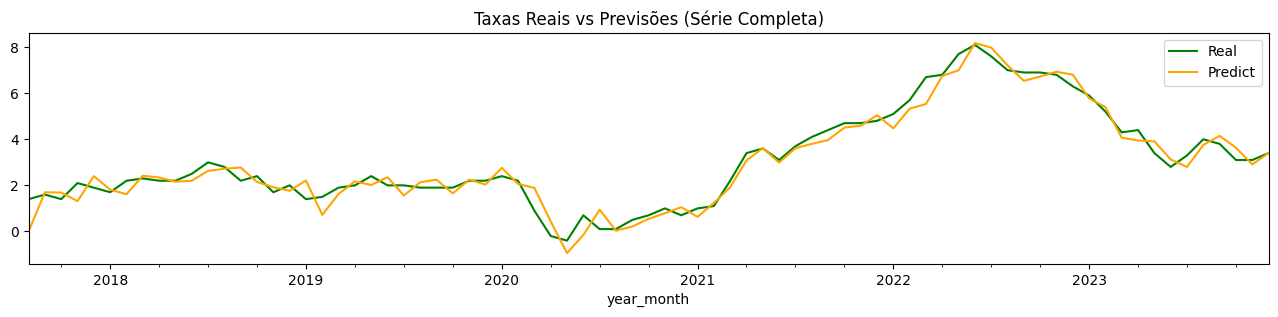

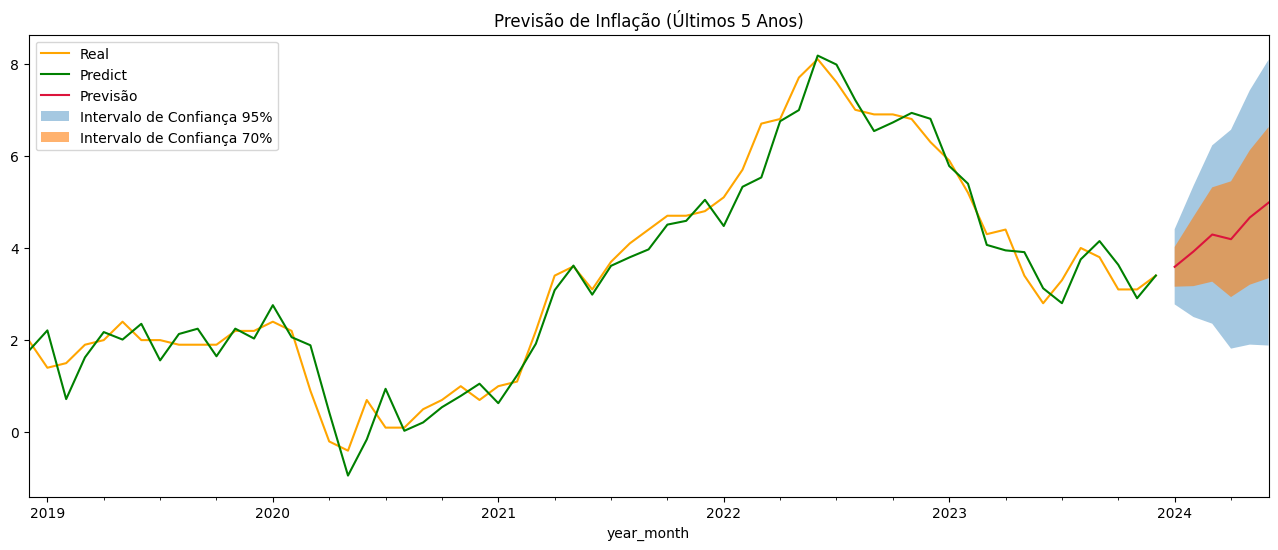

,Previsão [%]
2024-01-01,3.6
2024-02-01,3.9
2024-03-01,4.3
2024-04-01,4.2
2024-05-01,4.7
2024-06-01,5.0


In [44]:
forecast_SARIMA(series=planilha5['CPI CAN'], order=(1, 1, 0), seasonal_order=(2, 0, 0, 12))


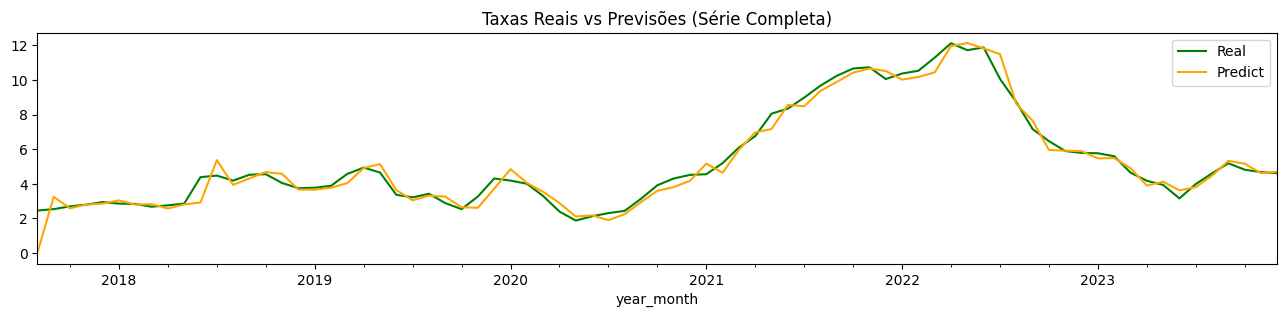

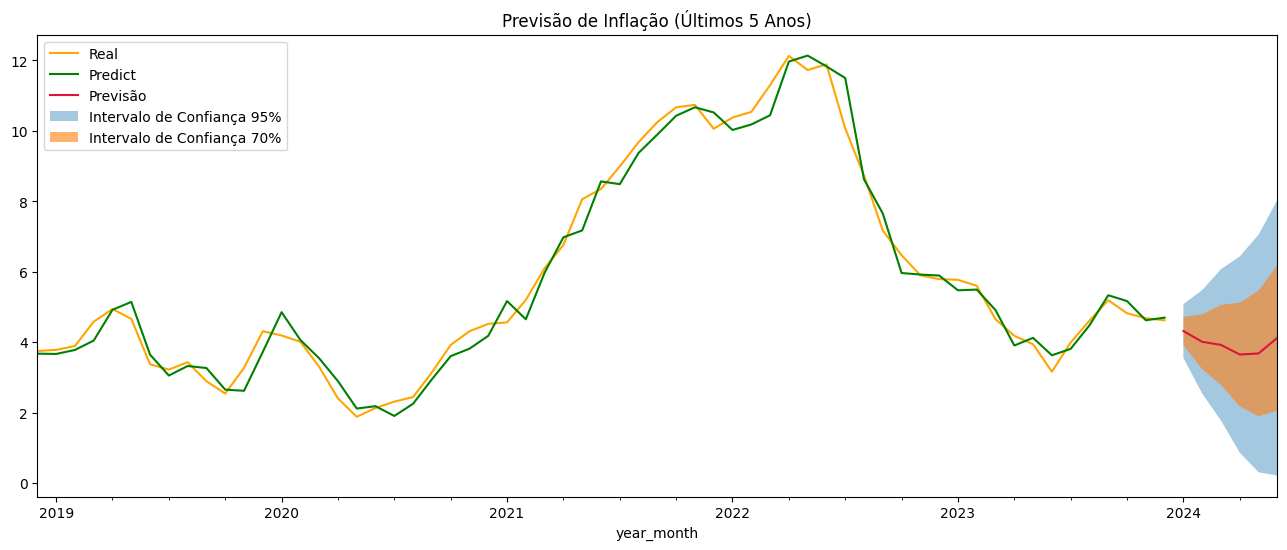

,Previsão [%]
2024-01-01,4.3
2024-02-01,4.0
2024-03-01,3.9
2024-04-01,3.6
2024-05-01,3.7
2024-06-01,4.1


In [45]:
forecast_SARIMA(series=planilha6['CPI BR'], order=(1, 1, 0), seasonal_order=(1, 0, 2, 12))


In [16]:
import pandas as pd

# Caminho para o arquivo CSV exportado do R
file_path = "C:/Users/Enrico.bisordi/OneDrive - Rio Bravo/Desktop/Nova pasta/merged.csv"

# Ler o arquivo CSV usando pandas
df = pd.read_csv(file_path, index_col='date.x')

# Exibir as primeiras linhas do dataframe
print(df.head())

           month_year   swap  IPCA  IPCA_lag  ipcaanual  ipca_exp   ipca  \
date.x                                                                     
2003-02-01    2003-02  29.44  1.57      2.25  15.847124      0.55  11.56   
2003-03-01    2003-03  27.62  1.23      1.57  16.572608      0.53  11.01   
2003-04-01    2003-04  25.21  0.97      1.23  16.769209      0.54   9.58   
2003-05-01    2003-05  23.29  0.61      0.97  17.235307      0.49   8.87   
2003-06-01    2003-06  22.29 -0.15      0.61  16.569860      0.55   8.07   

                selic  juro_real  juro_real_lag     IBC     hiato  hiato_lag  
date.x                                                                        
2003-02-01  25.677500   8.485645       9.252171  102.12  0.940647  -0.871086  
2003-03-01  26.316316   8.358488       8.485645  101.72  0.764971   0.940647  
2003-04-01  26.319000   8.178347       8.358488  101.08  0.416089   0.764971  
2003-05-01  26.308095   7.738956       8.178347   99.97 -0.405544   0.41

In [5]:
df = df[['IPCA']].copy()


In [10]:
find_optimal_orders(df['IPCA'], verbose=True)

Expected Fits: 324
========== SARIMAX Results ==========

1. SARIMAX(0, 0, 0)(0, 0, 0)[12],	AIC = 439.994749,	BIC = 443.536013
2. SARIMAX(0, 0, 0)(0, 0, 1)[12],	AIC = 310.659259,	BIC = 317.645382
3. SARIMAX(0, 0, 0)(0, 0, 2)[12],	AIC = 277.414242,	BIC = 287.741496
4. SARIMAX(0, 0, 0)(0, 1, 0)[12],	AIC = 276.171486,	BIC = 279.664547
5. SARIMAX(0, 0, 0)(0, 1, 1)[12],	AIC = 142.303853,	BIC = 149.188688
6. SARIMAX(0, 0, 0)(0, 1, 2)[12],	AIC = 139.580820,	BIC = 149.748035
7. SARIMAX(0, 0, 0)(1, 0, 0)[12],	AIC = 238.684932,	BIC = 245.679268
8. SARIMAX(0, 0, 0)(1, 0, 1)[12],	AIC = 160.803752,	BIC = 171.282937
9. SARIMAX(0, 0, 0)(1, 0, 2)[12],	AIC = 153.327201,	BIC = 167.096872
10. SARIMAX(0, 0, 0)(1, 1, 0)[12],	AIC = 226.216000,	BIC = 233.109475
11. SARIMAX(0, 0, 0)(1, 1, 1)[12],	AIC = 144.303783,	BIC = 154.631036
12. SARIMAX(0, 0, 0)(1, 1, 2)[12],	AIC = 136.503496,	BIC = 150.059783
13. SARIMAX(0, 0, 0)(2, 0, 0)[12],	AIC = 206.091881,	BIC = 216.432093
14. SARIMAX(0, 0, 0)(2, 0, 1)[12],	AIC = 

In [27]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

endog = df['IPCA']  # série temporal que você está modelando
exog = df[['ipca_exp', 'hiato','swap', 'juro_real', 'selic','ipcaanual']]  # variáveis exógenas

order = (1, 1, 0)  # parâmetros não sazonais (p, d, q)
seasonal_order = (0, 0, 1, 12)  # parâmetros sazonais (P, D, Q, S)

model = sm.tsa.SARIMAX(endog, exog=exog, order=order, seasonal_order=seasonal_order)
results = model.fit()

# Verifique os resultados do modelo
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 IPCA   No. Observations:                  256
Model:             SARIMAX(1, 1, 0)x(0, 0, [1], 12)   Log Likelihood                 -30.491
Date:                              Tue, 23 Jul 2024   AIC                             78.981
Time:                                      15:31:32   BIC                            110.853
Sample:                                  02-01-2003   HQIC                            91.801
                                       - 05-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ipca_exp       0.1503      0.307      0.489      0.625      -0.452       0.753
hiato          0.00

In [28]:
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps, exog=exog.iloc[-forecast_steps:])

# Coletar os intervalos de confiança
forecast_ci = forecast.conf_int()

# Exibir as previsões
print(forecast.predicted_mean)
print(forecast_ci)

2024-06-01   -0.028555
2024-07-01    0.093382
2024-08-01    0.180396
2024-09-01    0.259252
2024-10-01    0.239193
2024-11-01    0.275801
2024-12-01    0.324301
2025-01-01    0.328911
2025-02-01    0.439343
2025-03-01    0.278596
2025-04-01    0.316634
2025-05-01    0.400194
Freq: MS, Name: predicted_mean, dtype: float64
            lower IPCA  upper IPCA
2024-06-01   -0.562636    0.505526
2024-07-01   -0.590320    0.777083
2024-08-01   -0.637219    0.998011
2024-09-01   -0.671169    1.189674
2024-10-01   -0.792139    1.270525
2024-11-01   -0.847342    1.398945
2024-12-01   -0.883709    1.532312
2025-01-01   -0.958380    1.616202
2025-02-01   -0.922623    1.801309
2025-03-01   -1.154158    1.711350
2025-04-01   -1.183571    1.816839
2025-05-01   -1.164558    1.964945


In [38]:
endog = df['IPCA']  # série temporal que você está modelando
exog2 = df[['hiato','swap', 'juro_real', 'selic','ipcaanual']]  # variáveis exógenas

order = (1, 1, 0)  # parâmetros não sazonais (p, d, q)
seasonal_order = (0, 0, 1, 12)  # parâmetros sazonais (P, D, Q, S)

model2 = sm.tsa.SARIMAX(endog, exog=exog2, order=order, seasonal_order=seasonal_order)
results = model.fit()

# Verifique os resultados do modelo
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 IPCA   No. Observations:                  256
Model:             SARIMAX(1, 1, 0)x(0, 0, [1], 12)   Log Likelihood                 -30.491
Date:                              Tue, 23 Jul 2024   AIC                             78.981
Time:                                      16:22:15   BIC                            110.853
Sample:                                  02-01-2003   HQIC                            91.801
                                       - 05-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ipca_exp       0.1503      0.307      0.489      0.625      -0.452       0.753
hiato          0.00

In [44]:
endog = df['IPCA']
exog2 = df[['hiato', 'swap', 'juro_real', 'selic', 'ipcaanual']]

# Parâmetros do modelo SARIMAX
order = (1, 1, 0)  # parâmetros não sazonais (p, d, q)
seasonal_order = (0, 0, 1, 12)  # parâmetros sazonais (P, D, Q, S)

# Criar o modelo SARIMAX
model = sm.tsa.SARIMAX(endog, exog=sm.add_constant(exog2), order=order, seasonal_order=seasonal_order)

# Ajustar o modelo aos dados
results = model.fit()

# Número de passos de previsão desejados
forecast_steps = 12

# Últimos valores exógenos disponíveis para previsão
last_exog = exog2.iloc[-forecast_steps:]

# Adicionar a constante aos dados exógenos para alinhar com o modelo
last_exog = sm.add_constant(last_exog)

# Fazer previsões para os próximos passos, fornecendo os últimos valores exógenos
forecast = results.get_forecast(steps=forecast_steps, exog=last_exog)

# Coletar os intervalos de confiança das previsões
forecast_ci = forecast.conf_int()

# Exibir as previsões médias
print(forecast.predicted_mean)

# Exibir os intervalos de confiança das previsões
print(forecast_ci)

2024-06-01   -0.033226
2024-07-01    0.098935
2024-08-01    0.193869
2024-09-01    0.280019
2024-10-01    0.248856
2024-11-01    0.274137
2024-12-01    0.326649
2025-01-01    0.311417
2025-02-01    0.428581
2025-03-01    0.250845
2025-04-01    0.314015
2025-05-01    0.397959
Freq: MS, Name: predicted_mean, dtype: float64
            lower IPCA  upper IPCA
2024-06-01   -0.567655    0.501204
2024-07-01   -0.584476    0.782346
2024-08-01   -0.623277    1.011015
2024-09-01   -0.649724    1.209762
2024-10-01   -0.781639    1.279352
2024-11-01   -0.848029    1.396303
2024-12-01   -0.880258    1.533556
2025-01-01   -0.974657    1.597491
2025-02-01   -0.932062    1.789224
2025-03-01   -1.180488    1.682177
2025-04-01   -1.184677    1.812706
2025-05-01   -1.165191    1.961110


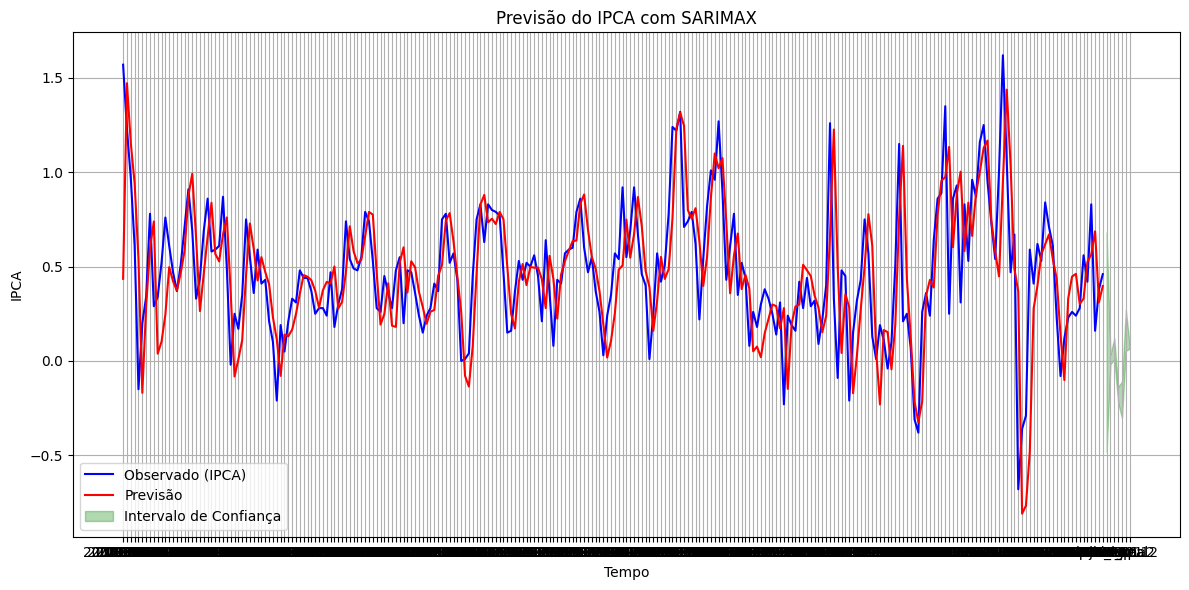

In [26]:
import matplotlib.pyplot as plt

# Plotar dados originais
plt.figure(figsize=(12, 6))
plt.plot(endog.index, endog, label='Observado (IPCA)', color='blue')

# Plotar previsões
plt.plot(results.fittedvalues.index, results.fittedvalues, label='Previsão', color='red')

# Plotar intervalo de confiança
ci = results.conf_int()
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='green', alpha=0.3, label='Intervalo de Confiança')

# Configurações do gráfico
plt.title('Previsão do IPCA com SARIMAX')
plt.xlabel('Tempo')
plt.ylabel('IPCA')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Exibir o gráfico
plt.show()